- CRSS where each sample corresponds to one person, not to one accident.  
- This one corresponds better to evaluating per phone.
- This version uses the feature value grouping based on the correlations

In [1]:
%%latex
\tableofcontents

<IPython.core.display.Latex object>

# Setup
## Import Libraries

In [2]:
import sys, copy, math, time, os

print ('Python version: {}'.format(sys.version))

from collections import Counter

import numpy as np
print ('NumPy version: {}'.format(np.__version__))
np.set_printoptions(suppress=True)

import scipy as sc
print ('SciPy version:  {}'.format(sc.__version__))

import tensorflow as tf
print ('TensorFlow version:  {}'.format(tf.__version__))

from tensorflow import keras
print ('Keras version:  {}'.format(keras.__version__))

from keras import layers
import keras.backend as K

from keras.utils.generic_utils import get_custom_objects

import pandas as pd
print ('Pandas version:  {}'.format(pd.__version__))
pd.set_option('display.max_rows', 500)

import seaborn as sns
print ('Seaborn version: {}'.format(sns.__version__))

import matplotlib.pyplot as plt
%matplotlib inline

# Library for reading Microsoft Access files
import pandas_access as mdb

import sklearn
print ('SciKit-Learn version: {}'.format(sklearn.__version__))
from sklearn.model_selection import train_test_split

import imblearn
print ('Imbalanced-Learn version: {}'.format(imblearn.__version__))
from imblearn.under_sampling import TomekLinks

# Set Randomness.  Copied from https://www.kaggle.com/code/abazdyrev/keras-nn-focal-loss-experiments
import random
np.random.seed(42) # NumPy
random.seed(42) # Python
tf.random.set_seed(42) # Tensorflow


Python version: 3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:21:17) 
[Clang 11.1.0 ]
NumPy version: 1.19.5
SciPy version:  1.7.1
TensorFlow version:  2.6.2
Keras version:  2.6.0
Pandas version:  1.3.4
Seaborn version: 0.11.2
SciKit-Learn version: 1.0.1
Imbalanced-Learn version: 0.8.1


## Import Data from Big Files (Not in GitHub Repo)

### accident.csv from CRSS

In [3]:
def Import_Data_Accident():
    print ('Import_Data_Accident()')

    df = pd.DataFrame([])
    for year in ['2016','2017','2018']:
        filename = '../CRSS/CRSS' + year + 'CSV/ACCIDENT.CSV'
        temp = pd.read_csv(filename, index_col=None)
        df = df.append(temp)

    for year in ['2019','2020']:
        filename = '../CRSS/CRSS' + year + 'CSV/accident.csv'
        temp = pd.read_csv(filename, index_col=None)
        df = df.append(temp)
    
    for feature in df:
        if 'NAME' in feature:
            df.drop(columns=[feature], inplace=True)

    print (df.shape)
    print ()
    return df

### person.csv from CRSS

In [4]:
def Import_Data_Person():
    print ('Import_Data_Person()')

    df = pd.DataFrame([])
    for year in ['2016','2017','2018']:
        filename = '../CRSS/CRSS' + year + 'CSV/PERSON.CSV'
        temp = pd.read_csv(filename, index_col=None)
        df = df.append(temp)

    for year in ['2019','2020']:
        filename = '../CRSS/CRSS' + year + 'CSV/person.csv'
        temp = pd.read_csv(filename, index_col=None, encoding='latin1')
        df = df.append(temp)

    for feature in df:
        if 'NAME' in feature:
            df.drop(columns=[feature], inplace=True)

    print (df.shape)
    print ()
    return df

### All Data

In [5]:
def Import_Data():
    print ('Import_Data()')
    df_Accident = Import_Data_Accident()
    df_Person = Import_Data_Person()
    
    print ()
    return df_Accident, df_Person

# Import Data from Limited CSV Files

In [6]:
def Import_Data_from_Limited():
    print ('Import_Data_from_Limited()')
    df_Accident = pd.read_csv('../CRSS/ACCIDENT.csv')
    df_Person = pd.read_csv('../CRSS/PERSON.csv')
    print ()
    
    return df_Accident, df_Person

# Build Database

In [7]:
def Build_Individual_Feature_with_Dict(df, data, feature, A):
    D = {}
    for B in A:
        for b in B[1]:
            D[b] = B[0]

    data[feature] = df[feature].replace(D)
    
#    print (feature)
#    print (df[feature].value_counts())
#    print ('isna(): ', df[feature].isna().sum())
#    print (data[feature].value_counts())
#    print ()

    return data
    

def Build_Accident_Dataset(df_Accident):
    print ('Build_Accident_Dataset()')
    data = pd.DataFrame()
    imputed = 1
    
    # Reference
    data['CASENUM'] = df_Accident['CASENUM']
    
    feature = 'HOUR_IM'
    A = [
        ['Early_Morn', [5,6]],
        ['Morning', [7,8,9,10]],
        ['Mid_Day', [11,12,13,14]],
        ['Rush_Hour', [15,16,17]],
        ['Early_Eve', [18,19]],
        ['Evening', [20,21,22]],
        ['Late_Nght',[23,0,1,2,3,4]],
             ]
    data = Build_Individual_Feature_with_Dict(df_Accident, data, feature, A)

    feature = 'INT_HWY'
    A = [
        [0, [0,9]],
        [1, [1]]
    ]
    data = Build_Individual_Feature_with_Dict(df_Accident, data, feature, A)

    feature = 'LGTCON_IM'
    A =  [
        ['Dark', [2]],
        ['Dawn_Lighted', [3,4,6]],
        ['Dusk', [5]],
        ['Daylight', [1,7]],
    ]
    data = Build_Individual_Feature_with_Dict(df_Accident, data, feature, A)

    feature = 'MONTH'
    A = [
        ['Winter', [1,2,3,12]],
        ['Spring_Fall', [4,5,10,11]],
        ['Summer', [6,7,8,9]],
    ]
    data = Build_Individual_Feature_with_Dict(df_Accident, data, feature, A)

    feature = 'PEDS'
    B = [x for x in list(df_Accident[feature].unique()) if x not in [0,1]]
#    print (B)
    A = [
        ['0', [0]],
        ['1', [1]],
        ['Multiple', B]
    ]
    data = Build_Individual_Feature_with_Dict(df_Accident, data, feature, A)

    feature = 'PERMVIT'
    B = [x for x in list(df_Accident[feature].unique()) if x not in [1,2]]
#    print (B)
    A = [
        ['1', [1]],
        ['2', [2]],
        ['Multiple', B]
    ]
    data = Build_Individual_Feature_with_Dict(df_Accident, data, feature, A)

    feature = 'REL_ROAD'
    A =  [
        ['Not_on_Road', [2,3,4,5,6,8,10,12,98,99]],
        ['On_Road', [1,11]],
        ['Parking_Area', [7]],
    ]
    data = Build_Individual_Feature_with_Dict(df_Accident, data, feature, A)

    feature = 'RELJCT2_IM'
    A = [
        ['A', [2,5,6,19]],
        ['B', [1,7,16]],
        ['C', [4,8,18]],
        ['D', [3,17,20]],
    ]
    data = Build_Individual_Feature_with_Dict(df_Accident, data, feature, A)


    feature = 'SCH_BUS'
    A = [
        ['0', [0]],
        ['1', [1]]
    ]
    data = Build_Individual_Feature_with_Dict(df_Accident, data, feature, A)


    feature = 'URBANICITY'
    A = [
        ['1', [1]],
        ['2', [2]]
    ]
    data = Build_Individual_Feature_with_Dict(df_Accident, data, feature, A)

    feature = 'VE_TOTAL'
    B = [x for x in list(df_Accident[feature].unique()) if x not in [1,2,3]]
    print (B)
    A = [
        ['1', [1]],
        ['2', [2]],
        ['3', [3]],
        ['Multiple', B]
    ]
    data = Build_Individual_Feature_with_Dict(df_Accident, data, feature, A)

    feature = 'WEATHR_IM'
    A = [
        ['A', [3,5]],
        ['B', [1]],
        ['C', [2]],
        ['D', [10]],
        ['E', [4,6,7,8,11,12]],
    ]
    data = Build_Individual_Feature_with_Dict(df_Accident, data, feature, A)

    feature = 'WKDY_IM'
    A = [
        ['Weekend', [1,7]],
        ['Weekday', [2,3,4,5,6]],
    ]
    data = Build_Individual_Feature_with_Dict(df_Accident, data, feature, A)


    feature = 'WRK_ZONE'
    A = [
        ['0', [0]],
        ['1', [1,4]],
        ['2', [2]],
        ['3', [3]],
    ]
    data = Build_Individual_Feature_with_Dict(df_Accident, data, feature, A)
    
    print ()
    return data

## Build_Person_Dataset

In [8]:
def Build_Person_Dataset(df_Person):
    print ('Build_Person_Dataset')
    data = pd.DataFrame()
    
    # Reference
    data['CASENUM'] = df_Person['CASENUM']
    
    data['HOSPITAL'] = df_Person['HOSPITAL'].apply(lambda x:1 if x in [1,2,3,4,5] else 0)

    df_Person['AGE_IM'] = df_Person['AGE_IM'].fillna(200)
    feature = 'AGE_IM'
    Age_Brackets = [0,7,16,19,53,71,200]
    M = ['00-06','07-15','16-18','19-52','53-70','71+','Unknown']
    A = []
    for i in range (6):
        for j in range (Age_Brackets[i], Age_Brackets[i+1]):
            A.append([M[i], [j]])
    A.append(['G',[200]])
    data = Build_Individual_Feature_with_Dict(df_Person, data, feature, A)

    
#    print (df_Person['SEX_IM'].value_counts())
    feature = 'SEX_IM'
    A = [
        ['Male', [1]],
        ['Female', [2]],
    ]
    data = Build_Individual_Feature_with_Dict(df_Person, data, feature, A)

#    11,5,12,8,4,7,6,10,13,9,2,1,3,
    feature = 'PER_TYP'
    A = [
        ['Not_in_Vehicle', [11,5,12,8,4,7,6,10,13]],
        ['In_VIT', [9,2,1]],
        ['In_VNIT', [3]]
    ]
    data = Build_Individual_Feature_with_Dict(df_Person, data, feature, A)

    
    feature = 'BODY_TYP'
    df_Person[feature] = df_Person[feature].fillna(99)
    df_Person[feature] = df_Person[feature].astype(int)
    # 86,87,82,89,81,83,80,84,88,85,90,95,11,97,96,58,45,12,32,91,
    # 10,2,3,1,59,30,4,
    # 19,42,5,49,8,16,6,14,52,9,
    # 20,22,40,34,31,15,29,92,39,55,93,17,21,50,48,28,7,65,
    # 51,61,67,63,62,66,79,78,64,72,98,60,99,nan,71,73,94,41,13,
    
    # Should we separate out busses?  Interesting correlation with age.  
    A = [
        ['Motorcycle', [86,87,82,89,81,83,80,84,88,85,90,95,11,97,96,58,45,12,32,91]],
        ['Car', [10,2,3,1,59,30,4]],
        ['SUV', [19,42,5,49,8,16,6,14,52,9]],
        ['Light_Truck', [20,22,40,34,31,15,29,92,39,55,93,17,21,50,48,28,7,65]],
        ['Heavy_Truck', [51,61,67,63,62,66,79,78,64,72,98,60,99,71,73,94,41,13]],
    ]

    B = [
        ['Motorcycle', [86,87,82,89,81,83,80,84,88,85,90,95,11,97,96,58,45,12,32,91]],
        ['Car', [10,2,3,1,59,30,4]],
        ['SUV', [19,42,5,49,8,16,6,14,52,9]],
        ['Light_Truck', [20,22,40,34,31,15,29,92,39,93,17,48,28,7,65]],
        ['Heavy_Truck', [61,67,63,62,66,79,78,64,72,98,60,99,71,73,94,41,13]],
        ['Bus', [50,55,21,51]]
    ]

    data = Build_Individual_Feature_with_Dict(df_Person, data, feature, A)

    feature = 'MAKE'
    df_Person[feature] = df_Person[feature].fillna(99)
    A = [
        ['A', [43,50,53,71,72,73,74,76,77]], 
        ['B', [9,14,18,21,22,24,37,52,64,65,92,98]],
        ['C', [6,35,36,39,55,63,67]],
        ['D', [13,20,34,69]],
        ['E', [30,49]],
        ['F', [2,12,19,41,58]],
        ['G', [7,23,25,42,47,54,59,93]],
        ['H', [3,10,29,31,32,38,45,48,51,62,90,94]],
        ['I', [1,33,46,82,84,85,86,87,89,97,99]],        
    ]
    data = Build_Individual_Feature_with_Dict(df_Person, data, feature, A)

    return data



## Merge Datasets

In [9]:
def Build_Dataset(df_Accident, df_Person):
    print ('Build_Dataset()')
    print ()
    data_Accident = Build_Accident_Dataset(df_Accident)
    data_Person = Build_Person_Dataset(df_Person)
    
    U = data_Accident.CASENUM.unique()
    V = data_Person.CASENUM.unique()
    U = set(U)
    V = set(V)
    print ('Do all of the cases in data_Person appear in data_Accident?')
    print (V.issubset(U))
    print ()
    
    data = pd.merge(
        data_Person, data_Accident, 
        left_on='CASENUM', right_on = 'CASENUM', 
        how="left", sort=False
    )
    
    data.drop(columns=['CASENUM'], inplace=True)
    data.astype(bool)

    print (data.head())

    return data

In [10]:
def Merge_Experiment():
    left = pd.DataFrame(
    {
        'A': ['a0','a1','a2'],
        'B': ['b0','b1','b2'],
        'C': ['1', '2', '1']
    })
    right = pd.DataFrame(
        {
            'D': ['d0', 'd1', 'd2'],
            'E': ['1','2','3']
        }
    )
    print (left)
    print (right)
    
    result = pd.merge(left, right, left_on='C', right_on = 'E', how="left", sort=False)
    print (result)

Merge_Experiment()

    A   B  C
0  a0  b0  1
1  a1  b1  2
2  a2  b2  1
    D  E
0  d0  1
1  d1  2
2  d2  3
    A   B  C   D  E
0  a0  b0  1  d0  1
1  a1  b1  2  d1  2
2  a2  b2  1  d0  1


## Remove Empty Features

In [11]:
def Remove_Empty_Features(data):
    print ()
    print ('Remove_Empty_Features()')
    for feature in data:
        S = data[feature].sum()
        if S==0:
            data.drop(columns=[feature], inplace=True)
            print ('Dropping Feature ', feature)
    print ()
    return data

## Correlation

In [12]:
def Correlation(data, target, feature):
    TN = 0
    FP = 0
    FN = 0
    TP = 0
    contingency_matrix = pd.crosstab(data[target], data[feature])
    cm = contingency_matrix.values.tolist()
    corr = cm[1][1] / (cm[0][1] + cm[1][1])
    per = (cm[0][1] + cm[1][1])/(cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])
    per = round(per*100,2)
    corr = round(corr*100,2)
    print ("    - ", feature)
    print (contingency_matrix)
    print ('        - per = ', per)
    print ("        - corr = ", corr)
    print ()
    return (per, corr)


def Correlation_All(data, target):
    print ('Correlation_All')
    Corr = []
    for feature in data:
        per, corr = Correlation(data, target, feature)
        Corr.append([feature, corr, per])
    Corr.sort(key=lambda x:x[1], reverse=True)
    for row in Corr:
        print (row)    
    
    print ()
    return 0

    

# Crosstabs

   Ambulance  Age  Sex
0          0    1    1
1          0    2    1
2          0    3    2
3          0    1    2
4          0    2    1
5          1    3    1
6          1    1    2
7          1    2    2
8          1    3    1
9          1    1    1

Crosstabs_Correlation
['Age', 'Sex']

Age Sex
[1, 2, 3]
[1, 2]

Count Crashes
       1  2  Total
1      2  2      4
2      2  1      3
3      2  1      3
Total  6  4     10

Hospitalization Count
       1  2  Total
1      1  1      2
2      0  1      1
3      2  0      2
Total  3  2      5

Hospitalization Rate
         1    2  Total
1      0.5  0.5    1.0
2      0.0  1.0    1.0
3      1.0  0.0    1.0
Total  1.5  1.5    3.0

Rate Normalized by Row
         1    2  Total
1      0.5  0.5    1.0
2      0.0  1.0    1.0
3      1.0  0.0    1.0
Total  1.5  1.5    3.0

Age Sex


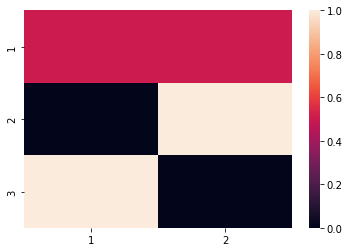


Rate Normalized by Column
           1      2  Total
1      0.333  0.333  0.666
2      0.000  0.667  0.667
3      0.667  0.000  0.667
Total  1.000  1.000  2.000

Age Sex


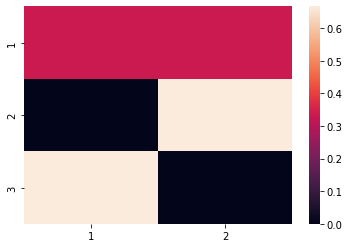

In [13]:
def Crosstabs_Correlation(data, target):
    print ('Crosstabs_Correlation')
    TeX = open('../Crosstabs_Images/Crosstabs_Correlation.tex', 'w')
    TeX.write('\\documentclass{article}\n')
    TeX.write('\\usepackage[margin=1in]{geometry}\n')
    TeX.write('\\usepackage{booktabs}\n')
    TeX.write('\\usepackage{hyperref}\n')
    TeX.write('\\usepackage{graphicx}\n')
    TeX.write('\\begin{document}\n')
    TeX.write('\\begin{center}\n')
    TeX.write('{\\huge Crosstabs Between Features in CRSS and Correlation to Hospitalization}')
    TeX.write('\\end{center}\n\\newpage\n')
    TeX.write('\\tableofcontents\n\\newpage\n')
#     df[(df.a > 1) & (df.a < 3)].sum()
    n = len(data)
    m = len(data[data[target]==1])
    A = list(data.columns)
    A.remove(target)
    print (A)
    print ()
    for i in range (len(A)-1):
        TeX.write('\\section{%s}\n' % (A[i].replace('_', '\_')))
        B = sorted(list(data[A[i]].unique()))
        for j in range (i+1,len(A)):
            print (A[i], A[j])
            TeX.write('\\subsection{%s v/s %s}\n' % (A[i].replace('_', '\_'), A[j].replace('_', '\_')))
            
            print (list(data[A[i]].unique()))
            print (list(data[A[j]].unique()))
            print ()
            C = sorted(list(data[A[j]].unique()))
            D = np.empty([len(B), len(C)]) # Percentage
            E = np.empty([len(B), len(C)]) # Correlation
            for k in range (len(B)):
                for l in range (len(C)):
#                    df[(df.a > 1) & (df.a < 3)].sum()
                    D[k][l] = len(data[(data[A[i]]==B[k]) & (data[A[j]]==C[l])])
                    E[k][l] = len(data[(data[A[i]]==B[k]) & (data[A[j]]==C[l]) & (data[target]==1)])

            print ('Count Crashes')
            F = pd.DataFrame(D, index=B, columns=C)
            F.loc["Total"] = F.sum()
            F['Total'] = F.sum(axis=1)
            F = F.astype(int)
            print (F)
            TeX.write('Count Crashes\n\n')
            TeX.write('\\begin{center}\n')
            TeX.write(F.to_latex())
            TeX.write('\\end{center}\n')
            TeX.write('\n')
            print ()
            
            print ('Hospitalization Count')
            F = pd.DataFrame(E, index=B, columns=C)
            F.loc["Total"] = F.sum()
            F['Total'] = F.sum(axis=1)
            F = F.astype(int)

            print (F)
            TeX.write('Hospitalization Count\n\n')
            TeX.write('\\begin{center}\n')
            TeX.write(F.to_latex())
            TeX.write('\\end{center}\n')
            TeX.write('\n')
            print ()


            print ('Hospitalization Rate')
            F = pd.DataFrame(E/D, index=B, columns=C).round(3)
            F.loc["Total"] = F.sum()
            F['Total'] = F.sum(axis=1)
            print (F)
            print ()
            TeX.write('Hospitalization Rate\n\n')
            TeX.write('\\begin{center}\n')
            TeX.write(F.to_latex())
            TeX.write('\\end{center}\n')
            TeX.write('\n')

            
#            print ('Count Normalized by Row')
#            F = pd.DataFrame(D, index=B, columns=C)
#            F = F.div(F.sum(axis=1), axis=0).round(3)
#            F.loc["Total"] = F.sum()
#            F['Total'] = F.sum(axis=1)
#            print (F)
#            print ()
#            TeX.write('Count Normalized by Row\n\n')
#            TeX.write('\\begin{center}\n')
#            TeX.write(F.to_latex())
#            TeX.write('\\end{center}\n')
#            TeX.write('\n')


            print ('Rate Normalized by Row')
            F = pd.DataFrame(E/D, index=B, columns=C)
            F = F.div(F.sum(axis=1), axis=0).round(3)
            G = F.copy(deep=True)
            F.loc["Total"] = F.sum()
            F['Total'] = F.sum(axis=1)
            print (F)
            print ()
            TeX.write('\\newpage\n')
            TeX.write('{\\bf %s v/s %s}\n\n' % (A[i].replace('_', '\_'), A[j].replace('_', '\_')))
            TeX.write('Rate Normalized by Row\n\n')
            TeX.write('\\begin{center}\n')
            TeX.write(F.to_latex())
            TeX.write('\\end{center}\n')
            TeX.write('\n')

            
            print (A[i], A[j])
            ax = sns.heatmap(G)
            filename = A[i] + '_' + A[j] + '_Row.png'
            plt.savefig('../Crosstabs_Images/' + filename, bbox_inches="tight")
            TeX.write('\\includegraphics{%s}\n' % (filename))
            plt.show()
            print ()

#            print ('Count Normalized by Column')
#            F = pd.DataFrame(D, index=B, columns=C)
#            H = F.sum(0)
#            F = F/H
#            F = F.round(3)
#            F.loc["Total"] = F.sum()
#            F['Total'] = F.sum(axis=1)
#            print (F)
#            print ()
#            TeX.write('Count Normalized by Column\n\n')
#            TeX.write('\\begin{center}\n')
#            TeX.write(F.to_latex())
#            TeX.write('\\end{center}\n')
#            TeX.write('\n')


            print ('Rate Normalized by Column')
            F = pd.DataFrame(E/D, index=B, columns=C)
            H = F.sum(0)
            F = F/H
            F = F.round(3)
            G = F.copy(deep=True)
            F.loc["Total"] = F.sum()
            F['Total'] = F.sum(axis=1)
            print (F)
            print ()
            TeX.write('\\newpage\n')
            TeX.write('{\\bf %s v/s %s}\n\n' % (A[i].replace('_', '\_'), A[j].replace('_', '\_')))
            TeX.write('Rate Normalized by Column\n\n')
            TeX.write('\\begin{center}\n')
            TeX.write(F.to_latex())
            TeX.write('\\end{center}\n')
            TeX.write('\n')


            print (A[i], A[j])
            ax = sns.heatmap(G)
            filename = A[i] + '_' + A[j] + '_Column.png'
            plt.savefig('../Crosstabs_Images/' + filename, bbox_inches="tight")
            TeX.write('\\includegraphics{%s}\n' % (filename))
            TeX.write('\\newpage')
            plt.show()
            print ()


    TeX.write('\\end{document}\n')      
    TeX.close()
    print ()
            

def Test_Crosstabs_Correlation():
    data = pd.DataFrame({
        "Ambulance":[0,0,0,0,0,1,1,1,1,1], 
        "Age":[1,2,3,1,2,3,1,2,3,1],
        'Sex':[1,1,2,2,1,1,2,2,1,1]
    })
    target = 'Ambulance'
    print (data)
    print ()
    Crosstabs_Correlation(data, target)
    
Test_Crosstabs_Correlation()

# Narrow_Features()

In [14]:
def Narrow_Features(data):
    print ('Narrow Features')
    for feature in data:
        print (feature)
    print ()

    Drop = [
#        'HOSPITAL',

#        'AGE_IM',
#        'SEX_IM',

#        'HOUR_IM',
#        'MONTH',
#        'WKDY_IM',

#        'INT_HWY',
#        'URBANICITY',

#        'WEATHR_IM',

#        'REL_ROAD',
#        'RELJCT2_IM',

#        'LGTCON_IM',
#        'WRK_ZONE',

#        'BODY_TYP',
#        'MAKE',

#        'PEDS',
#        'PERMVIT',
#        'SCH_BUS',
#        'VE_TOTAL',

    ]

    data_narrowed = data.drop(columns=Drop)
    print ()
    print ('New Features after Narrowing:')
    for feature in data_narrowed:
        print ('\t ' + feature)
    
    print ()
    return data_narrowed

# Feature Engineering: Cross Two Features

In [15]:
def Feature_Engineering_Cross_Two(data):
    print ('Feature_Engineering_Cross_Two')
    Pairs = [
        ['AGE_IM', 'SEX_IM', 'AGE_x_SEX'],
        ['AGE_IM', 'SCH_BUS', 'AGE_x_SCH_BUS']
    ]
    for P in Pairs:
#        df['bar'] = df.bar.map(str) + " is " + df.foo
        data[P[2]] = data[P[0]].map(str) + '_x_' + data[P[1]]
    
#    Tried crossing age with school bus by putting age into two bins, 
#        but got better results by keeping all of the age bins
#    filters = [
#        (data.AGE_IM.isin(['00-06','07-15','16-18'])) & (data.SCH_BUS=='0'),
#        (data.AGE_IM.isin(['00-06','07-15','16-18'])) & (data.SCH_BUS=='1'),
#        (data.AGE_IM.isin(['19-52','53-70','71+'])) & (data.SCH_BUS=='0'),
#        (data.AGE_IM.isin(['19-52','53-70','71+'])) & (data.SCH_BUS=='1'),
#    ]
#    values = ['00-18_x_0', '00-18_x_1', '19+_x_0', '19+_x_1']
#
#    data['AGE_IM_x_SCH_BUS'] = np.select(filters, values, 42)
    
    print ()
    return data
        

# Get_Dummies()

In [16]:
def Get_Dummies(data):
    print ('Get_Dummies')
    data_dummies = pd.get_dummies(data)
    for feature in data_dummies:
        print (feature)
    print ()
    return data_dummies

# Train-Test Split

In [17]:
def Split_Data(data, target):
    print ()
    print ('Split_Data()')
    X = data.drop([target], axis=1)
    y = data[target]
    x_train, x_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )
    print (
        x_train.shape, 
        y_train.shape, y_train[y_train==1].shape, 
        x_test.shape, 
        y_test.shape, y_test[y_test==1].shape
    )
    return x_train, x_test, y_train, y_test

# Loss Functions

## alpha_weighted_binary_crossentropy Function

In [18]:
def alpha_weighted_binary_crossentropy(y_true, y_pred):
    p = 88.8
    alpha = (p/(p+1))*1.0
    # Note:  y_true has to be the same type as y_pred to use in the "keras.backend.binary_crossentropy" function below.
    y_true = tf.cast(y_true, dtype=y_pred.dtype)


    binary_crossentropy = keras.backend.binary_crossentropy(y_true, y_pred)
#    print (binary_crossentropy.numpy())
    weights = tf.where(tf.equal(y_true,1),alpha, 1-alpha)
#    print (weights.numpy())
    product = tf.multiply(binary_crossentropy, weights)
#    print (product.numpy())
    loss = keras.backend.mean(product)
#    print (loss.numpy())
#    print (loss)
    return loss

## Focal Loss

In [19]:
def focal_loss(y_true, y_pred):
    # The dataset has  259077  elements.
    # The target group has  31891  elements.
    # Our target is  12.3095 % of the dataset.
    # There are  8.12  negative elements for each positive.    
#    p = 8.12
    p = 7.46

    alpha = (p/(p+1))*1.0

    gamma_1 = 0.0 # Must be float for the tf.math.pow() function to work.
    gamma_2 = 0.0
    y_true = tf.cast(y_true, dtype=y_pred.dtype)
    binary_crossentropy = keras.backend.binary_crossentropy(y_true, y_pred)
#    print (binary_crossentropy.numpy())
    weights = tf.where(tf.equal(y_true,1),alpha, 1-alpha)
#    print (weights.numpy())
    focal = tf.where(tf.equal(y_true,1), (1.0-y_pred), (y_pred))
    power = tf.where(tf.equal(y_true,1), gamma_1, gamma_2)
    focal_power = tf.math.pow(focal,power)
#    print (focal.numpy())
#    print (power.numpy())
#    print (focal_power.numpy())
    product = tf.multiply(binary_crossentropy, weights)
    focal_power_product = tf.multiply(product, focal_power)
#    print (focal_power_product.numpy())
    loss = keras.backend.mean(focal_power_product)
#    print (loss.numpy())
    return loss

## Focal Loss with Parameters
- Adapted from https://www.kaggle.com/code/abazdyrev/keras-nn-focal-loss-experiments

In [20]:
def focal_loss_with_parameters(alpha=0.5, gamma_1=0.0, gamma_2=0.0):
    print ('focal_loss_with_parameters')
    print ('alpha = ', alpha, ' gamma_1 = ', gamma_1, ' gamma_2 = ', gamma_2)
    def focal_loss(y_true, y_pred):
        print ('focal_loss')
        print ('alpha = ', alpha, ' gamma_1 = ', gamma_1, ' gamma_2 = ', gamma_2)

        y_true = tf.cast(y_true, dtype=y_pred.dtype)
        binary_crossentropy = keras.backend.binary_crossentropy(y_true, y_pred)
        weights = tf.where(tf.equal(y_true,1),alpha, 1-alpha)
        focal = tf.where(tf.equal(y_true,1), (1.0-y_pred), (y_pred))
        power = tf.where(tf.equal(y_true,1), gamma_1, gamma_2)
        focal_power = tf.math.pow(focal,power)
        product = tf.multiply(binary_crossentropy, weights)
        focal_power_product = tf.multiply(product, focal_power)
        loss = keras.backend.mean(focal_power_product)
        return loss
    
    return focal_loss





# Model

In [21]:
def Make_Model_1(x_train):
    print ()
    print ("Make_Model_1()")
    model = keras.Sequential(
        [
            keras.layers.Dense(
                256, activation="relu", input_shape=(x_train.shape[-1],)
            ),
#            keras.layers.Dense(256, activation="relu"),
#            keras.layers.Dropout(0.3),
#            keras.layers.Dense(256, activation="relu"),
#            keras.layers.Dropout(0.3),
            keras.layers.Dense(1, activation="sigmoid"),
        ]
    )
    print (model.summary())
    return model
    
def Make_Model_2(x_train):
    # Model adapted from https://www.kaggle.com/code/parthsuresh/binary-classifier-using-keras-97-98-accuracy
    print ()
    print ("Make_Model_2")
    model = keras.Sequential()
    model.add(keras.layers.Dense(10, input_shape=(x_train.shape[-1],), kernel_initializer='normal', activation='relu'))
    model.add(keras.layers.Dense(1, kernel_initializer='normal', activation='sigmoid'))
    print (model.summary())

    return model    

def Compile_Model(model, loss_fn):
    print ()
    print ('Compile_Model')
    model.compile(
#        loss = alpha_weighted_binary_crossentropy, 
        loss = [loss_fn],
        optimizer='adam', 
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.TrueNegatives(),
            tf.keras.metrics.FalsePositives(),
            tf.keras.metrics.FalseNegatives(),
            tf.keras.metrics.TruePositives()
        ]
    )
    return model

def Fit_Model(x_train, y_train, x_test, y_test, model):
    print ()
    print ('Fit_Model()')
    # fit the keras model on the dataset
    model.fit(x_train, y_train, epochs=10, batch_size=2048, verbose=0)
    # evaluate the keras model
    #_, metric = model.evaluate(x_test, y_test, verbose=0)
    #print('Model Evaluation: %.2f' % (metric*100))
    (loss, accuracy, precision, recall,
     TN, FP, FN, TP
    ) = model.evaluate(x_test, y_test, verbose=1)
    Confusion = np.array([[TN,FP],[FN,TP]])
    print (Confusion)
    print (' &  &  &  &  & ', int(TN), ' & ', int(FP), '\cr')
    print (' &&&&& ', int(FN), ' & ', int(TP), '\cr\hline')
    # Precision is the proportion of sent ambulances that are needed.
    print ('Precision = ', round((TP*100)/(TP+FP),2), '%')
    # Recall is the proportion of needed ambulances that are sent.  
    print ('Recall = ', round((TP*100)/(TP+FN),2), '%')
    print ('True Negative Rate = ', round((TN*100)/(TN+FP),2), '%')

# Main()

Import_Data_from_Limited()

Build_Dataset()

Build_Accident_Dataset()
[4, 5, 6, 7, 9, 11, 8, 10, 13, 15]

Build_Person_Dataset
Do all of the cases in data_Person appear in data_Accident?
True

   HOSPITAL AGE_IM  SEX_IM PER_TYP     BODY_TYP MAKE    HOUR_IM  INT_HWY  \
0         0    71+    Male  In_VIT          Car    B    Mid_Day        0   
1         0  19-52    Male  In_VIT          SUV    E    Mid_Day        0   
2         0  16-18    Male  In_VIT  Light_Truck    G  Early_Eve        0   
3         0  16-18  Female  In_VIT          Car    F  Early_Eve        0   
4         0  16-18    Male  In_VIT          Car    F  Early_Eve        0   

      LGTCON_IM   MONTH PEDS   PERMVIT REL_ROAD RELJCT2_IM SCH_BUS URBANICITY  \
0      Daylight  Winter    0         2  On_Road          B       0          2   
1      Daylight  Winter    0         2  On_Road          B       0          2   
2  Dawn_Lighted  Winter    0  Multiple  On_Road          A       0          2   
3  Dawn_Lighted  Winter   

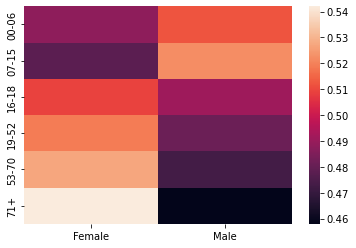


Rate Normalized by Column
       Female   Male  Total
00-06   0.119  0.132  0.251
07-15   0.155  0.178  0.333
16-18   0.146  0.149  0.295
19-52   0.167  0.163  0.330
53-70   0.190  0.180  0.370
71+     0.223  0.198  0.421
Total   1.000  1.000  2.000

AGE_IM SEX_IM


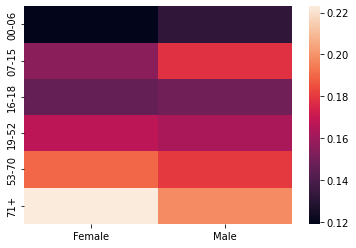


AGE_IM PER_TYP
['71+', '19-52', '16-18', '53-70', '00-06', '07-15']
['In_VIT', 'Not_in_Vehicle', 'In_VNIT']

Count Crashes
       In_VIT  In_VNIT  Not_in_Vehicle   Total
00-06   24304       92             574   24970
07-15   30760      120            2469   33349
16-18   40287       68            1425   41780
19-52  381465     1439           12555  395459
53-70  109724      408            4846  114978
71+     32487       68            1183   33738
Total  619027     2195           23052  644274

Hospitalization Count
       In_VIT  In_VNIT  Not_in_Vehicle   Total
00-06    2616        5             387    3008
07-15    3911       11            1386    5308
16-18    5105        6             787    5898
19-52   54678      133            7546   62357
53-70   16948       37            3264   20249
71+      5929        6             855    6790
Total   89187      198           14225  103610

Hospitalization Rate
       In_VIT  In_VNIT  Not_in_Vehicle  Total
00-06   0.108    0.054           

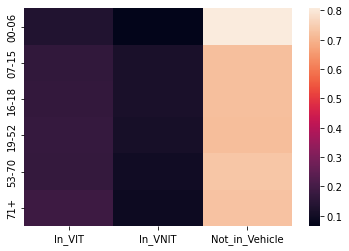


Rate Normalized by Column
       In_VIT  In_VNIT  Not_in_Vehicle  Total
00-06   0.128    0.107           0.178  0.413
07-15   0.151    0.181           0.148  0.480
16-18   0.151    0.175           0.146  0.472
19-52   0.170    0.183           0.159  0.512
53-70   0.183    0.179           0.178  0.540
71+     0.217    0.175           0.191  0.583
Total   1.000    1.000           1.000  3.000

AGE_IM PER_TYP


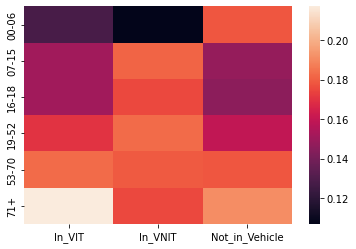


AGE_IM BODY_TYP
['71+', '19-52', '16-18', '53-70', '00-06', '07-15']
['Car', 'SUV', 'Light_Truck', 'Heavy_Truck', 'Motorcycle']

Count Crashes
          Car  Heavy_Truck  Light_Truck  Motorcycle     SUV   Total
00-06    9048          669         6780          24    8449   24970
07-15   10884         2975         9225         248   10017   33349
16-18   20473         2321         7085         429   11472   41780
19-52  159728        35144        79795       11941  108851  395459
53-70   35375        12641        27303        3693   35966  114978
71+     13065         2036         7080         343   11214   33738
Total  248573        55786       137268       16678  185969  644274

Hospitalization Count
         Car  Heavy_Truck  Light_Truck  Motorcycle    SUV   Total
00-06   1166          392          518           9    923    3008
07-15   1588         1396          909         125   1290    5308
16-18   2762          798          819         236   1283    5898
19-52  24028         8235

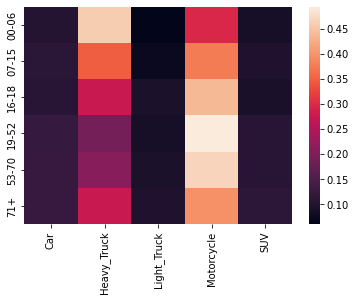


Rate Normalized by Column
         Car  Heavy_Truck  Light_Truck  Motorcycle    SUV  Total
00-06  0.140        0.249        0.113       0.114  0.136  0.752
07-15  0.158        0.199        0.146       0.153  0.160  0.816
16-18  0.146        0.146        0.171       0.167  0.139  0.769
19-52  0.163        0.100        0.158       0.184  0.164  0.769
53-70  0.179        0.119        0.182       0.190  0.179  0.849
71+    0.214        0.186        0.230       0.192  0.221  1.043
Total  1.000        0.999        1.000       1.000  0.999  4.998

AGE_IM BODY_TYP


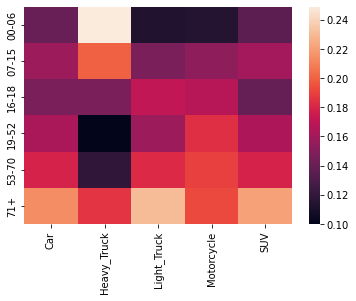


AGE_IM MAKE
['71+', '19-52', '16-18', '53-70', '00-06', '07-15']
['B', 'E', 'G', 'F', 'I', 'D', 'A', 'C', 'H']

Count Crashes
           A      B       C      D      E       F      G      H      I   Total
00-06     64   3903    5278   3535   3123    4489   3426    544    608   24970
07-15    170   4657    6006   4636   4050    5768   4320    712   3030   33349
16-18    300   6650    7042   5995   5355    8363   4425   1143   2507   41780
19-52   8779  54476   66293  54752  48533   74533  45145  11160  31788  395459
53-70   2804  14186   16785  15482  14802   21682  13648   4018  11571  114978
71+      240   5306    5360   4833   4731    6185   3904   1117   2062   33738
Total  12357  89178  106764  89233  80594  121020  74868  18694  51566  644274

Hospitalization Count
          A      B      C      D      E      F     G     H      I   Total
00-06    10    417    583    411    313    500   346    38    390    3008
07-15    66    596    776    666    503    747   448    87   1419    5

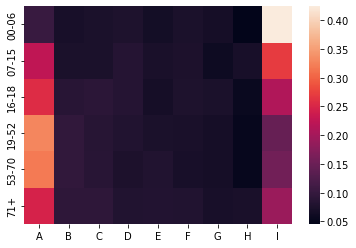


Rate Normalized by Column
           A      B      C      D      E      F      G      H      I  Total
00-06  0.058  0.115  0.122  0.136  0.126  0.139  0.138  0.110  0.264  1.208
07-15  0.144  0.137  0.143  0.168  0.156  0.161  0.142  0.193  0.193  1.437
16-18  0.152  0.148  0.156  0.156  0.136  0.153  0.159  0.138  0.138  1.336
19-52  0.216  0.182  0.166  0.164  0.162  0.158  0.165  0.147  0.106  1.466
53-70  0.227  0.197  0.184  0.170  0.192  0.169  0.181  0.159  0.124  1.603
71+    0.204  0.220  0.227  0.207  0.227  0.220  0.215  0.253  0.176  1.949
Total  1.001  0.999  0.998  1.001  0.999  1.000  1.000  1.000  1.001  8.999

AGE_IM MAKE


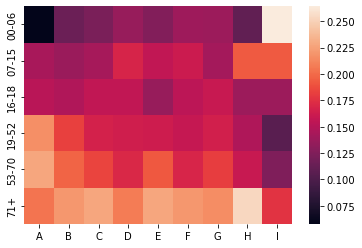


AGE_IM HOUR_IM
['71+', '19-52', '16-18', '53-70', '00-06', '07-15']
['Mid_Day', 'Early_Eve', 'Early_Morn', 'Evening', 'Morning', 'Rush_Hour', 'Late_Nght']

Count Crashes
       Early_Eve  Early_Morn  Evening  Late_Nght  Mid_Day  Morning  Rush_Hour  \
00-06       3239         351     2022        652     6588     4438       7680   
07-15       4884         545     3458       1181     7405     5072      10804   
16-18       5487         965     5439       2930     9313     5753      11893   
19-52      48086       16624    40986      32613    88609    68087     100454   
53-70      12638        4592     9047       4897    31910    21404      30490   
71+         3200         617     1863        691    12326     6200       8841   
Total      77534       23694    62815      42964   156151   110954     170162   

        Total  
00-06   24970  
07-15   33349  
16-18   41780  
19-52  395459  
53-70  114978  
71+     33738  
Total  644274  

Hospitalization Count
       Early_Eve  Early_Morn 

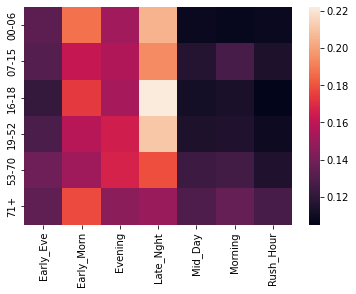


Rate Normalized by Column
       Early_Eve  Early_Morn  Evening  Late_Nght  Mid_Day  Morning  Rush_Hour  \
00-06      0.138       0.152    0.133      0.146    0.125    0.119      0.129   
07-15      0.167       0.162    0.167      0.170    0.164    0.175      0.168   
16-18      0.139       0.156    0.147      0.175    0.142    0.139      0.138   
19-52      0.159       0.152    0.172      0.179    0.157    0.154      0.155   
53-70      0.190       0.162    0.193      0.170    0.190    0.186      0.183   
71+        0.208       0.216    0.189      0.159    0.222    0.226      0.226   
Total      1.001       1.000    1.001      0.999    1.000    0.999      0.999   

       Total  
00-06  0.942  
07-15  1.173  
16-18  1.036  
19-52  1.128  
53-70  1.274  
71+    1.446  
Total  6.999  

AGE_IM HOUR_IM


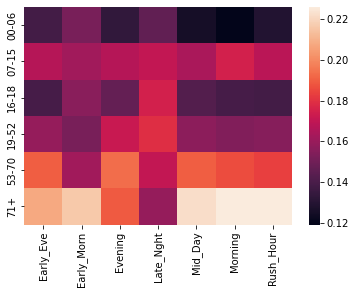


AGE_IM INT_HWY
['71+', '19-52', '16-18', '53-70', '00-06', '07-15']
[0, 1]

Count Crashes
            0      1   Total
00-06   22661   2309   24970
07-15   30298   3051   33349
16-18   38902   2878   41780
19-52  352813  42646  395459
53-70  103990  10988  114978
71+     31477   2261   33738
Total  580141  64133  644274

Hospitalization Count
           0     1   Total
00-06   2674   334    3008
07-15   4848   460    5308
16-18   5467   431    5898
19-52  55854  6503   62357
53-70  18625  1624   20249
71+     6376   414    6790
Total  93844  9766  103610

Hospitalization Rate
           0      1  Total
00-06  0.118  0.145  0.263
07-15  0.160  0.151  0.311
16-18  0.141  0.150  0.291
19-52  0.158  0.152  0.310
53-70  0.179  0.148  0.327
71+    0.203  0.183  0.386
Total  0.959  0.929  1.888

Rate Normalized by Row
           0      1  Total
00-06  0.449  0.551    1.0
07-15  0.515  0.485    1.0
16-18  0.484  0.516    1.0
19-52  0.509  0.491    1.0
53-70  0.548  0.452    1.0
71+    0.525  

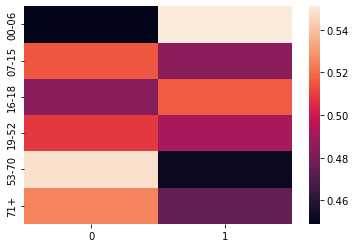


Rate Normalized by Column
           0      1  Total
00-06  0.123  0.156  0.279
07-15  0.167  0.162  0.329
16-18  0.147  0.161  0.308
19-52  0.165  0.164  0.329
53-70  0.187  0.159  0.346
71+    0.211  0.197  0.408
Total  1.000  0.999  1.999

AGE_IM INT_HWY


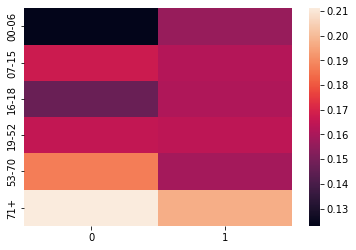


AGE_IM LGTCON_IM
['71+', '19-52', '16-18', '53-70', '00-06', '07-15']
['Daylight', 'Dawn_Lighted', 'Dusk', 'Dark']

Count Crashes
        Dark  Dawn_Lighted  Daylight   Dusk   Total
00-06   1545          3280     19532    613   24970
07-15   2435          5254     24666    994   33349
16-18   4075          8059     28504   1142   41780
19-52  35635         78602    271680   9542  395459
53-70   8164         17138     87078   2598  114978
71+     1667          3460     27939    672   33738
Total  53521        115793    459399  15561  644274

Hospitalization Count
        Dark  Dawn_Lighted  Daylight  Dusk   Total
00-06    285           453      2187    83    3008
07-15    517           921      3688   182    5308
16-18    926          1237      3568   167    5898
19-52   8294         14608     37896  1559   62357
53-70   1858          3401     14536   454   20249
71+      424           715      5511   140    6790
Total  12304         21335     67386  2585  103610

Hospitalization Rate


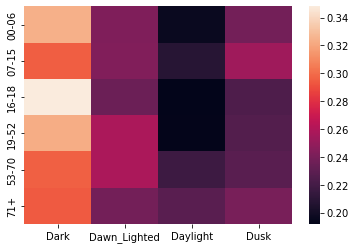


Rate Normalized by Column
        Dark  Dawn_Lighted  Daylight   Dusk  Total
00-06  0.138         0.131     0.126  0.134  0.529
07-15  0.159         0.166     0.168  0.181  0.674
16-18  0.170         0.145     0.141  0.145  0.601
19-52  0.174         0.176     0.157  0.162  0.669
53-70  0.170         0.188     0.187  0.173  0.718
71+    0.190         0.195     0.222  0.206  0.813
Total  1.001         1.001     1.001  1.001  4.004

AGE_IM LGTCON_IM


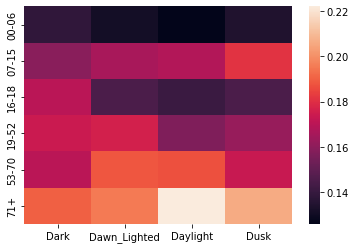


AGE_IM MONTH
['71+', '19-52', '16-18', '53-70', '00-06', '07-15']
['Winter', 'Spring_Fall', 'Summer']

Count Crashes
       Spring_Fall  Summer  Winter   Total
00-06         8546    8997    7427   24970
07-15        10976   12352   10021   33349
16-18        14203   14672   12905   41780
19-52       133284  137988  124187  395459
53-70        38456   40064   36458  114978
71+          11359   11649   10730   33738
Total       216824  225722  201728  644274

Hospitalization Count
       Spring_Fall  Summer  Winter   Total
00-06         1033    1130     845    3008
07-15         1767    2079    1462    5308
16-18         1966    2235    1697    5898
19-52        20948   22994   18415   62357
53-70         6597    7565    6087   20249
71+           2276    2400    2114    6790
Total        34587   38403   30620  103610

Hospitalization Rate
       Spring_Fall  Summer  Winter  Total
00-06        0.121   0.126   0.114  0.361
07-15        0.161   0.168   0.146  0.475
16-18        0.138   0.

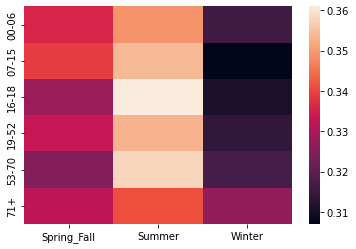


Rate Normalized by Column
       Spring_Fall  Summer  Winter  Total
00-06        0.127   0.125   0.126  0.378
07-15        0.170   0.167   0.161  0.498
16-18        0.146   0.151   0.146  0.443
19-52        0.166   0.165   0.164  0.495
53-70        0.181   0.187   0.185  0.553
71+          0.211   0.204   0.218  0.633
Total        1.001   0.999   1.000  3.000

AGE_IM MONTH


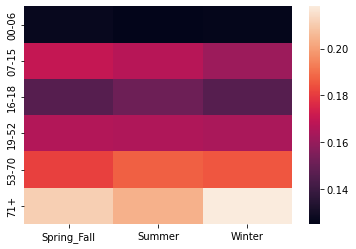


AGE_IM PEDS
['71+', '19-52', '16-18', '53-70', '00-06', '07-15']
['0', '1', 'Multiple']

Count Crashes
            0      1  Multiple   Total
00-06   23606   1168       196   24970
07-15   29821   3295       233   33349
16-18   39067   2555       158   41780
19-52  365890  28208      1361  395459
53-70  104232  10380       366  114978
71+     30686   2934       118   33738
Total  593302  48540      2432  644274

Hospitalization Count
           0      1  Multiple   Total
00-06   2610    304        94    3008
07-15   3900   1292       116    5308
16-18   5093    739        66    5898
19-52  54502   7347       508   62357
53-70  16897   3222       130   20249
71+     5901    835        54    6790
Total  88903  13739       968  103610

Hospitalization Rate
           0      1  Multiple  Total
00-06  0.111  0.260     0.480  0.851
07-15  0.131  0.392     0.498  1.021
16-18  0.130  0.289     0.418  0.837
19-52  0.149  0.260     0.373  0.782
53-70  0.162  0.310     0.355  0.827
71+    0.192 

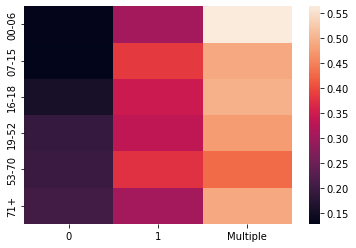


Rate Normalized by Column
           0      1  Multiple  Total
00-06  0.126  0.145     0.186  0.457
07-15  0.149  0.218     0.193  0.560
16-18  0.149  0.161     0.162  0.472
19-52  0.170  0.145     0.145  0.460
53-70  0.185  0.173     0.138  0.496
71+    0.220  0.158     0.177  0.555
Total  0.999  1.000     1.001  3.000

AGE_IM PEDS


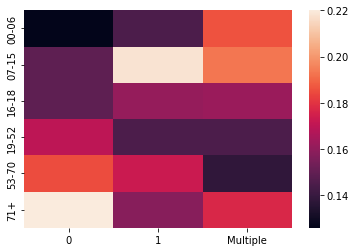


AGE_IM PERMVIT
['71+', '19-52', '16-18', '53-70', '00-06', '07-15']
['2', 'Multiple', '1']

Count Crashes
           1       2  Multiple   Total
00-06    513     820     23637   24970
07-15   2485    1879     28985   33349
16-18   5100   10867     25813   41780
19-52  58769  135680    201010  395459
53-70  18545   42672     53761  114978
71+     4812   11829     17097   33738
Total  90224  203747    350303  644274

Hospitalization Count
           1      2  Multiple   Total
00-06    303    179      2526    3008
07-15   1137    442      3729    5308
16-18   1325   1271      3302    5898
19-52  16258  17700     28399   62357
53-70   5577   5841      8831   20249
71+     1498   1916      3376    6790
Total  26098  27349     50163  103610

Hospitalization Rate
           1      2  Multiple  Total
00-06  0.591  0.218     0.107  0.916
07-15  0.458  0.235     0.129  0.822
16-18  0.260  0.117     0.128  0.505
19-52  0.277  0.130     0.141  0.548
53-70  0.301  0.137     0.164  0.602
71+    0.3

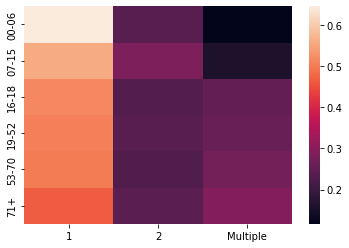


Rate Normalized by Column
           1      2  Multiple  Total
00-06  0.269  0.218     0.123  0.610
07-15  0.208  0.235     0.148  0.591
16-18  0.118  0.117     0.148  0.383
19-52  0.126  0.130     0.163  0.419
53-70  0.137  0.137     0.190  0.464
71+    0.142  0.162     0.228  0.532
Total  1.000  0.999     1.000  2.999

AGE_IM PERMVIT


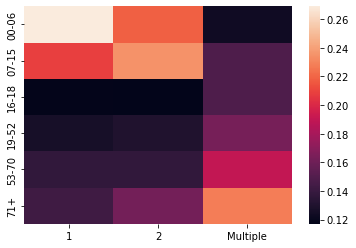


AGE_IM REL_ROAD
['71+', '19-52', '16-18', '53-70', '00-06', '07-15']
['On_Road', 'Not_on_Road', 'Parking_Area']

Count Crashes
       Not_on_Road  On_Road  Parking_Area   Total
00-06         1693    23084           193   24970
07-15         2497    30555           297   33349
16-18         5844    35321           615   41780
19-52        41778   347017          6664  395459
53-70         8578   104624          1776  114978
71+           2510    30684           544   33738
Total        62900   571285         10089  644274

Hospitalization Count
       Not_on_Road  On_Road  Parking_Area   Total
00-06          503     2485            20    3008
07-15          812     4465            31    5308
16-18         1701     4155            42    5898
19-52        13836    47838           683   62357
53-70         3204    16848           197   20249
71+           1084     5628            78    6790
Total        21140    81419          1051  103610

Hospitalization Rate
       Not_on_Road  On_Road

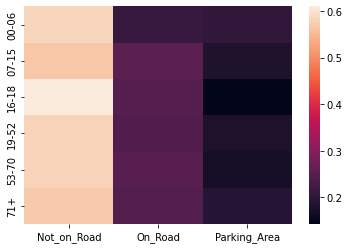


Rate Normalized by Column
       Not_on_Road  On_Road  Parking_Area  Total
00-06        0.145    0.126         0.164  0.435
07-15        0.159    0.171         0.165  0.495
16-18        0.142    0.138         0.108  0.388
19-52        0.162    0.161         0.162  0.485
53-70        0.182    0.189         0.175  0.546
71+          0.211    0.215         0.226  0.652
Total        1.001    1.000         1.000  3.001

AGE_IM REL_ROAD


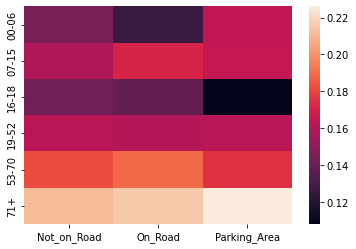


AGE_IM RELJCT2_IM
['71+', '19-52', '16-18', '53-70', '00-06', '07-15']
['B', 'A', 'C', 'D']

Count Crashes
            A       B      C       D   Total
00-06    7290    8942   2474    6264   24970
07-15    9590   11918   3355    8486   33349
16-18   11966   15795   3954   10065   41780
19-52  102586  158372  36234   98267  395459
53-70   30692   43240  11063   29983  114978
71+     11000   10773   3861    8104   33738
Total  173124  249040  60941  161169  644274

Hospitalization Count
           A      B     C      D   Total
00-06   1074   1246   241    447    3008
07-15   1730   2068   458   1052    5308
16-18   1841   2667   436    954    5898
19-52  19339  27286  4881  10851   62357
53-70   6507   7877  1776   4089   20249
71+     2668   2240   630   1252    6790
Total  33159  43384  8422  18645  103610

Hospitalization Rate
           A      B      C      D  Total
00-06  0.147  0.139  0.097  0.071  0.454
07-15  0.180  0.174  0.137  0.124  0.615
16-18  0.154  0.169  0.110  0.095  0

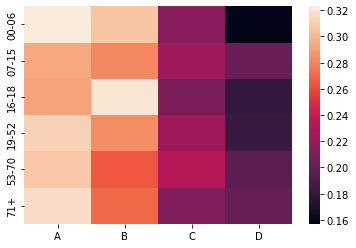


Rate Normalized by Column
           A      B      C      D  Total
00-06  0.131  0.133  0.121  0.103  0.488
07-15  0.160  0.166  0.170  0.179  0.675
16-18  0.137  0.162  0.137  0.137  0.573
19-52  0.168  0.165  0.168  0.160  0.661
53-70  0.189  0.174  0.200  0.197  0.760
71+    0.216  0.199  0.203  0.223  0.841
Total  1.001  0.999  0.999  0.999  3.998

AGE_IM RELJCT2_IM


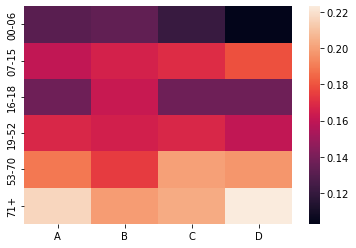


AGE_IM SCH_BUS
['71+', '19-52', '16-18', '53-70', '00-06', '07-15']
['0', '1']

Count Crashes
            0     1   Total
00-06   24857   113   24970
07-15   33108   241   33349
16-18   41547   233   41780
19-52  393828  1631  395459
53-70  114125   853  114978
71+     33555   183   33738
Total  641020  3254  644274

Hospitalization Count
            0    1   Total
00-06    2990   18    3008
07-15    5232   76    5308
16-18    5848   50    5898
19-52   62190  167   62357
53-70   20175   74   20249
71+      6774   16    6790
Total  103209  401  103610

Hospitalization Rate
           0      1  Total
00-06  0.120  0.159  0.279
07-15  0.158  0.315  0.473
16-18  0.141  0.215  0.356
19-52  0.158  0.102  0.260
53-70  0.177  0.087  0.264
71+    0.202  0.087  0.289
Total  0.956  0.965  1.921

Rate Normalized by Row
           0      1  Total
00-06  0.430  0.570    1.0
07-15  0.334  0.666    1.0
16-18  0.396  0.604    1.0
19-52  0.607  0.393    1.0
53-70  0.671  0.329    1.0
71+    0.698  0.30

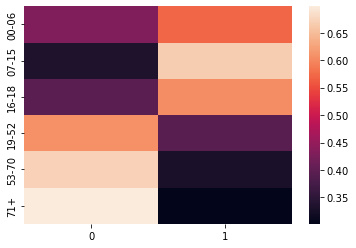


Rate Normalized by Column
           0      1  Total
00-06  0.126  0.165  0.291
07-15  0.165  0.327  0.492
16-18  0.147  0.222  0.369
19-52  0.165  0.106  0.271
53-70  0.185  0.090  0.275
71+    0.211  0.091  0.302
Total  0.999  1.001  2.000

AGE_IM SCH_BUS


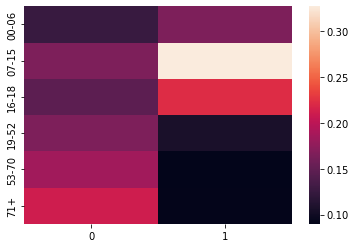


AGE_IM URBANICITY
['71+', '19-52', '16-18', '53-70', '00-06', '07-15']
['2', '1']

Count Crashes
            1       2   Total
00-06   19053    5917   24970
07-15   25544    7805   33349
16-18   30920   10860   41780
19-52  313606   81853  395459
53-70   89494   25484  114978
71+     25156    8582   33738
Total  503773  140501  644274

Hospitalization Count
           1      2   Total
00-06   2254    754    3008
07-15   4028   1280    5308
16-18   4220   1678    5898
19-52  48776  13581   62357
53-70  15515   4734   20249
71+     4978   1812    6790
Total  79771  23839  103610

Hospitalization Rate
           1      2  Total
00-06  0.118  0.127  0.245
07-15  0.158  0.164  0.322
16-18  0.136  0.155  0.291
19-52  0.156  0.166  0.322
53-70  0.173  0.186  0.359
71+    0.198  0.211  0.409
Total  0.939  1.009  1.948

Rate Normalized by Row
           1      2  Total
00-06  0.481  0.519    1.0
07-15  0.490  0.510    1.0
16-18  0.469  0.531    1.0
19-52  0.484  0.516    1.0
53-70  0.483  0.51

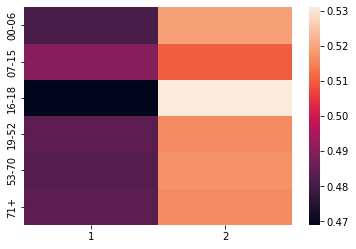


Rate Normalized by Column
           1      2  Total
00-06  0.126  0.126  0.252
07-15  0.168  0.163  0.331
16-18  0.145  0.153  0.298
19-52  0.166  0.164  0.330
53-70  0.185  0.184  0.369
71+    0.211  0.209  0.420
Total  1.001  0.999  2.000

AGE_IM URBANICITY


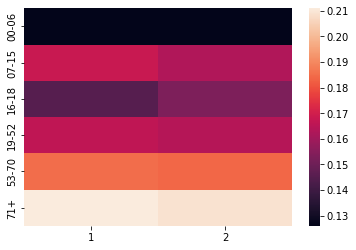


AGE_IM VE_TOTAL
['71+', '19-52', '16-18', '53-70', '00-06', '07-15']
['2', '1', 'Multiple', '3']

Count Crashes
            1       2      3  Multiple   Total
00-06    3049   17918   2993      1010   24970
07-15    5936   22437   3696      1280   33349
16-18    8536   27898   4051      1295   41780
19-52   73495  264146  43144     14674  395459
53-70   21086   77716  12076      4100  114978
71+      5603   23891   3253       991   33738
Total  117705  434006  69213     23350  644274

Hospitalization Count
           1      2      3  Multiple   Total
00-06    822   1673    371       142    3008
07-15   2102   2538    503       165    5308
16-18   2445   2770    504       179    5898
19-52  21297  32143   6445      2472   62357
53-70   6620  10687   2134       808   20249
71+     1850   3937    752       251    6790
Total  35136  53748  10709      4017  103610

Hospitalization Rate
           1      2      3  Multiple  Total
00-06  0.270  0.093  0.124     0.141  0.628
07-15  0.354  0.11

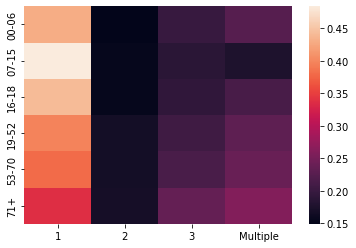


Rate Normalized by Column
           1      2      3  Multiple  Total
00-06  0.146  0.128  0.132     0.137  0.543
07-15  0.192  0.155  0.145     0.126  0.618
16-18  0.155  0.136  0.132     0.135  0.558
19-52  0.157  0.167  0.159     0.164  0.647
53-70  0.170  0.188  0.188     0.192  0.738
71+    0.179  0.226  0.245     0.247  0.897
Total  0.999  1.000  1.001     1.001  4.001

AGE_IM VE_TOTAL


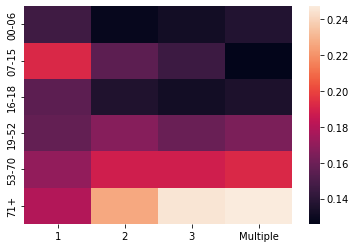


AGE_IM WEATHR_IM
['71+', '19-52', '16-18', '53-70', '00-06', '07-15']
['B', 'A', 'D', 'C', 'E']

Count Crashes
          A       B      C      D      E   Total
00-06    87   18444   2162   3962    315   24970
07-15   161   24948   2908   4874    458   33349
16-18   187   29983   4413   6339    858   41780
19-52  1994  289158  37905  59196   7206  395459
53-70   529   84728   9966  17807   1948  114978
71+     105   25307   2551   5273    502   33738
Total  3063  472568  59905  97451  11287  644274

Hospitalization Count
         A      B     C      D     E   Total
00-06   13   2204   288    467    36    3008
07-15   44   3947   489    755    73    5308
16-18   27   4312   607    850   102    5898
19-52  426  45997  5946   9164   824   62357
53-70  105  15117  1727   3034   266   20249
71+     21   5095   516   1044   114    6790
Total  636  76672  9573  15314  1415  103610

Hospitalization Rate
           A      B      C      D      E  Total
00-06  0.149  0.119  0.133  0.118  0.114  0

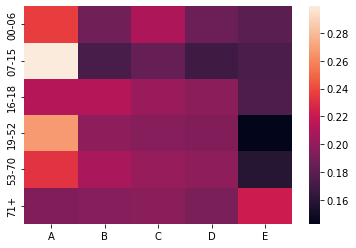


Rate Normalized by Column
           A      B      C      D      E  Total
00-06  0.127  0.124  0.137  0.127  0.131  0.646
07-15  0.232  0.165  0.173  0.167  0.183  0.920
16-18  0.122  0.150  0.142  0.144  0.137  0.695
19-52  0.181  0.166  0.161  0.166  0.131  0.805
53-70  0.168  0.186  0.178  0.183  0.157  0.872
71+    0.170  0.210  0.208  0.213  0.261  1.062
Total  1.000  1.001  0.999  1.000  1.000  5.000

AGE_IM WEATHR_IM


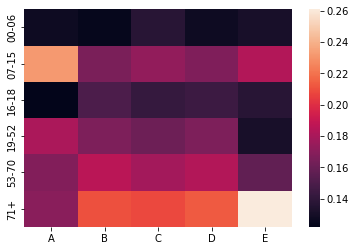


AGE_IM WKDY_IM
['71+', '19-52', '16-18', '53-70', '00-06', '07-15']
['Weekday', 'Weekend']

Count Crashes
       Weekday  Weekend   Total
00-06    18283     6687   24970
07-15    23408     9941   33349
16-18    30929    10851   41780
19-52   296788    98671  395459
53-70    88826    26152  114978
71+      26323     7415   33738
Total   484557   159717  644274

Hospitalization Count
       Weekday  Weekend   Total
00-06     2131      877    3008
07-15     3777     1531    5308
16-18     4203     1695    5898
19-52    44227    18130   62357
53-70    15043     5206   20249
71+       5203     1587    6790
Total    74584    29026  103610

Hospitalization Rate
       Weekday  Weekend  Total
00-06    0.117    0.131  0.248
07-15    0.161    0.154  0.315
16-18    0.136    0.156  0.292
19-52    0.149    0.184  0.333
53-70    0.169    0.199  0.368
71+      0.198    0.214  0.412
Total    0.930    1.038  1.968

Rate Normalized by Row
       Weekday  Weekend  Total
00-06    0.471    0.529    1.0
07

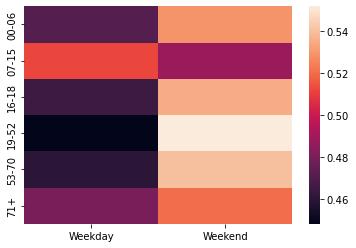


Rate Normalized by Column
       Weekday  Weekend  Total
00-06    0.125    0.126  0.251
07-15    0.174    0.148  0.322
16-18    0.146    0.150  0.296
19-52    0.160    0.177  0.337
53-70    0.182    0.192  0.374
71+      0.213    0.206  0.419
Total    1.000    0.999  1.999

AGE_IM WKDY_IM


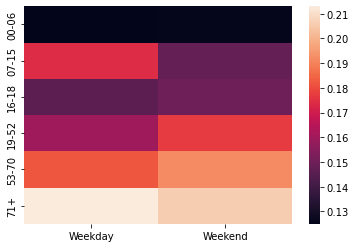


AGE_IM WRK_ZONE
['71+', '19-52', '16-18', '53-70', '00-06', '07-15']
['0', '1', '2', '3']

Count Crashes
            0      1    2    3   Total
00-06   24475    461   28    6   24970
07-15   32786    530   31    2   33349
16-18   41137    584   44   15   41780
19-52  387616   7252  481  110  395459
53-70  112661   2112  169   36  114978
71+     33103    586   38   11   33738
Total  631778  11525  791  180  644274

Hospitalization Count
            0     1    2   3   Total
00-06    2964    39    4   1    3008
07-15    5247    57    2   2    5308
16-18    5841    53    1   3    5898
19-52   61366   891   78  22   62357
53-70   19957   265   23   4   20249
71+      6658   120    7   5    6790
Total  102033  1425  115  37  103610

Hospitalization Rate
           0      1      2      3  Total
00-06  0.121  0.085  0.143  0.167  0.516
07-15  0.160  0.108  0.065  1.000  1.333
16-18  0.142  0.091  0.023  0.200  0.456
19-52  0.158  0.123  0.162  0.200  0.643
53-70  0.177  0.125  0.136  0.111  0

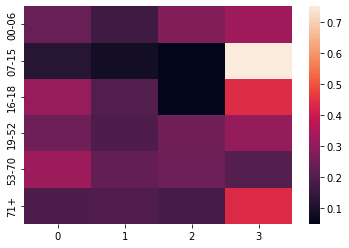


Rate Normalized by Column
           0      1      2      3  Total
00-06  0.126  0.115  0.200  0.078  0.519
07-15  0.167  0.146  0.091  0.469  0.873
16-18  0.148  0.123  0.032  0.094  0.397
19-52  0.165  0.167  0.228  0.094  0.654
53-70  0.185  0.170  0.191  0.052  0.598
71+    0.210  0.278  0.259  0.213  0.960
Total  1.001  0.999  1.001  1.000  4.001

AGE_IM WRK_ZONE


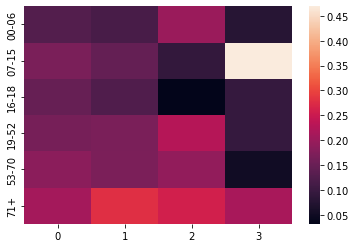


SEX_IM PER_TYP
['Male', 'Female']
['In_VIT', 'Not_in_Vehicle', 'In_VNIT']

Count Crashes
        In_VIT  In_VNIT  Not_in_Vehicle   Total
Female  281869      816            7677  290362
Male    337158     1379           15375  353912
Total   619027     2195           23052  644274

Hospitalization Count
        In_VIT  In_VNIT  Not_in_Vehicle   Total
Female   43563       81            4881   48525
Male     45624      117            9344   55085
Total    89187      198           14225  103610

Hospitalization Rate
        In_VIT  In_VNIT  Not_in_Vehicle  Total
Female   0.155    0.099           0.636  0.890
Male     0.135    0.085           0.608  0.828
Total    0.290    0.184           1.244  1.718

Rate Normalized by Row
        In_VIT  In_VNIT  Not_in_Vehicle  Total
Female   0.174    0.112           0.715  1.001
Male     0.163    0.102           0.734  0.999
Total    0.337    0.214           1.449  2.000

SEX_IM PER_TYP


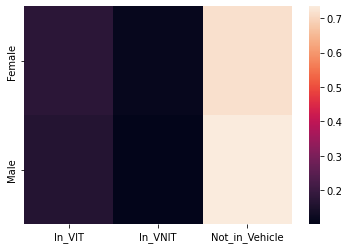


Rate Normalized by Column
        In_VIT  In_VNIT  Not_in_Vehicle  Total
Female   0.533    0.539           0.511  1.583
Male     0.467    0.461           0.489  1.417
Total    1.000    1.000           1.000  3.000

SEX_IM PER_TYP


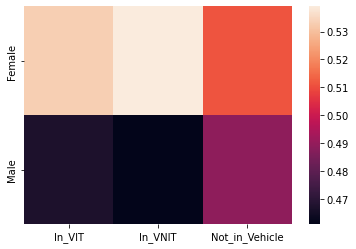


SEX_IM BODY_TYP
['Male', 'Female']
['Car', 'SUV', 'Light_Truck', 'Heavy_Truck', 'Motorcycle']

Count Crashes
           Car  Heavy_Truck  Light_Truck  Motorcycle     SUV   Total
Female  125971        12854        47566        2198  101773  290362
Male    122602        42932        89702       14480   84196  353912
Total   248573        55786       137268       16678  185969  644274

Hospitalization Count
          Car  Heavy_Truck  Light_Truck  Motorcycle    SUV   Total
Female  21110         5034         6245        1430  14706   48525
Male    16876        10226         9015        8728  10240   55085
Total   37986        15260        15260       10158  24946  103610

Hospitalization Rate
          Car  Heavy_Truck  Light_Truck  Motorcycle    SUV  Total
Female  0.168        0.392        0.131       0.651  0.144  1.486
Male    0.138        0.238        0.100       0.603  0.122  1.201
Total   0.306        0.630        0.231       1.254  0.266  2.687

Rate Normalized by Row
          Car

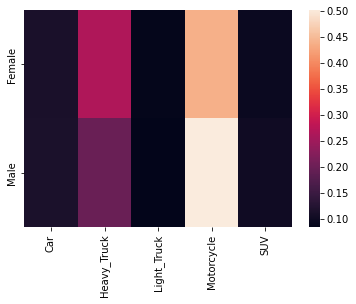


Rate Normalized by Column
          Car  Heavy_Truck  Light_Truck  Motorcycle    SUV  Total
Female  0.549        0.622        0.566       0.519  0.543  2.799
Male    0.451        0.378        0.434       0.481  0.457  2.201
Total   1.000        1.000        1.000       1.000  1.000  5.000

SEX_IM BODY_TYP


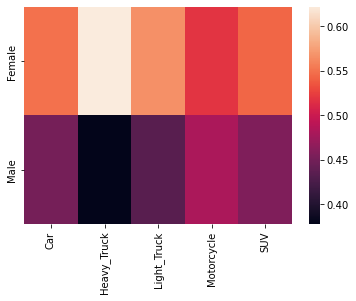


SEX_IM MAKE
['Male', 'Female']
['B', 'E', 'G', 'F', 'I', 'D', 'A', 'C', 'H']

Count Crashes
            A      B       C      D      E       F      G      H      I  \
Female   1992  44507   59022  38186  40748   51284  31747   8479  14397   
Male    10365  44671   47742  51047  39846   69736  43121  10215  37169   
Total   12357  89178  106764  89233  80594  121020  74868  18694  51566   

         Total  
Female  290362  
Male    353912  
Total   644274  

Hospitalization Count
           A      B      C      D      E      F     G     H      I   Total
Female  1040   7326   9690   6184   6080   7655  4541   970   5039   48525
Male    6122   7557   6501   6474   4668   8113  4609   877  10164   55085
Total   7162  14883  16191  12658  10748  15768  9150  1847  15203  103610

Hospitalization Rate
            A      B      C      D      E      F      G      H      I  Total
Female  0.522  0.165  0.164  0.162  0.149  0.149  0.143  0.114  0.350  1.918
Male    0.591  0.169  0.136  0.127  0.1

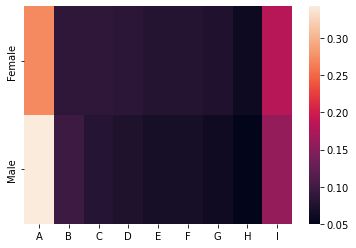


Rate Normalized by Column
            A      B      C      D     E      F      G      H      I  Total
Female  0.469  0.493  0.547  0.561  0.56  0.562  0.572  0.571  0.561  4.896
Male    0.531  0.507  0.453  0.439  0.44  0.438  0.428  0.429  0.439  4.104
Total   1.000  1.000  1.000  1.000  1.00  1.000  1.000  1.000  1.000  9.000

SEX_IM MAKE


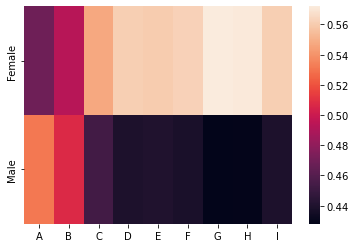


SEX_IM HOUR_IM
['Male', 'Female']
['Mid_Day', 'Early_Eve', 'Early_Morn', 'Evening', 'Morning', 'Rush_Hour', 'Late_Nght']

Count Crashes
        Early_Eve  Early_Morn  Evening  Late_Nght  Mid_Day  Morning  \
Female      35102        8399    26838      15307    73057    51530   
Male        42432       15295    35977      27657    83094    59424   
Total       77534       23694    62815      42964   156151   110954   

        Rush_Hour   Total  
Female      80129  290362  
Male        90033  353912  
Total      170162  644274  

Hospitalization Count
        Early_Eve  Early_Morn  Evening  Late_Nght  Mid_Day  Morning  \
Female       5719        1902     5398       3896    11638     8466   
Male         6781        2749     7225       6942    11368     8011   
Total       12500        4651    12623      10838    23006    16477   

        Rush_Hour   Total  
Female      11506   48525  
Male        12009   55085  
Total       23515  103610  

Hospitalization Rate
        Early_Eve  Early

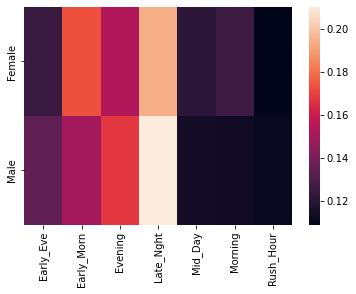


Rate Normalized by Column
        Early_Eve  Early_Morn  Evening  Late_Nght  Mid_Day  Morning  \
Female      0.505       0.558      0.5      0.503    0.538    0.549   
Male        0.495       0.442      0.5      0.497    0.462    0.451   
Total       1.000       1.000      1.0      1.000    1.000    1.000   

        Rush_Hour  Total  
Female      0.518  3.671  
Male        0.482  3.329  
Total       1.000  7.000  

SEX_IM HOUR_IM


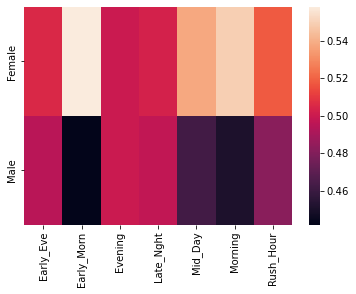


SEX_IM INT_HWY
['Male', 'Female']
[0, 1]

Count Crashes
             0      1   Total
Female  264348  26014  290362
Male    315793  38119  353912
Total   580141  64133  644274

Hospitalization Count
            0     1   Total
Female  44060  4465   48525
Male    49784  5301   55085
Total   93844  9766  103610

Hospitalization Rate
            0      1  Total
Female  0.167  0.172  0.339
Male    0.158  0.139  0.297
Total   0.325  0.311  0.636

Rate Normalized by Row
            0      1  Total
Female  0.493  0.507    1.0
Male    0.531  0.469    1.0
Total   1.024  0.976    2.0

SEX_IM INT_HWY


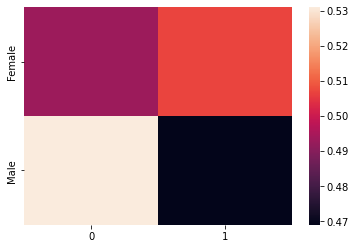


Rate Normalized by Column
            0      1  Total
Female  0.514  0.552  1.066
Male    0.486  0.448  0.934
Total   1.000  1.000  2.000

SEX_IM INT_HWY


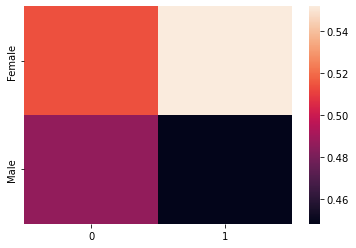


SEX_IM LGTCON_IM
['Male', 'Female']
['Daylight', 'Dawn_Lighted', 'Dusk', 'Dark']

Count Crashes
         Dark  Dawn_Lighted  Daylight   Dusk   Total
Female  21063         48603    213631   7065  290362
Male    32458         67190    245768   8496  353912
Total   53521        115793    459399  15561  644274

Hospitalization Count
         Dark  Dawn_Lighted  Daylight  Dusk   Total
Female   4953          9039     33336  1197   48525
Male     7351         12296     34050  1388   55085
Total   12304         21335     67386  2585  103610

Hospitalization Rate
         Dark  Dawn_Lighted  Daylight   Dusk  Total
Female  0.235         0.186     0.156  0.169  0.746
Male    0.226         0.183     0.139  0.163  0.711
Total   0.461         0.369     0.295  0.332  1.457

Rate Normalized by Row
         Dark  Dawn_Lighted  Daylight   Dusk  Total
Female  0.315         0.249     0.209  0.227    1.0
Male    0.318         0.257     0.195  0.230    1.0
Total   0.633         0.506     0.404  0.457    2.

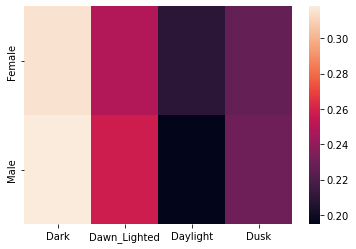


Rate Normalized by Column
         Dark  Dawn_Lighted  Daylight   Dusk  Total
Female  0.509         0.504      0.53  0.509  2.052
Male    0.491         0.496      0.47  0.491  1.948
Total   1.000         1.000      1.00  1.000  4.000

SEX_IM LGTCON_IM


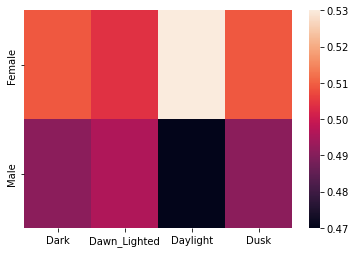


SEX_IM MONTH
['Male', 'Female']
['Winter', 'Spring_Fall', 'Summer']

Count Crashes
        Spring_Fall  Summer  Winter   Total
Female        98154  100623   91585  290362
Male         118670  125099  110143  353912
Total        216824  225722  201728  644274

Hospitalization Count
        Spring_Fall  Summer  Winter   Total
Female        16435   17239   14851   48525
Male          18152   21164   15769   55085
Total         34587   38403   30620  103610

Hospitalization Rate
        Spring_Fall  Summer  Winter  Total
Female        0.167   0.171   0.162  0.500
Male          0.153   0.169   0.143  0.465
Total         0.320   0.340   0.305  0.965

Rate Normalized by Row
        Spring_Fall  Summer  Winter  Total
Female        0.334   0.342   0.324  1.000
Male          0.329   0.364   0.308  1.001
Total         0.663   0.706   0.632  2.001

SEX_IM MONTH


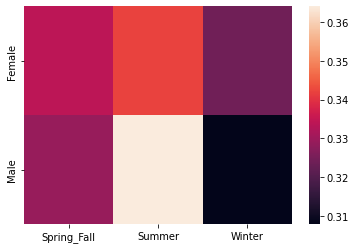


Rate Normalized by Column
        Spring_Fall  Summer  Winter  Total
Female        0.523   0.503   0.531  1.557
Male          0.477   0.497   0.469  1.443
Total         1.000   1.000   1.000  3.000

SEX_IM MONTH


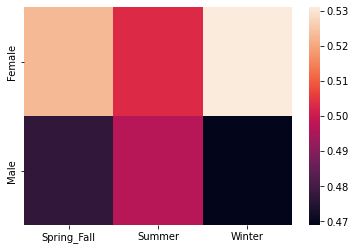


SEX_IM PEDS
['Male', 'Female']
['0', '1', 'Multiple']

Count Crashes
             0      1  Multiple   Total
Female  270796  18437      1129  290362
Male    322506  30103      1303  353912
Total   593302  48540      2432  644274

Hospitalization Count
            0      1  Multiple   Total
Female  43434   4571       520   48525
Male    45469   9168       448   55085
Total   88903  13739       968  103610

Hospitalization Rate
            0      1  Multiple  Total
Female  0.160  0.248     0.461  0.869
Male    0.141  0.305     0.344  0.790
Total   0.301  0.553     0.805  1.659

Rate Normalized by Row
            0      1  Multiple  Total
Female  0.185  0.285     0.530  1.000
Male    0.179  0.386     0.436  1.001
Total   0.364  0.671     0.966  2.001

SEX_IM PEDS


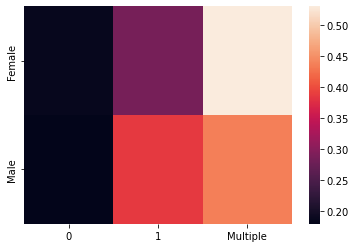


Rate Normalized by Column
            0      1  Multiple  Total
Female  0.532  0.449     0.573  1.554
Male    0.468  0.551     0.427  1.446
Total   1.000  1.000     1.000  3.000

SEX_IM PEDS


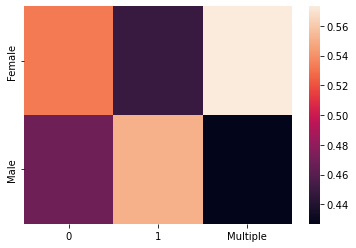


SEX_IM PERMVIT
['Male', 'Female']
['2', 'Multiple', '1']

Count Crashes
            1       2  Multiple   Total
Female  31152   87264    171946  290362
Male    59072  116483    178357  353912
Total   90224  203747    350303  644274

Hospitalization Count
            1      2  Multiple   Total
Female   8389  12535     27601   48525
Male    17709  14814     22562   55085
Total   26098  27349     50163  103610

Hospitalization Rate
            1      2  Multiple  Total
Female  0.269  0.144     0.161  0.574
Male    0.300  0.127     0.126  0.553
Total   0.569  0.271     0.287  1.127

Rate Normalized by Row
            1     2  Multiple  Total
Female  0.470  0.25     0.280  1.000
Male    0.542  0.23     0.229  1.001
Total   1.012  0.48     0.509  2.001

SEX_IM PERMVIT


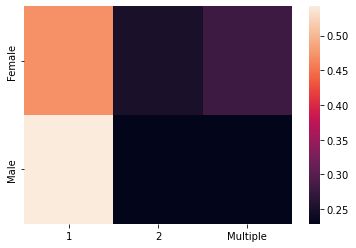


Rate Normalized by Column
            1     2  Multiple  Total
Female  0.473  0.53     0.559  1.562
Male    0.527  0.47     0.441  1.438
Total   1.000  1.00     1.000  3.000

SEX_IM PERMVIT


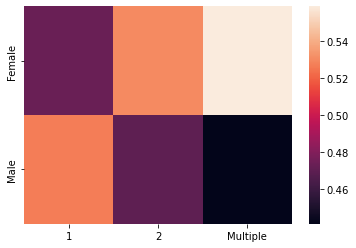


SEX_IM REL_ROAD
['Male', 'Female']
['On_Road', 'Not_on_Road', 'Parking_Area']

Count Crashes
        Not_on_Road  On_Road  Parking_Area   Total
Female        23305   262977          4080  290362
Male          39595   308308          6009  353912
Total         62900   571285         10089  644274

Hospitalization Count
        Not_on_Road  On_Road  Parking_Area   Total
Female         8149    39952           424   48525
Male          12991    41467           627   55085
Total         21140    81419          1051  103610

Hospitalization Rate
        Not_on_Road  On_Road  Parking_Area  Total
Female        0.350    0.152         0.104  0.606
Male          0.328    0.134         0.104  0.566
Total         0.678    0.286         0.208  1.172

Rate Normalized by Row
        Not_on_Road  On_Road  Parking_Area  Total
Female        0.577    0.251         0.172    1.0
Male          0.579    0.237         0.184    1.0
Total         1.156    0.488         0.356    2.0

SEX_IM REL_ROAD


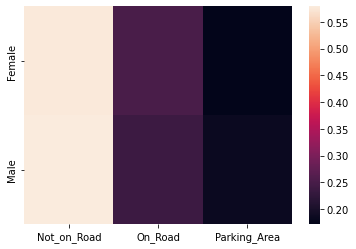


Rate Normalized by Column
        Not_on_Road  On_Road  Parking_Area  Total
Female        0.516     0.53         0.499  1.545
Male          0.484     0.47         0.501  1.455
Total         1.000     1.00         1.000  3.000

SEX_IM REL_ROAD


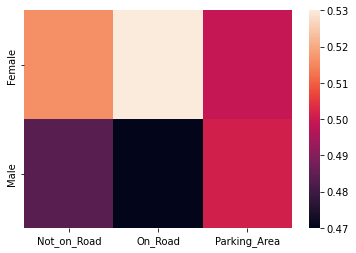


SEX_IM RELJCT2_IM
['Male', 'Female']
['B', 'A', 'C', 'D']

Count Crashes
             A       B      C       D   Total
Female   81764  105596  28062   74940  290362
Male     91360  143444  32879   86229  353912
Total   173124  249040  60941  161169  644274

Hospitalization Count
            A      B     C      D   Total
Female  17203  18390  4068   8864   48525
Male    15956  24994  4354   9781   55085
Total   33159  43384  8422  18645  103610

Hospitalization Rate
            A      B      C      D  Total
Female  0.210  0.174  0.145  0.118  0.647
Male    0.175  0.174  0.132  0.113  0.594
Total   0.385  0.348  0.277  0.231  1.241

Rate Normalized by Row
            A      B      C      D  Total
Female  0.325  0.269  0.224  0.183  1.001
Male    0.294  0.293  0.223  0.191  1.001
Total   0.619  0.562  0.447  0.374  2.002

SEX_IM RELJCT2_IM


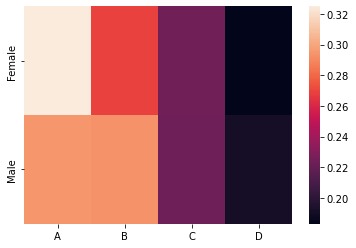


Rate Normalized by Column
            A    B      C     D  Total
Female  0.546  0.5  0.523  0.51  2.079
Male    0.454  0.5  0.477  0.49  1.921
Total   1.000  1.0  1.000  1.00  4.000

SEX_IM RELJCT2_IM


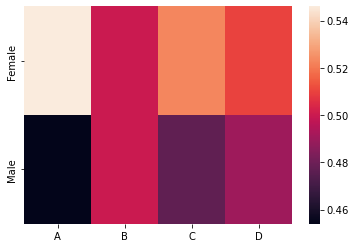


SEX_IM SCH_BUS
['Male', 'Female']
['0', '1']

Count Crashes
             0     1   Total
Female  288731  1631  290362
Male    352289  1623  353912
Total   641020  3254  644274

Hospitalization Count
             0    1   Total
Female   48310  215   48525
Male     54899  186   55085
Total   103209  401  103610

Hospitalization Rate
            0      1  Total
Female  0.167  0.132  0.299
Male    0.156  0.115  0.271
Total   0.323  0.247  0.570

Rate Normalized by Row
            0      1  Total
Female  0.559  0.441    1.0
Male    0.576  0.424    1.0
Total   1.135  0.865    2.0

SEX_IM SCH_BUS


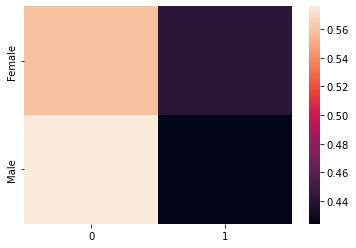


Rate Normalized by Column
            0      1  Total
Female  0.518  0.535  1.053
Male    0.482  0.465  0.947
Total   1.000  1.000  2.000

SEX_IM SCH_BUS


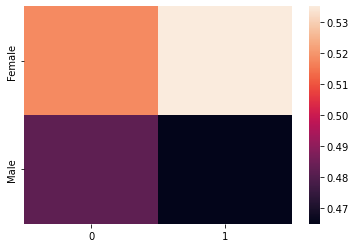


SEX_IM URBANICITY
['Male', 'Female']
['2', '1']

Count Crashes
             1       2   Total
Female  226649   63713  290362
Male    277124   76788  353912
Total   503773  140501  644274

Hospitalization Count
            1      2   Total
Female  37137  11388   48525
Male    42634  12451   55085
Total   79771  23839  103610

Hospitalization Rate
            1      2  Total
Female  0.164  0.179  0.343
Male    0.154  0.162  0.316
Total   0.318  0.341  0.659

Rate Normalized by Row
            1      2  Total
Female  0.478  0.522    1.0
Male    0.487  0.513    1.0
Total   0.965  1.035    2.0

SEX_IM URBANICITY


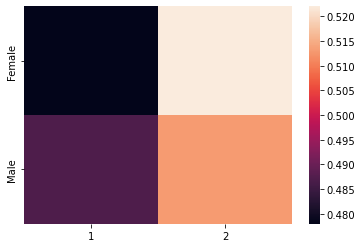


Rate Normalized by Column
            1      2  Total
Female  0.516  0.524   1.04
Male    0.484  0.476   0.96
Total   1.000  1.000   2.00

SEX_IM URBANICITY


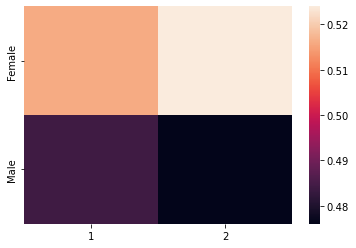


SEX_IM VE_TOTAL
['Male', 'Female']
['2', '1', 'Multiple', '3']

Count Crashes
             1       2      3  Multiple   Total
Female   44482  202795  32356     10729  290362
Male     73223  231211  36857     12621  353912
Total   117705  434006  69213     23350  644274

Hospitalization Count
            1      2      3  Multiple   Total
Female  12594  28034   5818      2079   48525
Male    22542  25714   4891      1938   55085
Total   35136  53748  10709      4017  103610

Hospitalization Rate
            1      2      3  Multiple  Total
Female  0.283  0.138  0.180     0.194  0.795
Male    0.308  0.111  0.133     0.154  0.706
Total   0.591  0.249  0.313     0.348  1.501

Rate Normalized by Row
            1      2      3  Multiple  Total
Female  0.356  0.174  0.226     0.244    1.0
Male    0.436  0.158  0.188     0.218    1.0
Total   0.792  0.332  0.414     0.462    2.0

SEX_IM VE_TOTAL


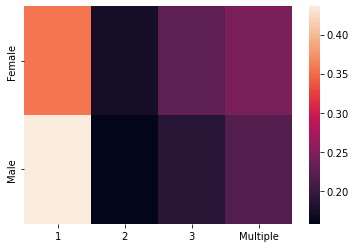


Rate Normalized by Column
            1      2      3  Multiple  Total
Female  0.479  0.554  0.575     0.558  2.166
Male    0.521  0.446  0.425     0.442  1.834
Total   1.000  1.000  1.000     1.000  4.000

SEX_IM VE_TOTAL


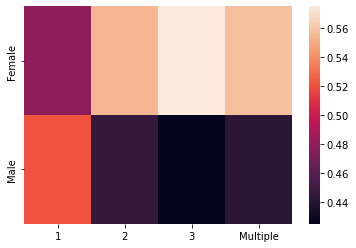


SEX_IM WEATHR_IM
['Male', 'Female']
['B', 'A', 'D', 'C', 'E']

Count Crashes
           A       B      C      D      E   Total
Female  1263  212296  27237  44599   4967  290362
Male    1800  260272  32668  52852   6320  353912
Total   3063  472568  59905  97451  11287  644274

Hospitalization Count
          A      B     C      D     E   Total
Female  291  35172  4846   7484   732   48525
Male    345  41500  4727   7830   683   55085
Total   636  76672  9573  15314  1415  103610

Hospitalization Rate
            A      B      C      D      E  Total
Female  0.230  0.166  0.178  0.168  0.147  0.889
Male    0.192  0.159  0.145  0.148  0.108  0.752
Total   0.422  0.325  0.323  0.316  0.255  1.641

Rate Normalized by Row
            A      B      C      D      E  Total
Female  0.259  0.186  0.200  0.189  0.166    1.0
Male    0.255  0.212  0.192  0.197  0.144    1.0
Total   0.514  0.398  0.392  0.386  0.310    2.0

SEX_IM WEATHR_IM


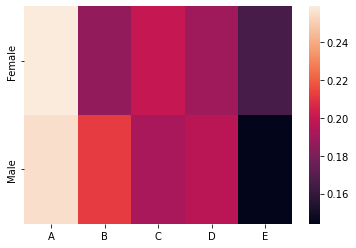


Rate Normalized by Column
            A     B      C      D      E  Total
Female  0.546  0.51  0.551  0.531  0.577  2.715
Male    0.454  0.49  0.449  0.469  0.423  2.285
Total   1.000  1.00  1.000  1.000  1.000  5.000

SEX_IM WEATHR_IM


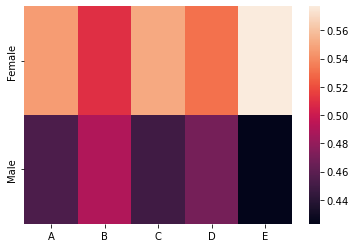


SEX_IM WKDY_IM
['Male', 'Female']
['Weekday', 'Weekend']

Count Crashes
        Weekday  Weekend   Total
Female   219493    70869  290362
Male     265064    88848  353912
Total    484557   159717  644274

Hospitalization Count
        Weekday  Weekend   Total
Female    35743    12782   48525
Male      38841    16244   55085
Total     74584    29026  103610

Hospitalization Rate
        Weekday  Weekend  Total
Female    0.163    0.180  0.343
Male      0.147    0.183  0.330
Total     0.310    0.363  0.673

Rate Normalized by Row
        Weekday  Weekend  Total
Female    0.474    0.526    1.0
Male      0.445    0.555    1.0
Total     0.919    1.081    2.0

SEX_IM WKDY_IM


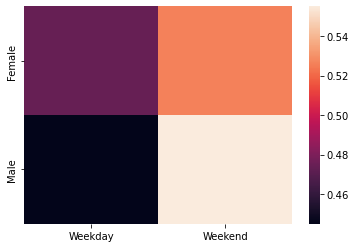


Rate Normalized by Column
        Weekday  Weekend  Total
Female    0.526    0.497  1.023
Male      0.474    0.503  0.977
Total     1.000    1.000  2.000

SEX_IM WKDY_IM


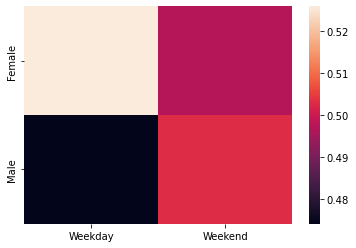


SEX_IM WRK_ZONE
['Male', 'Female']
['0', '1', '2', '3']

Count Crashes
             0      1    2    3   Total
Female  285192   4779  313   78  290362
Male    346586   6746  478  102  353912
Total   631778  11525  791  180  644274

Hospitalization Count
             0     1    2   3   Total
Female   47796   659   47  23   48525
Male     54237   766   68  14   55085
Total   102033  1425  115  37  103610

Hospitalization Rate
            0      1      2      3  Total
Female  0.168  0.138  0.150  0.295  0.751
Male    0.156  0.114  0.142  0.137  0.549
Total   0.324  0.252  0.292  0.432  1.300

Rate Normalized by Row
            0      1      2      3  Total
Female  0.223  0.184  0.200  0.393  1.000
Male    0.285  0.207  0.259  0.250  1.001
Total   0.508  0.391  0.459  0.643  2.001

SEX_IM WRK_ZONE


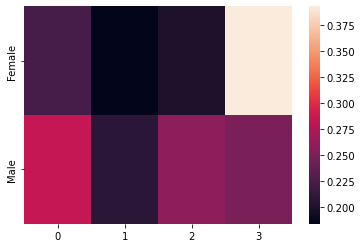


Rate Normalized by Column
            0      1      2      3  Total
Female  0.517  0.548  0.514  0.682  2.261
Male    0.483  0.452  0.486  0.318  1.739
Total   1.000  1.000  1.000  1.000  4.000

SEX_IM WRK_ZONE


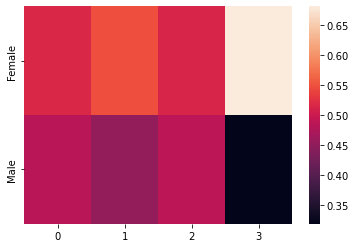


PER_TYP BODY_TYP
['In_VIT', 'Not_in_Vehicle', 'In_VNIT']
['Car', 'SUV', 'Light_Truck', 'Heavy_Truck', 'Motorcycle']

Count Crashes
                   Car  Heavy_Truck  Light_Truck  Motorcycle     SUV   Total
In_VIT          247869        32454       136677       16664  185363  619027
In_VNIT            704          280          591          14     606    2195
Not_in_Vehicle       0        23052            0           0       0   23052
Total           248573        55786       137268       16678  185969  644274

Hospitalization Count
                  Car  Heavy_Truck  Light_Truck  Motorcycle    SUV   Total
In_VIT          37921         1021        15200       10157  24888   89187
In_VNIT            65           14           60           1     58     198
Not_in_Vehicle      0        14225            0           0      0   14225
Total           37986        15260        15260       10158  24946  103610

Hospitalization Rate
                  Car  Heavy_Truck  Light_Truck  Motorcycle    

/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_11277/550312234.py:69: RuntimeWarning: invalid value encountered in true_divide
  F = pd.DataFrame(E/D, index=B, columns=C).round(3)
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_11277/550312234.py:96: RuntimeWarning: invalid value encountered in true_divide
  F = pd.DataFrame(E/D, index=B, columns=C)


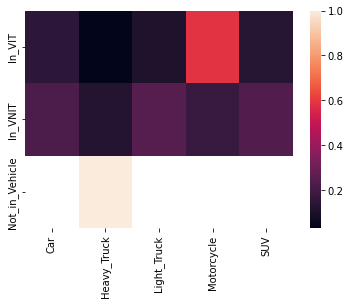


Rate Normalized by Column
                  Car  Heavy_Truck  Light_Truck  Motorcycle    SUV  Total
In_VIT          0.624        0.045        0.523       0.895  0.584  2.671
In_VNIT         0.376        0.072        0.477       0.105  0.416  1.446
Not_in_Vehicle    NaN        0.883          NaN         NaN    NaN  0.883
Total           1.000        1.000        1.000       1.000  1.000  5.000

PER_TYP BODY_TYP


/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_11277/550312234.py:137: RuntimeWarning: invalid value encountered in true_divide
  F = pd.DataFrame(E/D, index=B, columns=C)


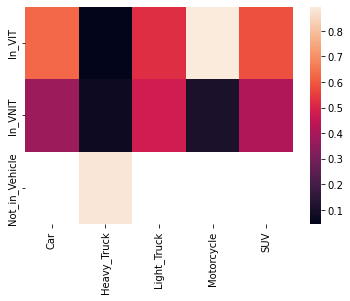


PER_TYP MAKE
['In_VIT', 'Not_in_Vehicle', 'In_VNIT']
['B', 'E', 'G', 'F', 'I', 'D', 'A', 'C', 'H']

Count Crashes
                    A      B       C      D      E       F      G      H  \
In_VIT          12353  88904  106460  88906  80367  120533  74537  18613   
In_VNIT             4    274     304    327    227     487    331     81   
Not_in_Vehicle      0      0       0      0      0       0      0      0   
Total           12357  89178  106764  89233  80594  121020  74868  18694   

                    I   Total  
In_VIT          28354  619027  
In_VNIT           160    2195  
Not_in_Vehicle  23052   23052  
Total           51566  644274  

Hospitalization Count
                   A      B      C      D      E      F     G     H      I  \
In_VIT          7162  14859  16158  12626  10729  15725  9117  1842    969   
In_VNIT            0     24     33     32     19     43    33     5      9   
Not_in_Vehicle     0      0      0      0      0      0     0     0  14225   
Total    

/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_11277/550312234.py:69: RuntimeWarning: invalid value encountered in true_divide
  F = pd.DataFrame(E/D, index=B, columns=C).round(3)
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_11277/550312234.py:96: RuntimeWarning: invalid value encountered in true_divide
  F = pd.DataFrame(E/D, index=B, columns=C)


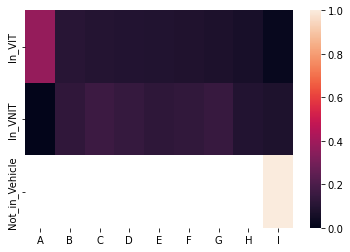


Rate Normalized by Column
                  A      B      C      D      E      F      G      H      I  \
In_VIT          1.0  0.656  0.583  0.592  0.615  0.596  0.551  0.616  0.048   
In_VNIT         0.0  0.344  0.417  0.408  0.385  0.404  0.449  0.384  0.080   
Not_in_Vehicle  NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  0.872   
Total           1.0  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000   

                Total  
In_VIT          5.257  
In_VNIT         2.871  
Not_in_Vehicle  0.872  
Total           9.000  

PER_TYP MAKE


/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_11277/550312234.py:137: RuntimeWarning: invalid value encountered in true_divide
  F = pd.DataFrame(E/D, index=B, columns=C)


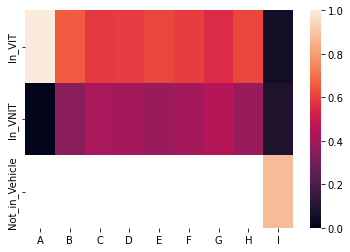


PER_TYP HOUR_IM
['In_VIT', 'Not_in_Vehicle', 'In_VNIT']
['Mid_Day', 'Early_Eve', 'Early_Morn', 'Evening', 'Morning', 'Rush_Hour', 'Late_Nght']

Count Crashes
                Early_Eve  Early_Morn  Evening  Late_Nght  Mid_Day  Morning  \
In_VIT              73868       22588    59307      40783   151055   106821   
In_VNIT               225          73      273        284      549      378   
Not_in_Vehicle       3441        1033     3235       1897     4547     3755   
Total               77534       23694    62815      42964   156151   110954   

                Rush_Hour   Total  
In_VIT             164605  619027  
In_VNIT               413    2195  
Not_in_Vehicle       5144   23052  
Total              170162  644274  

Hospitalization Count
                Early_Eve  Early_Morn  Evening  Late_Nght  Mid_Day  Morning  \
In_VIT              10286        3982    10411       9508    20305    14242   
In_VNIT                19          11       28         44       46       25   
Not_i

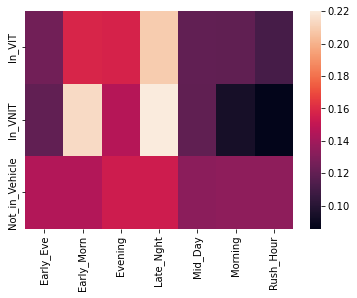


Rate Normalized by Column
                Early_Eve  Early_Morn  Evening  Late_Nght  Mid_Day  Morning  \
In_VIT              0.162       0.183    0.184      0.219    0.168    0.169   
In_VNIT             0.098       0.156    0.108      0.145    0.104    0.084   
Not_in_Vehicle      0.740       0.661    0.708      0.636    0.728    0.747   
Total               1.000       1.000    1.000      1.000    1.000    1.000   

                Rush_Hour  Total  
In_VIT              0.160  1.245  
In_VNIT             0.078  0.773  
Not_in_Vehicle      0.762  4.982  
Total               1.000  7.000  

PER_TYP HOUR_IM


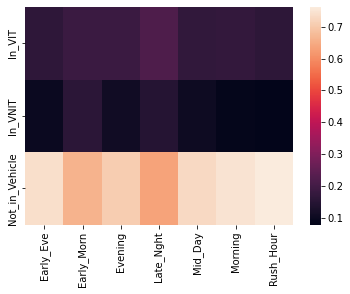


PER_TYP INT_HWY
['In_VIT', 'Not_in_Vehicle', 'In_VNIT']
[0, 1]

Count Crashes
                     0      1   Total
In_VIT          555566  63461  619027
In_VNIT           1896    299    2195
Not_in_Vehicle   22679    373   23052
Total           580141  64133  644274

Hospitalization Count
                    0     1   Total
In_VIT          79712  9475   89187
In_VNIT           135    63     198
Not_in_Vehicle  13997   228   14225
Total           93844  9766  103610

Hospitalization Rate
                    0      1  Total
In_VIT          0.143  0.149  0.292
In_VNIT         0.071  0.211  0.282
Not_in_Vehicle  0.617  0.611  1.228
Total           0.831  0.971  1.802

Rate Normalized by Row
                    0      1  Total
In_VIT          0.490  0.510    1.0
In_VNIT         0.253  0.747    1.0
Not_in_Vehicle  0.502  0.498    1.0
Total           1.245  1.755    3.0

PER_TYP INT_HWY


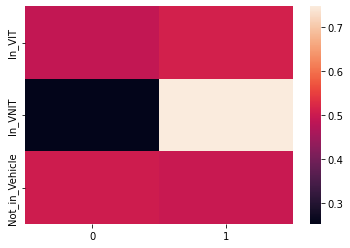


Rate Normalized by Column
                    0      1  Total
In_VIT          0.172  0.154  0.326
In_VNIT         0.086  0.217  0.303
Not_in_Vehicle  0.742  0.629  1.371
Total           1.000  1.000  2.000

PER_TYP INT_HWY


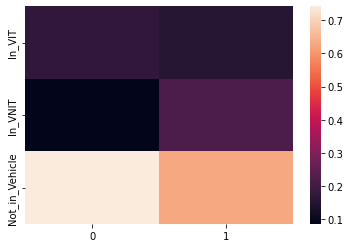


PER_TYP LGTCON_IM
['In_VIT', 'Not_in_Vehicle', 'In_VNIT']
['Daylight', 'Dawn_Lighted', 'Dusk', 'Dark']

Count Crashes
                 Dark  Dawn_Lighted  Daylight   Dusk   Total
In_VIT          51309        109187    443683  14848  619027
In_VNIT           252           478      1430     35    2195
Not_in_Vehicle   1960          6128     14286    678   23052
Total           53521        115793    459399  15561  644274

Hospitalization Count
                 Dark  Dawn_Lighted  Daylight  Dusk   Total
In_VIT          10980         17120     58933  2154   89187
In_VNIT            38            52       106     2     198
Not_in_Vehicle   1286          4163      8347   429   14225
Total           12304         21335     67386  2585  103610

Hospitalization Rate
                 Dark  Dawn_Lighted  Daylight   Dusk  Total
In_VIT          0.214         0.157     0.133  0.145  0.649
In_VNIT         0.151         0.109     0.074  0.057  0.391
Not_in_Vehicle  0.656         0.679     0.584  0.63

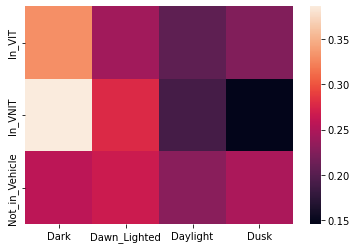


Rate Normalized by Column
                 Dark  Dawn_Lighted  Daylight   Dusk  Total
In_VIT          0.210         0.166     0.168  0.174  0.718
In_VNIT         0.148         0.115     0.094  0.068  0.425
Not_in_Vehicle  0.643         0.719     0.738  0.758  2.858
Total           1.001         1.000     1.000  1.000  4.001

PER_TYP LGTCON_IM


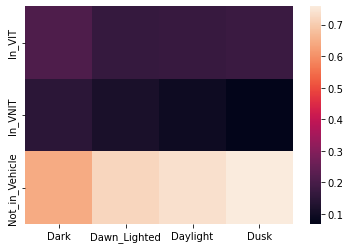


PER_TYP MONTH
['In_VIT', 'Not_in_Vehicle', 'In_VNIT']
['Winter', 'Spring_Fall', 'Summer']

Count Crashes
                Spring_Fall  Summer  Winter   Total
In_VIT               208215  216711  194101  619027
In_VNIT                 740     751     704    2195
Not_in_Vehicle         7869    8260    6923   23052
Total                216824  225722  201728  644274

Hospitalization Count
                Spring_Fall  Summer  Winter   Total
In_VIT                29667   33310   26210   89187
In_VNIT                  66      83      49     198
Not_in_Vehicle         4854    5010    4361   14225
Total                 34587   38403   30620  103610

Hospitalization Rate
                Spring_Fall  Summer  Winter  Total
In_VIT                0.142   0.154   0.135  0.431
In_VNIT               0.089   0.111   0.070  0.270
Not_in_Vehicle        0.617   0.607   0.630  1.854
Total                 0.848   0.872   0.835  2.555

Rate Normalized by Row
                Spring_Fall  Summer  Winter  Total

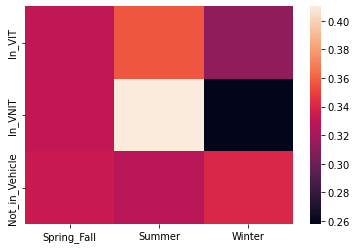


Rate Normalized by Column
                Spring_Fall  Summer  Winter  Total
In_VIT                0.168   0.177   0.162  0.507
In_VNIT               0.105   0.127   0.083  0.315
Not_in_Vehicle        0.727   0.697   0.755  2.179
Total                 1.000   1.001   1.000  3.001

PER_TYP MONTH


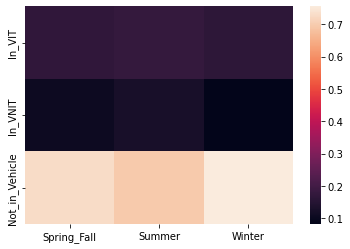


PER_TYP PEDS
['In_VIT', 'Not_in_Vehicle', 'In_VNIT']
['0', '1', 'Multiple']

Count Crashes
                     0      1  Multiple   Total
In_VIT          591304  26801       922  619027
In_VNIT           1998    172        25    2195
Not_in_Vehicle       0  21567      1485   23052
Total           593302  48540      2432  644274

Hospitalization Count
                    0      1  Multiple   Total
In_VIT          88735    386        66   89187
In_VNIT           168     24         6     198
Not_in_Vehicle      0  13329       896   14225
Total           88903  13739       968  103610

Hospitalization Rate
                    0      1  Multiple  Total
In_VIT          0.150  0.014     0.072  0.236
In_VNIT         0.084  0.140     0.240  0.464
Not_in_Vehicle    NaN  0.618     0.603  1.221
Total           0.234  0.772     0.915  1.921

Rate Normalized by Row
                    0      1  Multiple  Total
In_VIT          0.636  0.061     0.303    1.0
In_VNIT         0.181  0.301     0.518    

/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_11277/550312234.py:69: RuntimeWarning: invalid value encountered in true_divide
  F = pd.DataFrame(E/D, index=B, columns=C).round(3)
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_11277/550312234.py:96: RuntimeWarning: invalid value encountered in true_divide
  F = pd.DataFrame(E/D, index=B, columns=C)


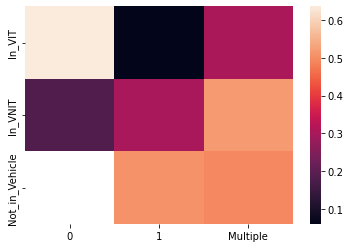


Rate Normalized by Column
                    0      1  Multiple  Total
In_VIT          0.641  0.019     0.078  0.738
In_VNIT         0.359  0.181     0.262  0.802
Not_in_Vehicle    NaN  0.801     0.659  1.460
Total           1.000  1.001     0.999  3.000

PER_TYP PEDS


/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_11277/550312234.py:137: RuntimeWarning: invalid value encountered in true_divide
  F = pd.DataFrame(E/D, index=B, columns=C)


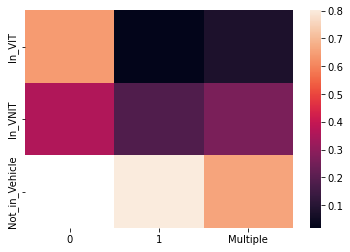


PER_TYP PERMVIT
['In_VIT', 'Not_in_Vehicle', 'In_VNIT']
['2', 'Multiple', '1']

Count Crashes
                    1       2  Multiple   Total
In_VIT          69583  200622    348822  619027
In_VNIT          1617     353       225    2195
Not_in_Vehicle  19024    2772      1256   23052
Total           90224  203747    350303  644274

Hospitalization Count
                    1      2  Multiple   Total
In_VIT          14334  25527     49326   89187
In_VNIT           136     33        29     198
Not_in_Vehicle  11628   1789       808   14225
Total           26098  27349     50163  103610

Hospitalization Rate
                    1      2  Multiple  Total
In_VIT          0.206  0.127     0.141  0.474
In_VNIT         0.084  0.093     0.129  0.306
Not_in_Vehicle  0.611  0.645     0.643  1.899
Total           0.901  0.865     0.913  2.679

Rate Normalized by Row
                    1      2  Multiple  Total
In_VIT          0.434  0.268     0.298  1.000
In_VNIT         0.274  0.305     0.421 

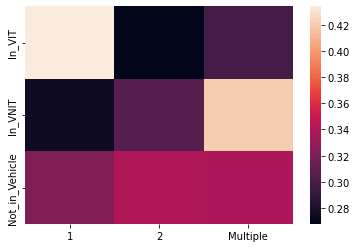


Rate Normalized by Column
                    1      2  Multiple  Total
In_VIT          0.229  0.147     0.155  0.531
In_VNIT         0.093  0.108     0.141  0.342
Not_in_Vehicle  0.678  0.745     0.704  2.127
Total           1.000  1.000     1.000  3.000

PER_TYP PERMVIT


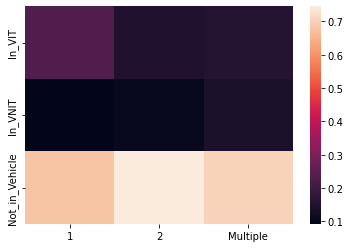


PER_TYP REL_ROAD
['In_VIT', 'Not_in_Vehicle', 'In_VNIT']
['On_Road', 'Not_on_Road', 'Parking_Area']

Count Crashes
                Not_on_Road  On_Road  Parking_Area   Total
In_VIT                60920   549305          8802  619027
In_VNIT                 739      454          1002    2195
Not_in_Vehicle         1241    21526           285   23052
Total                 62900   571285         10089  644274

Hospitalization Count
                Not_on_Road  On_Road  Parking_Area   Total
In_VIT                20298    68041           848   89187
In_VNIT                 114       33            51     198
Not_in_Vehicle          728    13345           152   14225
Total                 21140    81419          1051  103610

Hospitalization Rate
                Not_on_Road  On_Road  Parking_Area  Total
In_VIT                0.333    0.124         0.096  0.553
In_VNIT               0.154    0.073         0.051  0.278
Not_in_Vehicle        0.587    0.620         0.533  1.740
Total            

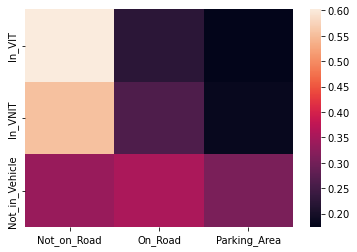


Rate Normalized by Column
                Not_on_Road  On_Road  Parking_Area  Total
In_VIT                0.310    0.152         0.142  0.604
In_VNIT               0.144    0.089         0.075  0.308
Not_in_Vehicle        0.546    0.759         0.784  2.089
Total                 1.000    1.000         1.001  3.001

PER_TYP REL_ROAD


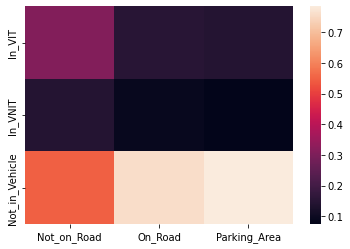


PER_TYP RELJCT2_IM
['In_VIT', 'Not_in_Vehicle', 'In_VNIT']
['B', 'A', 'C', 'D']

Count Crashes
                     A       B      C       D   Total
In_VIT          169443  240106  58487  150991  619027
In_VNIT            154    1600    239     202    2195
Not_in_Vehicle    3527    7334   2215    9976   23052
Total           173124  249040  60941  161169  644274

Hospitalization Count
                    A      B     C      D   Total
In_VIT          31031  38327  7281  12548   89187
In_VNIT            18    166     6      8     198
Not_in_Vehicle   2110   4891  1135   6089   14225
Total           33159  43384  8422  18645  103610

Hospitalization Rate
                    A      B      C      D  Total
In_VIT          0.183  0.160  0.124  0.083  0.550
In_VNIT         0.117  0.104  0.025  0.040  0.286
Not_in_Vehicle  0.598  0.667  0.512  0.610  2.387
Total           0.898  0.931  0.661  0.733  3.223

Rate Normalized by Row
                    A      B      C      D  Total
In_VIT         

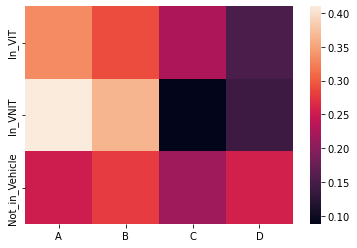


Rate Normalized by Column
                    A      B      C      D  Total
In_VIT          0.204  0.172  0.188  0.113  0.677
In_VNIT         0.130  0.112  0.038  0.054  0.334
Not_in_Vehicle  0.666  0.717  0.774  0.833  2.990
Total           1.000  1.001  1.000  1.000  4.001

PER_TYP RELJCT2_IM


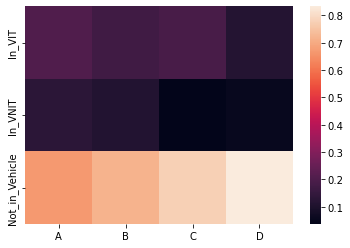


PER_TYP SCH_BUS
['In_VIT', 'Not_in_Vehicle', 'In_VNIT']
['0', '1']

Count Crashes
                     0     1   Total
In_VIT          615928  3099  619027
In_VNIT           2153    42    2195
Not_in_Vehicle   22939   113   23052
Total           641020  3254  644274

Hospitalization Count
                     0    1   Total
In_VIT           88863  324   89187
In_VNIT            197    1     198
Not_in_Vehicle   14149   76   14225
Total           103209  401  103610

Hospitalization Rate
                    0      1  Total
In_VIT          0.144  0.105  0.249
In_VNIT         0.092  0.024  0.116
Not_in_Vehicle  0.617  0.673  1.290
Total           0.853  0.802  1.655

Rate Normalized by Row
                    0      1  Total
In_VIT          0.580  0.420    1.0
In_VNIT         0.794  0.206    1.0
Not_in_Vehicle  0.478  0.522    1.0
Total           1.852  1.148    3.0

PER_TYP SCH_BUS


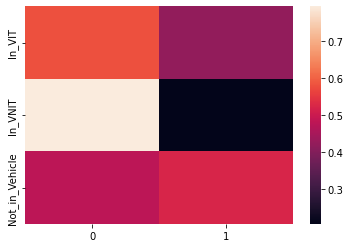


Rate Normalized by Column
                    0      1  Total
In_VIT          0.169  0.131  0.300
In_VNIT         0.107  0.030  0.137
Not_in_Vehicle  0.723  0.840  1.563
Total           0.999  1.001  2.000

PER_TYP SCH_BUS


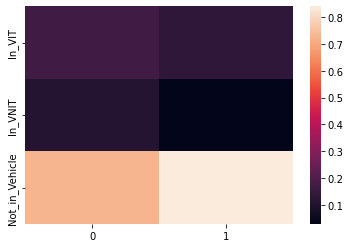


PER_TYP URBANICITY
['In_VIT', 'Not_in_Vehicle', 'In_VNIT']
['2', '1']

Count Crashes
                     1       2   Total
In_VIT          481918  137109  619027
In_VNIT           1771     424    2195
Not_in_Vehicle   20084    2968   23052
Total           503773  140501  644274

Hospitalization Count
                    1      2   Total
In_VIT          67053  22134   89187
In_VNIT           163     35     198
Not_in_Vehicle  12555   1670   14225
Total           79771  23839  103610

Hospitalization Rate
                    1      2  Total
In_VIT          0.139  0.161  0.300
In_VNIT         0.092  0.083  0.175
Not_in_Vehicle  0.625  0.563  1.188
Total           0.856  0.807  1.663

Rate Normalized by Row
                    1      2  Total
In_VIT          0.463  0.537    1.0
In_VNIT         0.527  0.473    1.0
Not_in_Vehicle  0.526  0.474    1.0
Total           1.516  1.484    3.0

PER_TYP URBANICITY


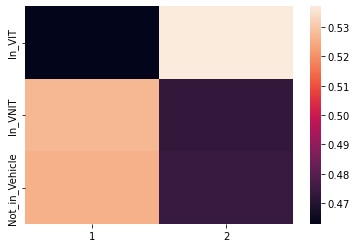


Rate Normalized by Column
                    1      2  Total
In_VIT          0.162  0.200  0.362
In_VNIT         0.107  0.102  0.209
Not_in_Vehicle  0.730  0.698  1.428
Total           0.999  1.000  1.999

PER_TYP URBANICITY


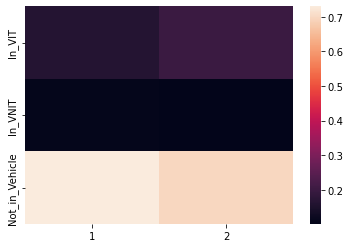


PER_TYP VE_TOTAL
['In_VIT', 'Not_in_Vehicle', 'In_VNIT']
['2', '1', 'Multiple', '3']

Count Crashes
                     1       2      3  Multiple   Total
In_VIT           95724  431474  68682     23147  619027
In_VNIT              0    1728    348       119    2195
Not_in_Vehicle   21981     804    183        84   23052
Total           117705  434006  69213     23350  644274

Hospitalization Count
                    1      2      3  Multiple   Total
In_VIT          21558  53135  10540      3954   89187
In_VNIT             0    120     63        15     198
Not_in_Vehicle  13578    493    106        48   14225
Total           35136  53748  10709      4017  103610

Hospitalization Rate
                    1      2      3  Multiple  Total
In_VIT          0.225  0.123  0.153     0.171  0.672
In_VNIT           NaN  0.069  0.181     0.126  0.376
Not_in_Vehicle  0.618  0.613  0.579     0.571  2.381
Total           0.843  0.805  0.913     0.868  3.429

Rate Normalized by Row
               

/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_11277/550312234.py:69: RuntimeWarning: invalid value encountered in true_divide
  F = pd.DataFrame(E/D, index=B, columns=C).round(3)
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_11277/550312234.py:96: RuntimeWarning: invalid value encountered in true_divide
  F = pd.DataFrame(E/D, index=B, columns=C)


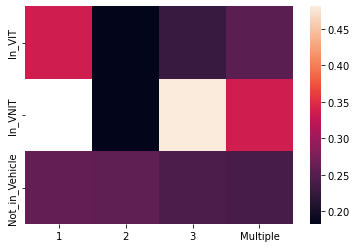


Rate Normalized by Column
                    1      2      3  Multiple  Total
In_VIT          0.267  0.153  0.168     0.197  0.785
In_VNIT           NaN  0.086  0.198     0.145  0.429
Not_in_Vehicle  0.733  0.761  0.634     0.658  2.786
Total           1.000  1.000  1.000     1.000  4.000

PER_TYP VE_TOTAL


/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_11277/550312234.py:137: RuntimeWarning: invalid value encountered in true_divide
  F = pd.DataFrame(E/D, index=B, columns=C)


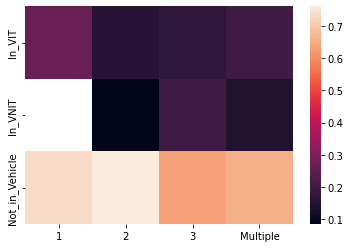


PER_TYP WEATHR_IM
['In_VIT', 'Not_in_Vehicle', 'In_VNIT']
['B', 'A', 'D', 'C', 'E']

Count Crashes
                   A       B      C      D      E   Total
In_VIT          2964  452771  57889  94363  11040  619027
In_VNIT           15    1654    156    314     56    2195
Not_in_Vehicle    84   18143   1860   2774    191   23052
Total           3063  472568  59905  97451  11287  644274

Hospitalization Count
                  A      B     C      D     E   Total
In_VIT          586  65435  8313  13565  1288   89187
In_VNIT           2    147    19     26     4     198
Not_in_Vehicle   48  11090  1241   1723   123   14225
Total           636  76672  9573  15314  1415  103610

Hospitalization Rate
                    A      B      C      D      E  Total
In_VIT          0.198  0.145  0.144  0.144  0.117  0.748
In_VNIT         0.133  0.089  0.122  0.083  0.071  0.498
Not_in_Vehicle  0.571  0.611  0.667  0.621  0.644  3.114
Total           0.902  0.845  0.933  0.848  0.832  4.360

Rate Norm

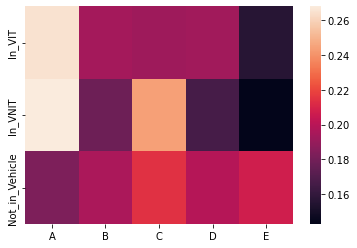


Rate Normalized by Column
                    A      B      C      D      E  Total
In_VIT          0.219  0.171  0.154  0.170  0.140  0.854
In_VNIT         0.148  0.105  0.131  0.098  0.086  0.568
Not_in_Vehicle  0.633  0.724  0.715  0.733  0.774  3.579
Total           1.000  1.000  1.000  1.001  1.000  5.001

PER_TYP WEATHR_IM


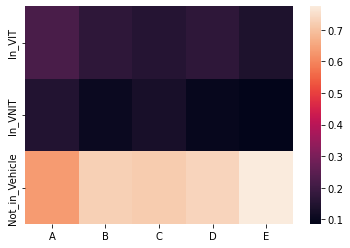


PER_TYP WKDY_IM
['In_VIT', 'Not_in_Vehicle', 'In_VNIT']
['Weekday', 'Weekend']

Count Crashes
                Weekday  Weekend   Total
In_VIT           465260   153767  619027
In_VNIT            1580      615    2195
Not_in_Vehicle    17717     5335   23052
Total            484557   159717  644274

Hospitalization Count
                Weekday  Weekend   Total
In_VIT            63610    25577   89187
In_VNIT             135       63     198
Not_in_Vehicle    10839     3386   14225
Total             74584    29026  103610

Hospitalization Rate
                Weekday  Weekend  Total
In_VIT            0.137    0.166  0.303
In_VNIT           0.085    0.102  0.187
Not_in_Vehicle    0.612    0.635  1.247
Total             0.834    0.903  1.737

Rate Normalized by Row
                Weekday  Weekend  Total
In_VIT            0.451    0.549    1.0
In_VNIT           0.455    0.545    1.0
Not_in_Vehicle    0.491    0.509    1.0
Total             1.397    1.603    3.0

PER_TYP WKDY_IM


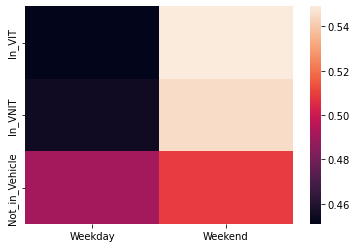


Rate Normalized by Column
                Weekday  Weekend  Total
In_VIT            0.164    0.184  0.348
In_VNIT           0.102    0.113  0.215
Not_in_Vehicle    0.734    0.703  1.437
Total             1.000    1.000  2.000

PER_TYP WKDY_IM


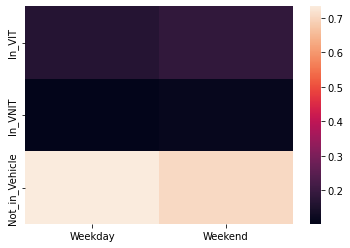


PER_TYP WRK_ZONE
['In_VIT', 'Not_in_Vehicle', 'In_VNIT']
['0', '1', '2', '3']

Count Crashes
                     0      1    2    3   Total
In_VIT          606925  11193  750  159  619027
In_VNIT           2050    102   30   13    2195
Not_in_Vehicle   22803    230   11    8   23052
Total           631778  11525  791  180  644274

Hospitalization Count
                     0     1    2   3   Total
In_VIT           87765  1285  107  30   89187
In_VNIT            185    10    2   1     198
Not_in_Vehicle   14083   130    6   6   14225
Total           102033  1425  115  37  103610

Hospitalization Rate
                    0      1      2      3  Total
In_VIT          0.145  0.115  0.143  0.189  0.592
In_VNIT         0.090  0.098  0.067  0.077  0.332
Not_in_Vehicle  0.618  0.565  0.545  0.750  2.478
Total           0.853  0.778  0.755  1.016  3.402

Rate Normalized by Row
                    0      1      2      3  Total
In_VIT          0.245  0.194  0.241  0.319  0.999
In_VNIT         0

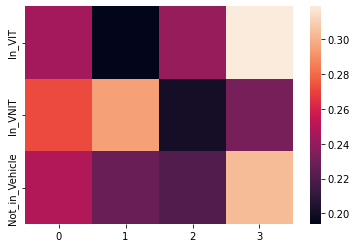


Rate Normalized by Column
                    0      1      2      3  Total
In_VIT          0.170  0.148  0.189  0.186  0.693
In_VNIT         0.106  0.126  0.088  0.076  0.396
Not_in_Vehicle  0.724  0.726  0.723  0.738  2.911
Total           1.000  1.000  1.000  1.000  4.000

PER_TYP WRK_ZONE


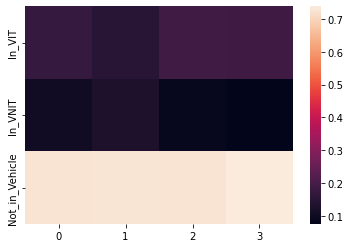


BODY_TYP MAKE
['Car', 'SUV', 'Light_Truck', 'Heavy_Truck', 'Motorcycle']
['B', 'E', 'G', 'F', 'I', 'D', 'A', 'C', 'H']

Count Crashes
                 A      B       C      D      E       F      G      H      I  \
Car            362  48225   60408  35831  41474   34599  22092   4962    620   
Heavy_Truck      1   1577      73   1218      0    4064   2154   2101  44598   
Light_Truck     18  10993   11284  30961  12581   35182  32602   1449   2198   
Motorcycle   11258   4452       0    258      0      28     26     12    644   
SUV            718  23931   34999  20965  26539   47147  17994  10170   3506   
Total        12357  89178  106764  89233  80594  121020  74868  18694  51566   

              Total  
Car          248573  
Heavy_Truck   55786  
Light_Truck  137268  
Motorcycle    16678  
SUV          185969  
Total        644274  

Hospitalization Count
                A      B      C      D      E      F     G     H      I  \
Car            65   7523   9750   5693   6042   5336

/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_11277/550312234.py:69: RuntimeWarning: invalid value encountered in true_divide
  F = pd.DataFrame(E/D, index=B, columns=C).round(3)
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_11277/550312234.py:96: RuntimeWarning: invalid value encountered in true_divide
  F = pd.DataFrame(E/D, index=B, columns=C)


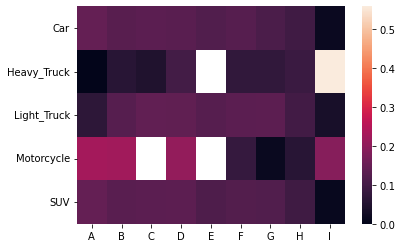

/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_11277/550312234.py:137: RuntimeWarning: invalid value encountered in true_divide
  F = pd.DataFrame(E/D, index=B, columns=C)



Rate Normalized by Column
                 A      B      C      D      E      F      G      H      I  \
Car          0.177  0.149  0.357  0.152  0.385  0.234  0.292  0.224  0.021   
Heavy_Truck  0.000  0.035  0.061  0.056    NaN  0.066  0.094  0.099  0.366   
Light_Truck  0.055  0.101  0.260  0.112  0.280  0.170  0.245  0.158  0.034   
Motorcycle   0.611  0.578    NaN  0.538    NaN  0.326  0.083  0.321  0.564   
SUV          0.158  0.138  0.323  0.143  0.335  0.204  0.285  0.197  0.014   
Total        1.001  1.001  1.001  1.001  1.000  1.000  0.999  0.999  0.999   

             Total  
Car          1.991  
Heavy_Truck  0.777  
Light_Truck  1.415  
Motorcycle   3.021  
SUV          1.797  
Total        9.001  

BODY_TYP MAKE


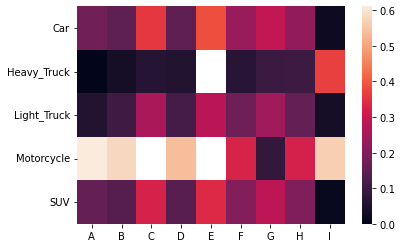


BODY_TYP HOUR_IM
['Car', 'SUV', 'Light_Truck', 'Heavy_Truck', 'Motorcycle']
['Mid_Day', 'Early_Eve', 'Early_Morn', 'Evening', 'Morning', 'Rush_Hour', 'Late_Nght']

Count Crashes
             Early_Eve  Early_Morn  Evening  Late_Nght  Mid_Day  Morning  \
Car              30703        8765    25831      18371    58335    40041   
Heavy_Truck       6087        2793     5849       4780    13281    11169   
Light_Truck      15656        5467    11535       7294    34914    25363   
Motorcycle        2461         498     2200       1399     4035     1838   
SUV              22627        6171    17400      11120    45586    32543   
Total            77534       23694    62815      42964   156151   110954   

             Rush_Hour   Total  
Car              66527  248573  
Heavy_Truck      11827   55786  
Light_Truck      37039  137268  
Motorcycle        4247   16678  
SUV              50522  185969  
Total           170162  644274  

Hospitalization Count
             Early_Eve  Early_Morn

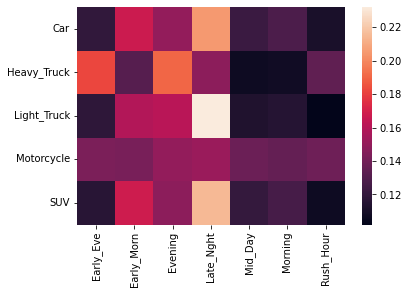


Rate Normalized by Column
             Early_Eve  Early_Morn  Evening  Late_Nght  Mid_Day  Morning  \
Car              0.103       0.140    0.117      0.147    0.121    0.126   
Heavy_Truck      0.273       0.192    0.256      0.184    0.185    0.184   
Light_Truck      0.079       0.103    0.096      0.128    0.086    0.087   
Motorcycle       0.455       0.437    0.427      0.401    0.501    0.491   
SUV              0.090       0.128    0.104      0.139    0.108    0.112   
Total            1.000       1.000    1.000      0.999    1.001    1.000   

             Rush_Hour  Total  
Car              0.108  0.862  
Heavy_Truck      0.226  1.500  
Light_Truck      0.076  0.655  
Motorcycle       0.496  3.208  
SUV              0.094  0.775  
Total            1.000  7.000  

BODY_TYP HOUR_IM


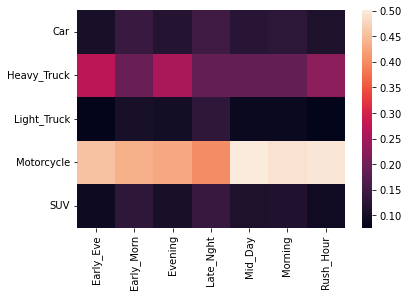


BODY_TYP INT_HWY
['Car', 'SUV', 'Light_Truck', 'Heavy_Truck', 'Motorcycle']
[0, 1]

Count Crashes
                  0      1   Total
Car          224809  23764  248573
Heavy_Truck   48800   6986   55786
Light_Truck  122447  14821  137268
Motorcycle    15377   1301   16678
SUV          168708  17261  185969
Total        580141  64133  644274

Hospitalization Count
                 0     1   Total
Car          33983  4003   37986
Heavy_Truck  14789   471   15260
Light_Truck  13379  1881   15260
Motorcycle    9345   813   10158
SUV          22348  2598   24946
Total        93844  9766  103610

Hospitalization Rate
                 0      1  Total
Car          0.151  0.168  0.319
Heavy_Truck  0.303  0.067  0.370
Light_Truck  0.109  0.127  0.236
Motorcycle   0.608  0.625  1.233
SUV          0.132  0.151  0.283
Total        1.303  1.138  2.441

Rate Normalized by Row
                 0      1  Total
Car          0.473  0.527    1.0
Heavy_Truck  0.818  0.182    1.0
Light_Truck  0.463  0.537 

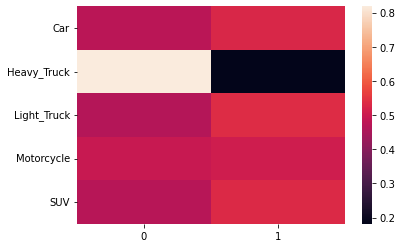


Rate Normalized by Column
                 0      1  Total
Car          0.116  0.148  0.264
Heavy_Truck  0.232  0.059  0.291
Light_Truck  0.084  0.112  0.196
Motorcycle   0.466  0.549  1.015
SUV          0.102  0.132  0.234
Total        1.000  1.000  2.000

BODY_TYP INT_HWY


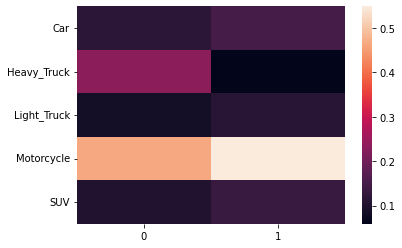


BODY_TYP LGTCON_IM
['Car', 'SUV', 'Light_Truck', 'Heavy_Truck', 'Motorcycle']
['Daylight', 'Dawn_Lighted', 'Dusk', 'Dark']

Count Crashes
              Dark  Dawn_Lighted  Daylight   Dusk   Total
Car          20749         47934    173718   6172  248573
Heavy_Truck   5324         11228     38008   1226   55786
Light_Truck  12392         20091    101758   3027  137268
Motorcycle    1543          2904     11701    530   16678
SUV          13513         33636    134214   4606  185969
Total        53521        115793    459399  15561  644274

Hospitalization Count
              Dark  Dawn_Lighted  Daylight  Dusk   Total
Car           4699          7954     24497   836   37986
Heavy_Truck   1488          4292      9044   436   15260
Light_Truck   2346          2366     10172   376   15260
Motorcycle    1015          1828      6974   341   10158
SUV           2756          4895     16699   596   24946
Total        12304         21335     67386  2585  103610

Hospitalization Rate
           

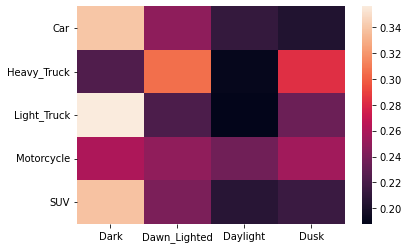


Rate Normalized by Column
              Dark  Dawn_Lighted  Daylight   Dusk  Total
Car          0.145         0.115     0.118  0.098  0.476
Heavy_Truck  0.180         0.265     0.198  0.256  0.899
Light_Truck  0.122         0.082     0.083  0.089  0.376
Motorcycle   0.422         0.437     0.497  0.464  1.820
SUV          0.131         0.101     0.104  0.093  0.429
Total        1.000         1.000     1.000  1.000  4.000

BODY_TYP LGTCON_IM


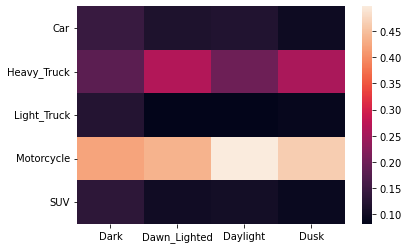


BODY_TYP MONTH
['Car', 'SUV', 'Light_Truck', 'Heavy_Truck', 'Motorcycle']
['Winter', 'Spring_Fall', 'Summer']

Count Crashes
             Spring_Fall  Summer  Winter   Total
Car                83985   85348   79240  248573
Heavy_Truck        18718   19754   17314   55786
Light_Truck        46386   47276   43606  137268
Motorcycle          5516    8118    3044   16678
SUV                62219   65226   58524  185969
Total             216824  225722  201728  644274

Hospitalization Count
             Spring_Fall  Summer  Winter   Total
Car                12675   13480   11831   37986
Heavy_Truck         5201    5410    4649   15260
Light_Truck         5051    5494    4715   15260
Motorcycle          3315    4994    1849   10158
SUV                 8345    9025    7576   24946
Total              34587   38403   30620  103610

Hospitalization Rate
             Spring_Fall  Summer  Winter  Total
Car                0.151   0.158   0.149  0.458
Heavy_Truck        0.278   0.274   0.269  0.821

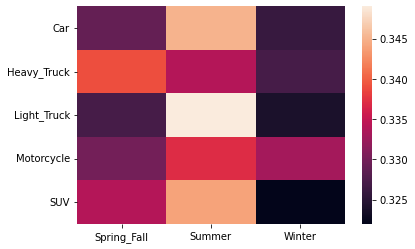


Rate Normalized by Column
             Spring_Fall  Summer  Winter  Total
Car                0.119   0.121   0.118  0.358
Heavy_Truck        0.218   0.210   0.213  0.641
Light_Truck        0.086   0.089   0.086  0.261
Motorcycle         0.472   0.473   0.481  1.426
SUV                0.105   0.106   0.103  0.314
Total              1.000   0.999   1.001  3.000

BODY_TYP MONTH


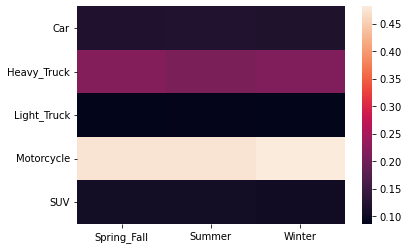


BODY_TYP PEDS
['Car', 'SUV', 'Light_Truck', 'Heavy_Truck', 'Motorcycle']
['0', '1', 'Multiple']

Count Crashes
                  0      1  Multiple   Total
Car          239473   8755       345  248573
Heavy_Truck   30721  23507      1558   55786
Light_Truck  131685   5369       214  137268
Motorcycle    16507    162         9   16678
SUV          174916  10747       306  185969
Total        593302  48540      2432  644274

Hospitalization Count
                 0      1  Multiple   Total
Car          37794    157        35   37986
Heavy_Truck   1011  13348       901   15260
Light_Truck  15191     61         8   15260
Motorcycle   10118     37         3   10158
SUV          24789    136        21   24946
Total        88903  13739       968  103610

Hospitalization Rate
                 0      1  Multiple  Total
Car          0.158  0.018     0.101  0.277
Heavy_Truck  0.033  0.568     0.578  1.179
Light_Truck  0.115  0.011     0.037  0.163
Motorcycle   0.613  0.228     0.333  1.174
SUV  

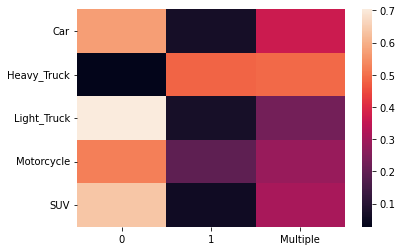


Rate Normalized by Column
                 0      1  Multiple  Total
Car          0.149  0.021     0.091  0.261
Heavy_Truck  0.031  0.677     0.517  1.225
Light_Truck  0.109  0.014     0.033  0.156
Motorcycle   0.578  0.272     0.298  1.148
SUV          0.134  0.015     0.061  0.210
Total        1.001  0.999     1.000  3.000

BODY_TYP PEDS


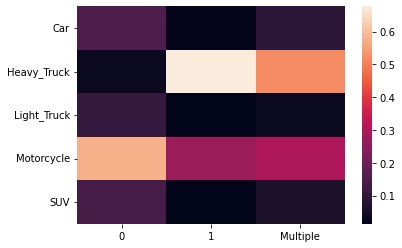


BODY_TYP PERMVIT
['Car', 'SUV', 'Light_Truck', 'Heavy_Truck', 'Motorcycle']
['2', 'Multiple', '1']

Count Crashes
                 1       2  Multiple   Total
Car          24527   81742    142304  248573
Heavy_Truck  25783   16174     13829   55786
Light_Truck  14339   40784     82145  137268
Motorcycle    5821    6931      3926   16678
SUV          19754   58116    108099  185969
Total        90224  203747    350303  644274

Hospitalization Count
                 1      2  Multiple   Total
Car           4953  10712     22321   37986
Heavy_Truck  11890   2088      1282   15260
Light_Truck   2481   3779      9000   15260
Motorcycle    3733   4093      2332   10158
SUV           3041   6677     15228   24946
Total        26098  27349     50163  103610

Hospitalization Rate
                 1      2  Multiple  Total
Car          0.202  0.131     0.157  0.490
Heavy_Truck  0.461  0.129     0.093  0.683
Light_Truck  0.173  0.093     0.110  0.376
Motorcycle   0.641  0.591     0.594  1.826
SU

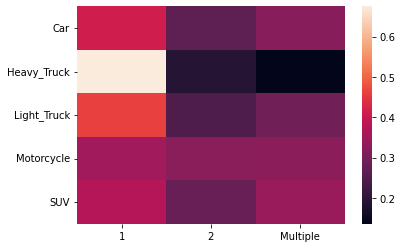


Rate Normalized by Column
                 1      2  Multiple  Total
Car          0.124  0.124     0.143  0.391
Heavy_Truck  0.283  0.122     0.085  0.490
Light_Truck  0.106  0.088     0.100  0.294
Motorcycle   0.393  0.558     0.543  1.494
SUV          0.094  0.109     0.129  0.332
Total        1.000  1.001     1.000  3.001

BODY_TYP PERMVIT


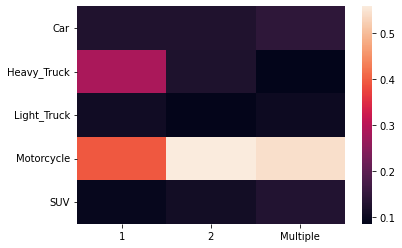


BODY_TYP REL_ROAD
['Car', 'SUV', 'Light_Truck', 'Heavy_Truck', 'Motorcycle']
['On_Road', 'Not_on_Road', 'Parking_Area']

Count Crashes
             Not_on_Road  On_Road  Parking_Area   Total
Car                25939   219779          2855  248573
Heavy_Truck         4685    48747          2354   55786
Light_Truck        13735   121519          2014  137268
Motorcycle          3243    13301           134   16678
SUV                15298   167939          2732  185969
Total              62900   571285         10089  644274

Hospitalization Count
             Not_on_Road  On_Road  Parking_Area   Total
Car                 8460    29143           383   37986
Heavy_Truck         1037    14062           161   15260
Light_Truck         4337    10819           104   15260
Motorcycle          2241     7841            76   10158
SUV                 5065    19554           327   24946
Total              21140    81419          1051  103610

Hospitalization Rate
             Not_on_Road  On_Road  

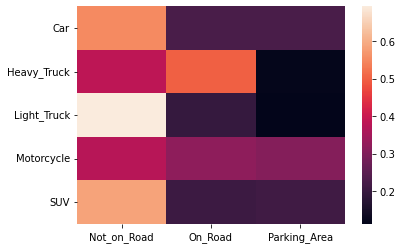


Rate Normalized by Column
             Not_on_Road  On_Road  Parking_Area  Total
Car                0.173    0.109         0.143  0.425
Heavy_Truck        0.117    0.237         0.073  0.427
Light_Truck        0.167    0.073         0.055  0.295
Motorcycle         0.367    0.485         0.603  1.455
SUV                0.176    0.096         0.127  0.399
Total              1.000    1.000         1.001  3.001

BODY_TYP REL_ROAD


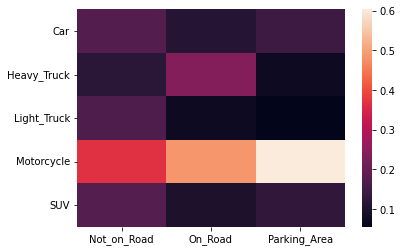


BODY_TYP RELJCT2_IM
['Car', 'SUV', 'Light_Truck', 'Heavy_Truck', 'Motorcycle']
['B', 'A', 'C', 'D']

Count Crashes
                  A       B      C       D   Total
Car           72045   92987  23335   60206  248573
Heavy_Truck    9751   23686   5074   17275   55786
Light_Truck   35517   55742  13346   32663  137268
Motorcycle     4458    7665   1915    2640   16678
SUV           51353   68960  17271   48385  185969
Total        173124  249040  60941  161169  644274

Hospitalization Count
                 A      B     C      D   Total
Car          13981  15560  3002   5443   37986
Heavy_Truck   2377   5474  1194   6215   15260
Light_Truck   4879   7384  1128   1869   15260
Motorcycle    2837   4769  1157   1395   10158
SUV           9085  10197  1941   3723   24946
Total        33159  43384  8422  18645  103610

Hospitalization Rate
                 A      B      C      D  Total
Car          0.194  0.167  0.129  0.090  0.580
Heavy_Truck  0.244  0.231  0.235  0.360  1.070
Light_Truck 

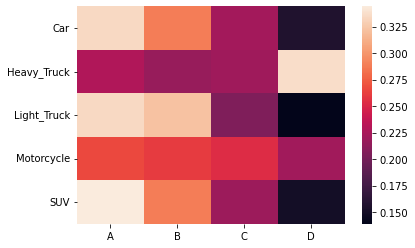


Rate Normalized by Column
                 A      B      C      D  Total
Car          0.140  0.129  0.110  0.081  0.460
Heavy_Truck  0.176  0.178  0.202  0.323  0.879
Light_Truck  0.099  0.102  0.073  0.051  0.325
Motorcycle   0.458  0.478  0.519  0.475  1.930
SUV          0.127  0.114  0.096  0.069  0.406
Total        1.000  1.001  1.000  0.999  4.000

BODY_TYP RELJCT2_IM


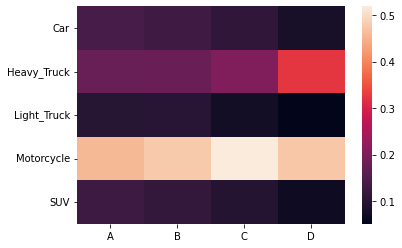


BODY_TYP SCH_BUS
['Car', 'SUV', 'Light_Truck', 'Heavy_Truck', 'Motorcycle']
['0', '1']

Count Crashes
                  0     1   Total
Car          247838   735  248573
Heavy_Truck   55541   245   55786
Light_Truck  135533  1735  137268
Motorcycle    16656    22   16678
SUV          185452   517  185969
Total        641020  3254  644274

Hospitalization Count
                  0    1   Total
Car           37905   81   37986
Heavy_Truck   15176   84   15260
Light_Truck   15110  150   15260
Motorcycle    10147   11   10158
SUV           24871   75   24946
Total        103209  401  103610

Hospitalization Rate
                 0      1  Total
Car          0.153  0.110  0.263
Heavy_Truck  0.273  0.343  0.616
Light_Truck  0.111  0.086  0.197
Motorcycle   0.609  0.500  1.109
SUV          0.134  0.145  0.279
Total        1.280  1.184  2.464

Rate Normalized by Row
                 0      1  Total
Car          0.581  0.419    1.0
Heavy_Truck  0.444  0.556    1.0
Light_Truck  0.563  0.437    

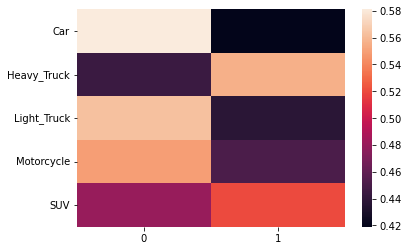


Rate Normalized by Column
                 0      1  Total
Car          0.119  0.093  0.212
Heavy_Truck  0.213  0.289  0.502
Light_Truck  0.087  0.073  0.160
Motorcycle   0.476  0.422  0.898
SUV          0.105  0.122  0.227
Total        1.000  0.999  1.999

BODY_TYP SCH_BUS


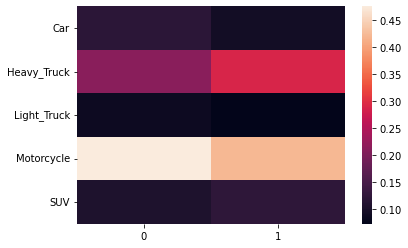


BODY_TYP URBANICITY
['Car', 'SUV', 'Light_Truck', 'Heavy_Truck', 'Motorcycle']
['2', '1']

Count Crashes
                  1       2   Total
Car          196218   52355  248573
Heavy_Truck   44903   10883   55786
Light_Truck   98670   38598  137268
Motorcycle    12462    4216   16678
SUV          151520   34449  185969
Total        503773  140501  644274

Hospitalization Count
                 1      2   Total
Car          28975   9011   37986
Heavy_Truck  13215   2045   15260
Light_Truck  10275   4985   15260
Motorcycle    7724   2434   10158
SUV          19582   5364   24946
Total        79771  23839  103610

Hospitalization Rate
                 1      2  Total
Car          0.148  0.172  0.320
Heavy_Truck  0.294  0.188  0.482
Light_Truck  0.104  0.129  0.233
Motorcycle   0.620  0.577  1.197
SUV          0.129  0.156  0.285
Total        1.295  1.222  2.517

Rate Normalized by Row
                 1      2  Total
Car          0.462  0.538    1.0
Heavy_Truck  0.610  0.390    1.0
Light

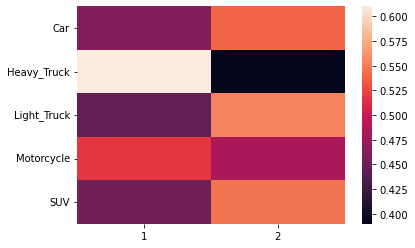


Rate Normalized by Column
                 1      2  Total
Car          0.114  0.141  0.255
Heavy_Truck  0.227  0.154  0.381
Light_Truck  0.080  0.106  0.186
Motorcycle   0.479  0.472  0.951
SUV          0.100  0.127  0.227
Total        1.000  1.000  2.000

BODY_TYP URBANICITY


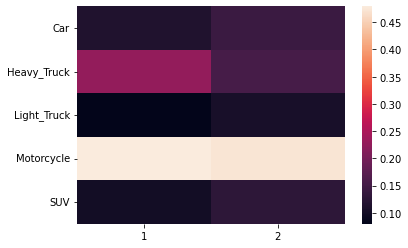


BODY_TYP VE_TOTAL
['Car', 'SUV', 'Light_Truck', 'Heavy_Truck', 'Motorcycle']
['2', '1', 'Multiple', '3']

Count Crashes
                  1       2      3  Multiple   Total
Car           35654  176138  27696      9085  248573
Heavy_Truck   27219   24505   3011      1051   55786
Light_Truck   20327   95704  15775      5462  137268
Motorcycle     6761    9073    713       131   16678
SUV           27744  128586  22018      7621  185969
Total        117705  434006  69213     23350  644274

Hospitalization Count
                 1      2      3  Multiple   Total
Car           7916  23431   4879      1760   37986
Heavy_Truck  13909   1020    214       117   15260
Light_Truck   4095   8598   1861       706   15260
Motorcycle    4329   5339    419        71   10158
SUV           4887  15360   3336      1363   24946
Total        35136  53748  10709      4017  103610

Hospitalization Rate
                 1      2      3  Multiple  Total
Car          0.222  0.133  0.176     0.194  0.725
Heavy_

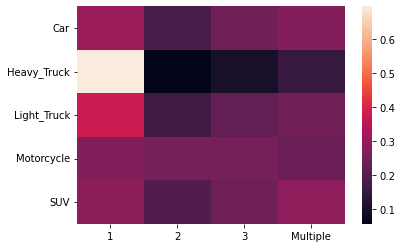


Rate Normalized by Column
                 1      2      3  Multiple  Total
Car          0.127  0.137  0.160     0.168  0.592
Heavy_Truck  0.292  0.043  0.064     0.096  0.495
Light_Truck  0.115  0.092  0.107     0.112  0.426
Motorcycle   0.366  0.605  0.532     0.469  1.972
SUV          0.101  0.123  0.137     0.155  0.516
Total        1.001  1.000  1.000     1.000  4.001

BODY_TYP VE_TOTAL


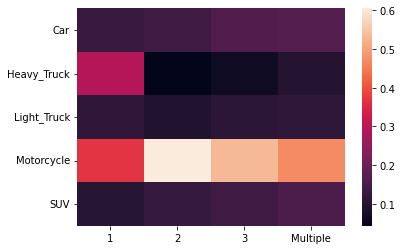


BODY_TYP WEATHR_IM
['Car', 'SUV', 'Light_Truck', 'Heavy_Truck', 'Motorcycle']
['B', 'A', 'D', 'C', 'E']

Count Crashes
                A       B      C      D      E   Total
Car          1126  179870  24870  38602   4105  248573
Heavy_Truck   284   41909   4800   7811    982   55786
Light_Truck   763   99874  12729  21333   2569  137268
Motorcycle     42   14233    539   1827     37   16678
SUV           848  136682  16967  27878   3594  185969
Total        3063  472568  59905  97451  11287  644274

Hospitalization Count
               A      B     C      D     E   Total
Car          240  27144  3991   6090   521   37986
Heavy_Truck   59  11829  1349   1871   152   15260
Light_Truck  144  10804  1568   2470   274   15260
Motorcycle    27   8656   295   1160    20   10158
SUV          166  18239  2370   3723   448   24946
Total        636  76672  9573  15314  1415  103610

Hospitalization Rate
                 A      B      C      D      E  Total
Car          0.213  0.151  0.160  0.158

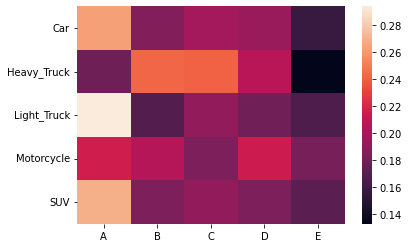


Rate Normalized by Column
                 A      B      C      D      E  Total
Car          0.147  0.118  0.128  0.123  0.120  0.636
Heavy_Truck  0.143  0.220  0.225  0.187  0.147  0.922
Light_Truck  0.130  0.084  0.098  0.090  0.101  0.503
Motorcycle   0.444  0.474  0.437  0.495  0.513  2.363
SUV          0.135  0.104  0.112  0.104  0.118  0.573
Total        0.999  1.000  1.000  0.999  0.999  4.997

BODY_TYP WEATHR_IM


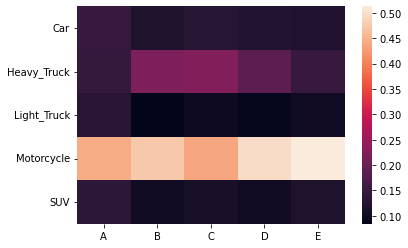


BODY_TYP WKDY_IM
['Car', 'SUV', 'Light_Truck', 'Heavy_Truck', 'Motorcycle']
['Weekday', 'Weekend']

Count Crashes
             Weekday  Weekend   Total
Car           185956    62617  248573
Heavy_Truck    44939    10847   55786
Light_Truck   103807    33461  137268
Motorcycle     10457     6221   16678
SUV           139398    46571  185969
Total         484557   159717  644274

Hospitalization Count
             Weekday  Weekend   Total
Car            27553    10433   37986
Heavy_Truck    11686     3574   15260
Light_Truck    11073     4187   15260
Motorcycle      6221     3937   10158
SUV            18051     6895   24946
Total          74584    29026  103610

Hospitalization Rate
             Weekday  Weekend  Total
Car            0.148    0.167  0.315
Heavy_Truck    0.260    0.329  0.589
Light_Truck    0.107    0.125  0.232
Motorcycle     0.595    0.633  1.228
SUV            0.129    0.148  0.277
Total          1.239    1.402  2.641

Rate Normalized by Row
             Weekday  Wee

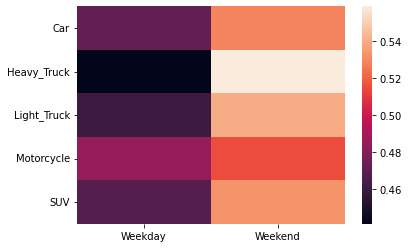


Rate Normalized by Column
             Weekday  Weekend  Total
Car            0.120    0.119  0.239
Heavy_Truck    0.210    0.235  0.445
Light_Truck    0.086    0.089  0.175
Motorcycle     0.480    0.451  0.931
SUV            0.104    0.106  0.210
Total          1.000    1.000  2.000

BODY_TYP WKDY_IM


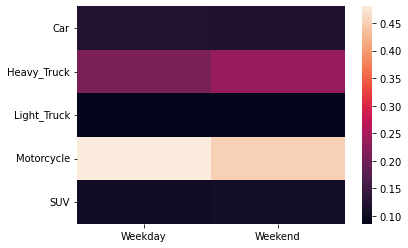


BODY_TYP WRK_ZONE
['Car', 'SUV', 'Light_Truck', 'Heavy_Truck', 'Motorcycle']
['0', '1', '2', '3']

Count Crashes
                  0      1    2    3   Total
Car          244143   4066  308   56  248573
Heavy_Truck   54316   1345   96   29   55786
Light_Truck  134341   2679  196   52  137268
Motorcycle    16411    252   14    1   16678
SUV          182567   3183  177   42  185969
Total        631778  11525  791  180  644274

Hospitalization Count
                  0     1    2   3   Total
Car           37426   511   39  10   37986
Heavy_Truck   15086   157   10   7   15260
Light_Truck   14989   234   28   9   15260
Motorcycle    10019   129    9   1   10158
SUV           24513   394   29  10   24946
Total        102033  1425  115  37  103610

Hospitalization Rate
                 0      1      2      3  Total
Car          0.153  0.126  0.127  0.179  0.585
Heavy_Truck  0.278  0.117  0.104  0.241  0.740
Light_Truck  0.112  0.087  0.143  0.173  0.515
Motorcycle   0.611  0.512  0.643  1.0

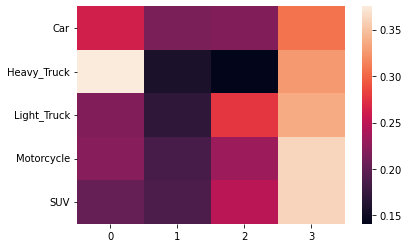


Rate Normalized by Column
                 0      1      2      3  Total
Car          0.119  0.130  0.107  0.098  0.454
Heavy_Truck  0.216  0.121  0.088  0.132  0.557
Light_Truck  0.087  0.090  0.121  0.095  0.393
Motorcycle   0.474  0.530  0.545  0.546  2.095
SUV          0.104  0.128  0.139  0.130  0.501
Total        1.000  0.999  1.000  1.001  4.000

BODY_TYP WRK_ZONE


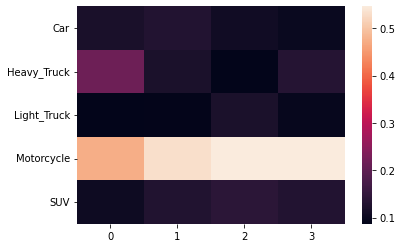


MAKE HOUR_IM
['B', 'E', 'G', 'F', 'I', 'D', 'A', 'C', 'H']
['Mid_Day', 'Early_Eve', 'Early_Morn', 'Evening', 'Morning', 'Rush_Hour', 'Late_Nght']

Count Crashes
       Early_Eve  Early_Morn  Evening  Late_Nght  Mid_Day  Morning  Rush_Hour  \
A           1841         386     1572       1032     3030     1361       3135   
B          10652        3013     8826       5696    21430    15198      24363   
C          13199        3692    10539       6979    25736    17870      28749   
D          10644        3527     8662       6168    21717    14749      23766   
E          10005        2709     7723       4877    19616    14203      21461   
F          14074        4517    10948       7513    29970    21449      32549   
G           8858        2670     6936       4900    18444    12937      20123   
H           2120         581     1492        989     4811     3625       5076   
I           6141        2599     6117       4810    11397     9562      10940   
Total      77534       23694

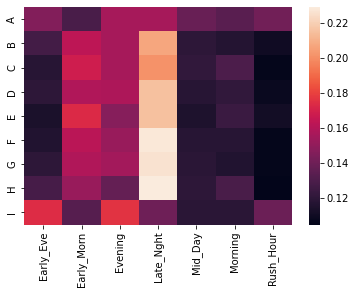


Rate Normalized by Column
       Early_Eve  Early_Morn  Evening  Late_Nght  Mid_Day  Morning  Rush_Hour  \
A          0.319       0.260    0.296      0.249    0.331    0.320      0.343   
B          0.089       0.105    0.095      0.106    0.092    0.090      0.086   
C          0.075       0.098    0.086      0.094    0.084    0.090      0.075   
D          0.072       0.087    0.082      0.094    0.077    0.079      0.072   
E          0.065       0.091    0.073      0.090    0.071    0.077      0.070   
F          0.065       0.083    0.074      0.093    0.072    0.072      0.066   
G          0.063       0.076    0.070      0.086    0.068    0.066      0.061   
H          0.054       0.059    0.050      0.071    0.056    0.059      0.049   
I          0.199       0.140    0.175      0.117    0.149    0.148      0.177   
Total      1.001       0.999    1.001      1.000    1.000    1.001      0.999   

       Total  
A      2.118  
B      0.663  
C      0.602  
D      0.563  
E     

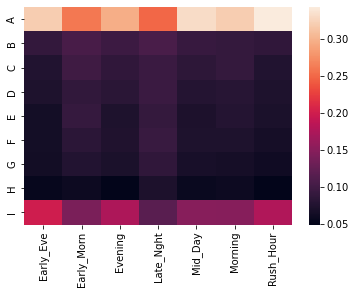


MAKE INT_HWY
['B', 'E', 'G', 'F', 'I', 'D', 'A', 'C', 'H']
[0, 1]

Count Crashes
            0      1   Total
A       11247   1110   12357
B       80979   8199   89178
C       96525  10239  106764
D       80643   8590   89233
E       72413   8181   80594
F      108794  12226  121020
G       67127   7741   74868
H       16586   2108   18694
I       45827   5739   51566
Total  580141  64133  644274

Hospitalization Count
           0     1   Total
A       6499   663    7162
B      13477  1406   14883
C      14484  1707   16191
D      11257  1401   12658
E       9469  1279   10748
F      14059  1709   15768
G       8140  1010    9150
H       1648   199    1847
I      14811   392   15203
Total  93844  9766  103610

Hospitalization Rate
           0      1  Total
A      0.578  0.597  1.175
B      0.166  0.171  0.337
C      0.150  0.167  0.317
D      0.140  0.163  0.303
E      0.131  0.156  0.287
F      0.129  0.140  0.269
G      0.121  0.130  0.251
H      0.099  0.094  0.193
I      0.323  

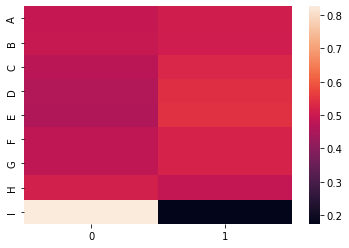


Rate Normalized by Column
           0      1  Total
A      0.314  0.354  0.668
B      0.091  0.102  0.193
C      0.082  0.099  0.181
D      0.076  0.097  0.173
E      0.071  0.093  0.164
F      0.070  0.083  0.153
G      0.066  0.077  0.143
H      0.054  0.056  0.110
I      0.176  0.040  0.216
Total  1.000  1.001  2.001

MAKE INT_HWY


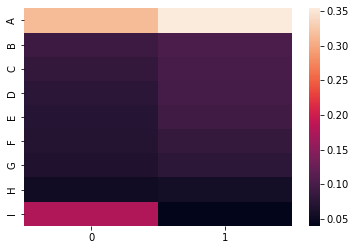


MAKE LGTCON_IM
['B', 'E', 'G', 'F', 'I', 'D', 'A', 'C', 'H']
['Daylight', 'Dawn_Lighted', 'Dusk', 'Dark']

Count Crashes
        Dark  Dawn_Lighted  Daylight   Dusk   Total
A       1166          2130      8664    397   12357
B       7020         15790     64237   2131   89178
C       8169         19797     76069   2729  106764
D       8425         15667     63080   2061   89233
E       5502         14922     58120   2050   80594
F      10514         19973     87729   2804  121020
G       6388         12741     54011   1728   74868
H       1386          2950     13910    448   18694
I       4951         11823     33579   1213   51566
Total  53521        115793    459399  15561  644274

Hospitalization Count
        Dark  Dawn_Lighted  Daylight  Dusk   Total
A        744          1253      4923   242    7162
B       1731          2852      9959   341   14883
C       1801          3336     10644   410   16191
D       1842          2424      8123   269   12658
E       1179          2184  

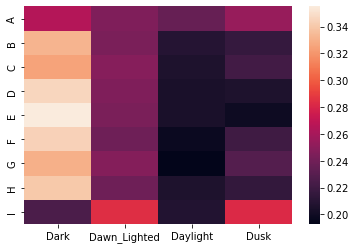


Rate Normalized by Column
        Dark  Dawn_Lighted  Daylight   Dusk  Total
A      0.269         0.295     0.334  0.322  1.220
B      0.104         0.091     0.091  0.085  0.371
C      0.093         0.084     0.082  0.079  0.338
D      0.092         0.078     0.076  0.069  0.315
E      0.090         0.073     0.072  0.063  0.298
F      0.087         0.072     0.070  0.069  0.298
G      0.079         0.070     0.065  0.069  0.283
H      0.064         0.054     0.054  0.051  0.223
I      0.122         0.184     0.157  0.192  0.655
Total  1.000         1.001     1.001  0.999  4.001

MAKE LGTCON_IM


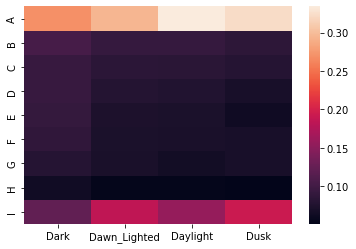


MAKE MONTH
['B', 'E', 'G', 'F', 'I', 'D', 'A', 'C', 'H']
['Winter', 'Spring_Fall', 'Summer']

Count Crashes
       Spring_Fall  Summer  Winter   Total
A             4079    5984    2294   12357
B            29898   31377   27903   89178
C            35954   37234   33576  106764
D            30252   30482   28499   89233
E            27164   28050   25380   80594
F            40736   41949   38335  121020
G            25150   26117   23601   74868
H             6201    6463    6030   18694
I            17390   18066   16110   51566
Total       216824  225722  201728  644274

Hospitalization Count
       Spring_Fall  Summer  Winter   Total
A             2364    3581    1217    7162
B             4931    5722    4230   14883
C             5450    5815    4926   16191
D             4237    4479    3942   12658
E             3602    3832    3314   10748
F             5278    5606    4884   15768
G             2903    3331    2916    9150
H              615     646     586    1847
I       

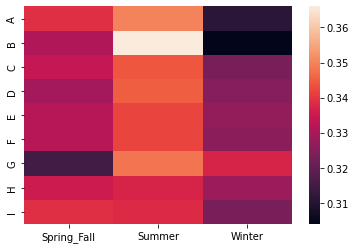


Rate Normalized by Column
       Spring_Fall  Summer  Winter  Total
A            0.320   0.318   0.306  0.944
B            0.091   0.097   0.088  0.276
C            0.084   0.083   0.085  0.252
D            0.077   0.078   0.080  0.235
E            0.073   0.073   0.075  0.221
F            0.071   0.071   0.074  0.216
G            0.064   0.068   0.071  0.203
H            0.055   0.053   0.056  0.164
I            0.165   0.159   0.165  0.489
Total        1.000   1.000   1.000  3.000

MAKE MONTH


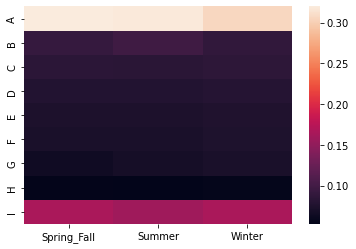


MAKE PEDS
['B', 'E', 'G', 'F', 'I', 'D', 'A', 'C', 'H']
['0', '1', 'Multiple']

Count Crashes
            0      1  Multiple   Total
A       12236    115         6   12357
B       85389   3671       118   89178
C      102422   4183       159  106764
D       85697   3395       141   89233
E       76650   3836       108   80594
F      115970   4870       180  121020
G       71549   3188       131   74868
H       17834    833        27   18694
I       25555  24449      1562   51566
Total  593302  48540      2432  644274

Hospitalization Count
           0      1  Multiple   Total
A       7137     24         1    7162
B      14809     65         9   14883
C      16113     69         9   16191
D      12584     61        13   12658
E      10690     50         8   10748
F      15675     74        19   15768
G       9098     45         7    9150
H       1839      4         4    1847
I        958  13347       898   15203
Total  88903  13739       968  103610

Hospitalization Rate
           0 

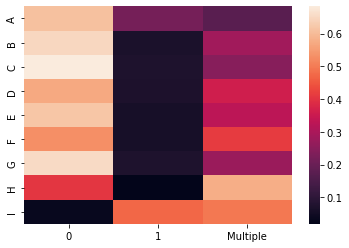


Rate Normalized by Column
           0      1  Multiple  Total
A      0.364  0.244     0.124  0.732
B      0.108  0.021     0.057  0.186
C      0.098  0.019     0.042  0.159
D      0.092  0.021     0.068  0.181
E      0.087  0.015     0.055  0.157
F      0.084  0.018     0.078  0.180
G      0.079  0.017     0.040  0.136
H      0.064  0.006     0.110  0.180
I      0.023  0.639     0.427  1.089
Total  0.999  1.000     1.001  3.000

MAKE PEDS


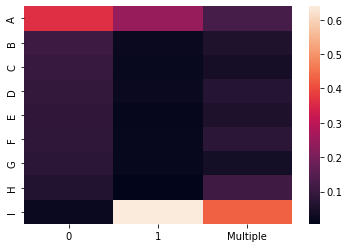


MAKE PERMVIT
['B', 'E', 'G', 'F', 'I', 'D', 'A', 'C', 'H']
['2', 'Multiple', '1']

Count Crashes
           1       2  Multiple   Total
A       4117    4860      3380   12357
B      10081   28653     50444   89178
C       9480   32691     64593  106764
D       9996   28247     50990   89233
E       7366   25735     47493   80594
F      13035   38961     69024  121020
G       7692   22911     44265   74868
H       2102    6696      9896   18694
I      26355   14993     10218   51566
Total  90224  203747    350303  644274

Hospitalization Count
           1      2  Multiple   Total
A       2622   2800      1740    7162
B       2624   4356      7903   14883
C       1817   4383      9991   16191
D       1946   3448      7264   12658
E       1246   2986      6516   10748
F       2359   4322      9087   15768
G       1285   2390      5475    9150
H        303    511      1033    1847
I      11896   2153      1154   15203
Total  26098  27349     50163  103610

Hospitalization Rate
          

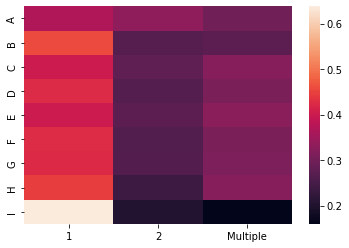


Rate Normalized by Column
           1      2  Multiple  Total
A      0.266  0.375     0.326  0.967
B      0.109  0.099     0.099  0.307
C      0.080  0.087     0.098  0.265
D      0.081  0.079     0.090  0.250
E      0.071  0.076     0.087  0.234
F      0.076  0.072     0.083  0.231
G      0.070  0.068     0.078  0.216
H      0.060  0.050     0.066  0.176
I      0.188  0.094     0.072  0.354
Total  1.001  1.000     0.999  3.000

MAKE PERMVIT


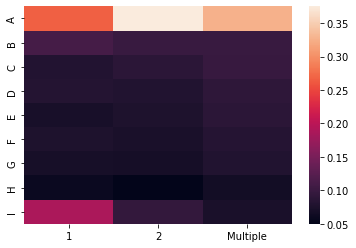


MAKE REL_ROAD
['B', 'E', 'G', 'F', 'I', 'D', 'A', 'C', 'H']
['On_Road', 'Not_on_Road', 'Parking_Area']

Count Crashes
       Not_on_Road  On_Road  Parking_Area   Total
A             2417     9853            87   12357
B             8971    79006          1201   89178
C             9089    96440          1235  106764
D             9930    78099          1204   89233
E             6264    73358           972   80594
F            12977   106327          1716  121020
G             7401    66465          1002   74868
H             1729    16653           312   18694
I             4122    45084          2360   51566
Total        62900   571285         10089  644274

Hospitalization Count
       Not_on_Road  On_Road  Parking_Area   Total
A             1655     5454            53    7162
B             3230    11501           152   14883
C             3040    12979           172   16191
D             3342     9183           133   12658
E             2027     8623            98   10748
F       

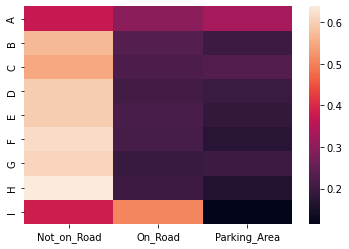


Rate Normalized by Column
       Not_on_Road  On_Road  Parking_Area  Total
A            0.216    0.331         0.430  0.977
B            0.114    0.087         0.089  0.290
C            0.106    0.080         0.098  0.284
D            0.106    0.070         0.078  0.254
E            0.102    0.070         0.071  0.243
F            0.099    0.065         0.062  0.226
G            0.100    0.060         0.073  0.233
H            0.083    0.049         0.048  0.180
I            0.074    0.187         0.050  0.311
Total        1.000    0.999         0.999  2.998

MAKE REL_ROAD


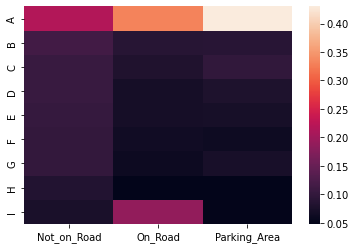


MAKE RELJCT2_IM
['B', 'E', 'G', 'F', 'I', 'D', 'A', 'C', 'H']
['B', 'A', 'C', 'D']

Count Crashes
            A       B      C       D   Total
A        3220    5736   1424    1977   12357
B       25678   33568   8316   21616   89178
C       30704   39003  10379   26678  106764
D       24466   35168   8582   21017   89233
E       22991   29484   7394   20725   80594
F       32277   47747  11575   29421  121020
G       20230   29344   7087   18207   74868
H        4931    7447   1695    4621   18694
I        8627   21543   4489   16907   51566
Total  173124  249040  60941  161169  644274

Hospitalization Count
           A      B     C      D   Total
A       1923   3443   831    965    7162
B       5356   6183  1268   2076   14883
C       6173   6288  1344   2386   16191
D       4157   5837   994   1670   12658
E       4109   4276   772   1591   10748
F       5357   7085  1190   2136   15768
G       3071   4090   694   1295    9150
H        607    822   127    291    1847
I       2406  

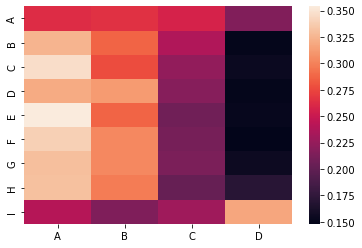


Rate Normalized by Column
           A      B      C      D  Total
A      0.288  0.315  0.358  0.347  1.308
B      0.101  0.097  0.094  0.068  0.360
C      0.097  0.085  0.079  0.064  0.325
D      0.082  0.087  0.071  0.057  0.297
E      0.086  0.076  0.064  0.055  0.281
F      0.080  0.078  0.063  0.052  0.273
G      0.073  0.073  0.060  0.051  0.257
H      0.059  0.058  0.046  0.045  0.208
I      0.134  0.131  0.164  0.262  0.691
Total  1.000  1.000  0.999  1.001  4.000

MAKE RELJCT2_IM


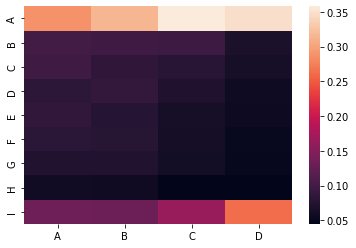


MAKE SCH_BUS
['B', 'E', 'G', 'F', 'I', 'D', 'A', 'C', 'H']
['0', '1']

Count Crashes
            0     1   Total
A       12346    11   12357
B       88927   251   89178
C      106471   293  106764
D       88852   381   89233
E       80355   239   80594
F      120596   424  121020
G       74591   277   74868
H       18252   442   18694
I       50630   936   51566
Total  641020  3254  644274

Hospitalization Count
            0    1   Total
A        7157    5    7162
B       14859   24   14883
C       16158   33   16191
D       12614   44   12658
E       10723   25   10748
F       15691   77   15768
G        9118   32    9150
H        1816   31    1847
I       15073  130   15203
Total  103209  401  103610

Hospitalization Rate
           0      1  Total
A      0.580  0.455  1.035
B      0.167  0.096  0.263
C      0.152  0.113  0.265
D      0.142  0.115  0.257
E      0.133  0.105  0.238
F      0.130  0.182  0.312
G      0.122  0.116  0.238
H      0.099  0.070  0.169
I      0.298  0.139  

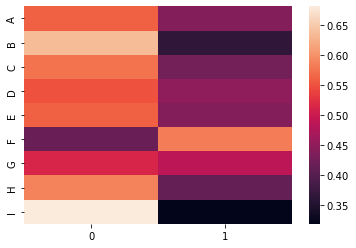


Rate Normalized by Column
           0      1  Total
A      0.318  0.327  0.645
B      0.092  0.069  0.161
C      0.083  0.081  0.164
D      0.078  0.083  0.161
E      0.073  0.075  0.148
F      0.071  0.131  0.202
G      0.067  0.083  0.150
H      0.055  0.050  0.105
I      0.163  0.100  0.263
Total  1.000  0.999  1.999

MAKE SCH_BUS


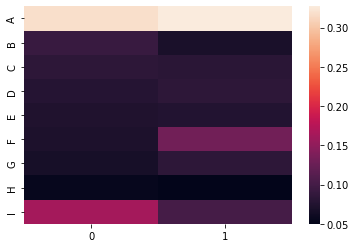


MAKE URBANICITY
['B', 'E', 'G', 'F', 'I', 'D', 'A', 'C', 'H']
['2', '1']

Count Crashes
            1       2   Total
A        9032    3325   12357
B       70813   18365   89178
C       85585   21179  106764
D       65385   23848   89233
E       66822   13772   80594
F       91566   29454  121020
G       56897   17971   74868
H       15197    3497   18694
I       42476    9090   51566
Total  503773  140501  644274

Hospitalization Count
           1      2   Total
A       5315   1847    7162
B      11426   3457   14883
C      12604   3587   16191
D       8899   3759   12658
E       8700   2048   10748
F      11494   4274   15768
G       6656   2494    9150
H       1424    423    1847
I      13253   1950   15203
Total  79771  23839  103610

Hospitalization Rate
           1      2  Total
A      0.588  0.555  1.143
B      0.161  0.188  0.349
C      0.147  0.169  0.316
D      0.136  0.158  0.294
E      0.130  0.149  0.279
F      0.126  0.145  0.271
G      0.117  0.139  0.256
H      0.094

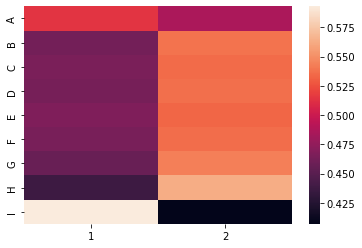


Rate Normalized by Column
           1      2  Total
A      0.325  0.302  0.627
B      0.089  0.102  0.191
C      0.081  0.092  0.173
D      0.075  0.086  0.161
E      0.072  0.081  0.153
F      0.069  0.079  0.148
G      0.065  0.075  0.140
H      0.052  0.066  0.118
I      0.172  0.117  0.289
Total  1.000  1.000  2.000

MAKE URBANICITY


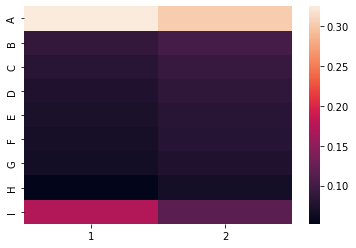


MAKE VE_TOTAL
['B', 'E', 'G', 'F', 'I', 'D', 'A', 'C', 'H']
['2', '1', 'Multiple', '3']

Count Crashes
            1       2      3  Multiple   Total
A        4928    6687    588       154   12357
B       13915   61908  10057      3298   89178
C       13906   76403  12298      4157  106764
D       14600   61677   9718      3238   89233
E       10161   57243   9836      3354   80594
F       18879   84053  13507      4581  121020
G       11327   52054   8483      3004   74868
H        2674   13133   2161       726   18694
I       27315   20848   2565       838   51566
Total  117705  434006  69213     23350  644274

Hospitalization Count
           1      2      3  Multiple   Total
A       3117   3669    305        71    7162
B       3670   8865   1781       567   14883
C       2819  10419   2143       810   16191
D       3229   7279   1540       610   12658
E       1872   6770   1492       614   10748
F       3962   9221   1876       709   15768
G       2176   5357   1169       448    9

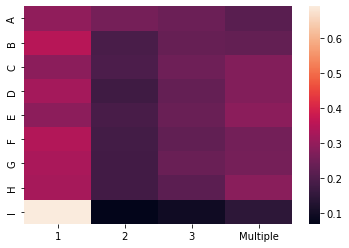


Rate Normalized by Column
           1      2      3  Multiple  Total
A      0.246  0.388  0.318     0.264  1.216
B      0.103  0.101  0.109     0.098  0.411
C      0.079  0.097  0.107     0.112  0.395
D      0.086  0.084  0.097     0.108  0.375
E      0.072  0.084  0.093     0.105  0.354
F      0.082  0.078  0.085     0.089  0.334
G      0.075  0.073  0.085     0.085  0.318
H      0.061  0.060  0.063     0.078  0.262
I      0.198  0.036  0.043     0.061  0.338
Total  1.002  1.001  1.000     1.000  4.003

MAKE VE_TOTAL


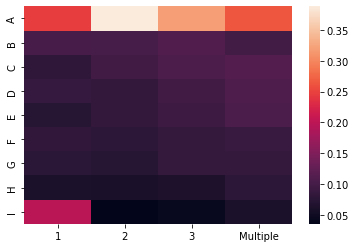


MAKE WEATHR_IM
['B', 'E', 'G', 'F', 'I', 'D', 'A', 'C', 'H']
['B', 'A', 'D', 'C', 'E']

Count Crashes
          A       B      C      D      E   Total
A        33   10558    403   1304     59   12357
B       366   65049   8193  13951   1619   89178
C       439   78707  10188  15909   1521  106764
D       499   64216   8591  14093   1834   89233
E       326   59668   7627  11809   1164   80594
F       711   86880  11949  19071   2409  121020
G       351   54752   6892  11481   1392   74868
H        81   13674   1614   2873    452   18694
I       257   39064   4448   6960    837   51566
Total  3063  472568  59905  97451  11287  644274

Hospitalization Count
         A      B     C      D     E   Total
A       19   6165   184    775    19    7162
B       71  11048  1275   2297   192   14883
C       77  11824  1583   2515   192   16191
D      103   9008  1276   2009   262   12658
E       61   7810  1132   1619   126   10748
F      150  11117  1711   2504   286   15768
G       85   6587   

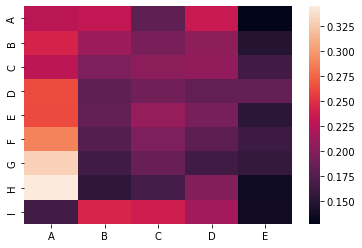


Rate Normalized by Column
           A      B      C      D      E  Total
A      0.261  0.321  0.262  0.323  0.247  1.414
B      0.088  0.093  0.089  0.090  0.091  0.451
C      0.079  0.083  0.089  0.086  0.097  0.434
D      0.093  0.077  0.085  0.078  0.110  0.443
E      0.085  0.072  0.085  0.075  0.083  0.400
F      0.096  0.070  0.082  0.071  0.091  0.410
G      0.110  0.066  0.078  0.066  0.088  0.408
H      0.095  0.051  0.058  0.066  0.063  0.333
I      0.093  0.166  0.170  0.146  0.129  0.704
Total  1.000  0.999  0.998  1.001  0.999  4.997

MAKE WEATHR_IM


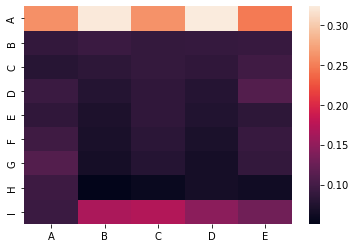


MAKE WKDY_IM
['B', 'E', 'G', 'F', 'I', 'D', 'A', 'C', 'H']
['Weekday', 'Weekend']

Count Crashes
       Weekday  Weekend   Total
A         7651     4706   12357
B        66890    22288   89178
C        79831    26933  106764
D        66942    22291   89233
E        60261    20333   80594
F        91599    29421  121020
G        56114    18754   74868
H        14398     4296   18694
I        40871    10695   51566
Total   484557   159717  644274

Hospitalization Count
       Weekday  Weekend   Total
A         4274     2888    7162
B        10595     4288   14883
C        11733     4458   16191
D         9197     3461   12658
E         7800     2948   10748
F        11436     4332   15768
G         6565     2585    9150
H         1364      483    1847
I        11620     3583   15203
Total    74584    29026  103610

Hospitalization Rate
       Weekday  Weekend  Total
A        0.559    0.614  1.173
B        0.158    0.192  0.350
C        0.147    0.166  0.313
D        0.137    0.155  0.29

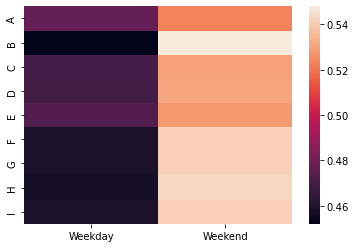


Rate Normalized by Column
       Weekday  Weekend  Total
A        0.319    0.306  0.625
B        0.090    0.096  0.186
C        0.084    0.083  0.167
D        0.078    0.077  0.155
E        0.074    0.072  0.146
F        0.071    0.073  0.144
G        0.067    0.069  0.136
H        0.054    0.056  0.110
I        0.162    0.167  0.329
Total    0.999    0.999  1.998

MAKE WKDY_IM


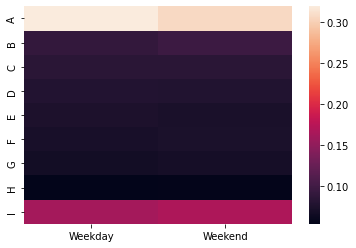


MAKE WRK_ZONE
['B', 'E', 'G', 'F', 'I', 'D', 'A', 'C', 'H']
['0', '1', '2', '3']

Count Crashes
            0      1    2    3   Total
A       12145    196   12    4   12357
B       87530   1515  101   32   89178
C      104799   1817  136   12  106764
D       87623   1485   99   26   89233
E       79089   1427   60   18   80594
F      118537   2252  186   45  121020
G       73412   1349   90   17   74868
H       18284    380   25    5   18694
I       50359   1104   82   21   51566
Total  631778  11525  791  180  644274

Hospitalization Count
            0     1    2   3   Total
A        7059    96    7   0    7162
B       14652   212   13   6   14883
C       15923   240   26   2   16191
D       12451   184   17   6   12658
E       10583   157    5   3   10748
F       15488   248   19  13   15768
G        9017   114   18   1    9150
H        1824    22    1   0    1847
I       15036   152    9   6   15203
Total  102033  1425  115  37  103610

Hospitalization Rate
           0      1   

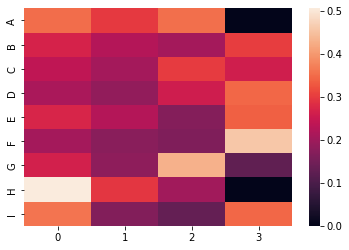


Rate Normalized by Column
           0      1      2      3  Total
A      0.318  0.353  0.362  0.000  1.033
B      0.092  0.101  0.080  0.135  0.408
C      0.083  0.095  0.119  0.120  0.417
D      0.078  0.089  0.107  0.167  0.441
E      0.073  0.079  0.052  0.120  0.324
F      0.071  0.079  0.063  0.209  0.422
G      0.067  0.061  0.124  0.042  0.294
H      0.055  0.042  0.025  0.000  0.122
I      0.163  0.099  0.068  0.206  0.536
Total  1.000  0.998  1.000  0.999  3.997

MAKE WRK_ZONE


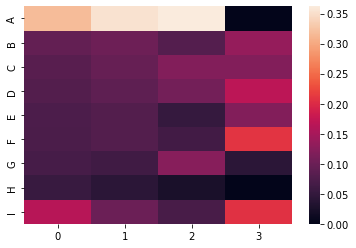


HOUR_IM INT_HWY
['Mid_Day', 'Early_Eve', 'Early_Morn', 'Evening', 'Morning', 'Rush_Hour', 'Late_Nght']
[0, 1]

Count Crashes
                 0      1   Total
Early_Eve    70703   6831   77534
Early_Morn   19893   3801   23694
Evening      56891   5924   62815
Late_Nght    36573   6391   42964
Mid_Day     142525  13626  156151
Morning      99483  11471  110954
Rush_Hour   154073  16089  170162
Total       580141  64133  644274

Hospitalization Count
                0     1   Total
Early_Eve   11579   921   12500
Early_Morn   3954   697    4651
Evening     11489  1134   12623
Late_Nght    9196  1642   10838
Mid_Day     21198  1808   23006
Morning     14872  1605   16477
Rush_Hour   21556  1959   23515
Total       93844  9766  103610

Hospitalization Rate
                0      1  Total
Early_Eve   0.164  0.135  0.299
Early_Morn  0.199  0.183  0.382
Evening     0.202  0.191  0.393
Late_Nght   0.251  0.257  0.508
Mid_Day     0.149  0.133  0.282
Morning     0.149  0.140  0.289
Rush_Hour  

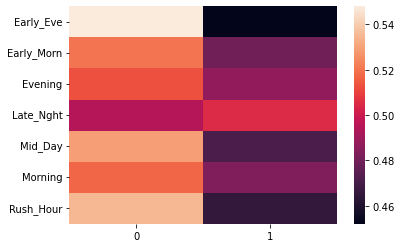


Rate Normalized by Column
                0      1  Total
Early_Eve   0.131  0.116  0.247
Early_Morn  0.158  0.158  0.316
Evening     0.161  0.165  0.326
Late_Nght   0.201  0.221  0.422
Mid_Day     0.119  0.114  0.233
Morning     0.119  0.121  0.240
Rush_Hour   0.112  0.105  0.217
Total       1.001  1.000  2.001

HOUR_IM INT_HWY


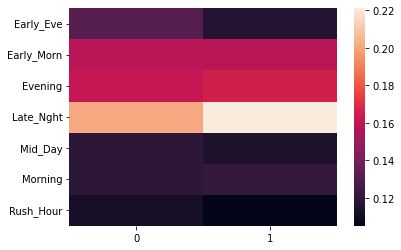


HOUR_IM LGTCON_IM
['Mid_Day', 'Early_Eve', 'Early_Morn', 'Evening', 'Morning', 'Rush_Hour', 'Late_Nght']
['Daylight', 'Dawn_Lighted', 'Dusk', 'Dark']

Count Crashes
             Dark  Dawn_Lighted  Daylight   Dusk   Total
Early_Eve   10969         25794     33955   6816   77534
Early_Morn   5037         10890      7740     27   23694
Evening     18009         38847      3493   2466   62815
Late_Nght   14984         27414       552     14   42964
Mid_Day        27            91    156025      8  156151
Morning       633          3743    106559     19  110954
Rush_Hour    3862          9014    151075   6211  170162
Total       53521        115793    459399  15561  644274

Hospitalization Count
             Dark  Dawn_Lighted  Daylight  Dusk   Total
Early_Eve    1995          3875      5453  1177   12500
Early_Morn   1130          2200      1319     2    4651
Evening      4270          7098       695   560   12623
Late_Nght    4235          6518        83     2   10838
Mid_Day         5 

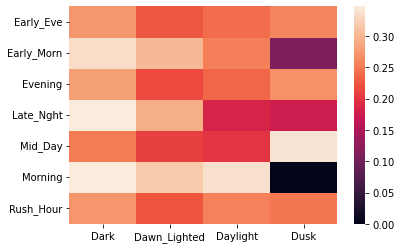


Rate Normalized by Column
             Dark  Dawn_Lighted  Daylight   Dusk  Total
Early_Eve   0.129         0.126     0.144  0.172  0.571
Early_Morn  0.159         0.170     0.153  0.074  0.556
Evening     0.168         0.154     0.178  0.227  0.727
Late_Nght   0.200         0.200     0.135  0.143  0.678
Mid_Day     0.131         0.129     0.132  0.249  0.641
Morning     0.108         0.118     0.133  0.000  0.359
Rush_Hour   0.105         0.103     0.125  0.135  0.468
Total       1.000         1.000     1.000  1.000  4.000

HOUR_IM LGTCON_IM


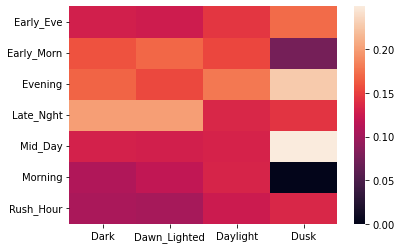


HOUR_IM MONTH
['Mid_Day', 'Early_Eve', 'Early_Morn', 'Evening', 'Morning', 'Rush_Hour', 'Late_Nght']
['Winter', 'Spring_Fall', 'Summer']

Count Crashes
            Spring_Fall  Summer  Winter   Total
Early_Eve         25969   24744   26821   77534
Early_Morn         8213    7449    8032   23694
Evening           20880   23759   18176   62815
Late_Nght         14344   15644   12976   42964
Mid_Day           51863   57005   47283  156151
Morning           37870   36716   36368  110954
Rush_Hour         57685   60405   52072  170162
Total            216824  225722  201728  644274

Hospitalization Count
            Spring_Fall  Summer  Winter   Total
Early_Eve          4058    4287    4155   12500
Early_Morn         1600    1559    1492    4651
Evening            4185    5045    3393   12623
Late_Nght          3547    4201    3090   10838
Mid_Day            7713    8772    6521   23006
Morning            5528    5747    5202   16477
Rush_Hour          7956    8792    6767   23515
Total   

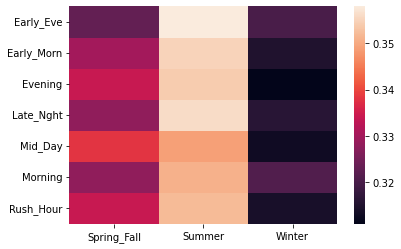


Rate Normalized by Column
            Spring_Fall  Summer  Winter  Total
Early_Eve         0.127   0.131   0.132  0.390
Early_Morn        0.158   0.159   0.158  0.475
Evening           0.163   0.161   0.159  0.483
Late_Nght         0.201   0.204   0.202  0.607
Mid_Day           0.121   0.117   0.117  0.355
Morning           0.119   0.119   0.122  0.360
Rush_Hour         0.112   0.110   0.110  0.332
Total             1.001   1.001   1.000  3.002

HOUR_IM MONTH


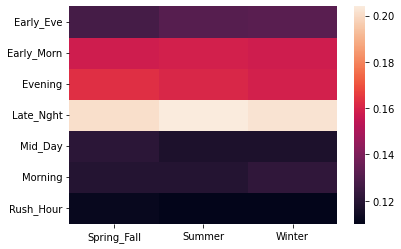


HOUR_IM PEDS
['Mid_Day', 'Early_Eve', 'Early_Morn', 'Evening', 'Morning', 'Rush_Hour', 'Late_Nght']
['0', '1', 'Multiple']

Count Crashes
                 0      1  Multiple   Total
Early_Eve    69792   7353       389   77534
Early_Morn   21530   2066        98   23694
Evening      55550   6821       444   62815
Late_Nght    38751   3948       265   42964
Mid_Day     146150   9594       407  156151
Morning     102837   7764       353  110954
Rush_Hour   158692  10994       476  170162
Total       593302  48540      2432  644274

Hospitalization Count
                0      1  Multiple   Total
Early_Eve   10242   2103       155   12500
Early_Morn   3967    652        32    4651
Evening     10339   2088       196   12623
Late_Nght    9444   1261       133   10838
Mid_Day     20285   2574       147   23006
Morning     14228   2114       135   16477
Rush_Hour   20398   2947       170   23515
Total       88903  13739       968  103610

Hospitalization Rate
                0      1  Multipl

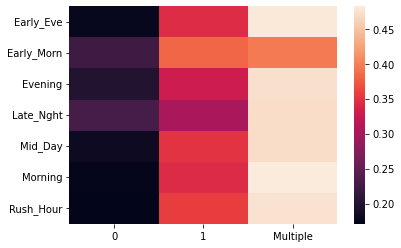


Rate Normalized by Column
                0      1  Multiple  Total
Early_Eve   0.126  0.140     0.144  0.410
Early_Morn  0.158  0.155     0.118  0.431
Evening     0.160  0.150     0.159  0.469
Late_Nght   0.209  0.157     0.181  0.547
Mid_Day     0.119  0.132     0.130  0.381
Morning     0.119  0.134     0.138  0.391
Rush_Hour   0.110  0.132     0.129  0.371
Total       1.001  1.000     0.999  3.000

HOUR_IM PEDS


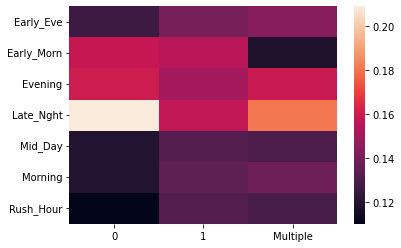


HOUR_IM PERMVIT
['Mid_Day', 'Early_Eve', 'Early_Morn', 'Evening', 'Morning', 'Rush_Hour', 'Late_Nght']
['2', 'Multiple', '1']

Count Crashes
                1       2  Multiple   Total
Early_Eve   10883   21338     45313   77534
Early_Morn   5964    9206      8524   23694
Evening     12430   16412     33973   62815
Late_Nght   13168   12055     17741   42964
Mid_Day     16592   49891     89668  156151
Morning     14821   42286     53847  110954
Rush_Hour   16366   52559    101237  170162
Total       90224  203747    350303  644274

Hospitalization Count
                1      2  Multiple   Total
Early_Eve    3155   2932      6413   12500
Early_Morn   1538   1504      1609    4651
Evening      3674   2905      6044   12623
Late_Nght    3954   2862      4022   10838
Mid_Day      4939   6197     11870   23006
Morning      3913   5051      7513   16477
Rush_Hour    4925   5898     12692   23515
Total       26098  27349     50163  103610

Hospitalization Rate
                1      2  Mult

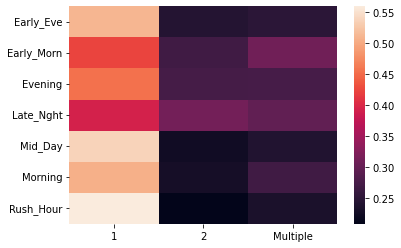


Rate Normalized by Column
                1      2  Multiple  Total
Early_Eve   0.144  0.128     0.125  0.397
Early_Morn  0.129  0.153     0.167  0.449
Evening     0.147  0.165     0.157  0.469
Late_Nght   0.150  0.222     0.200  0.572
Mid_Day     0.148  0.116     0.117  0.381
Morning     0.132  0.112     0.123  0.367
Rush_Hour   0.150  0.105     0.111  0.366
Total       1.000  1.001     1.000  3.001

HOUR_IM PERMVIT


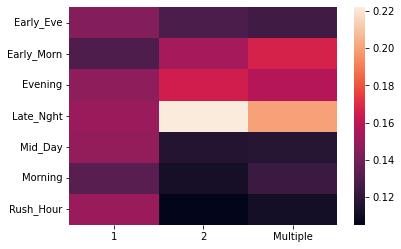


HOUR_IM REL_ROAD
['Mid_Day', 'Early_Eve', 'Early_Morn', 'Evening', 'Morning', 'Rush_Hour', 'Late_Nght']
['On_Road', 'Not_on_Road', 'Parking_Area']

Count Crashes
            Not_on_Road  On_Road  Parking_Area   Total
Early_Eve          6092    70411          1031   77534
Early_Morn         4027    19335           332   23694
Evening            8461    53021          1333   62815
Late_Nght         12936    28289          1739   42964
Mid_Day           11309   142506          2336  156151
Morning            9650    99644          1660  110954
Rush_Hour         10425   158079          1658  170162
Total             62900   571285         10089  644274

Hospitalization Count
            Not_on_Road  On_Road  Parking_Area   Total
Early_Eve          2011    10386           103   12500
Early_Morn         1311     3304            36    4651
Evening            2850     9629           144   12623
Late_Nght          4597     5976           265   10838
Mid_Day            3799    18978           2

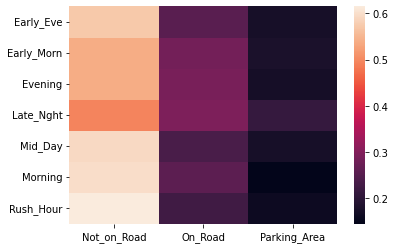


Rate Normalized by Column
            Not_on_Road  On_Road  Parking_Area  Total
Early_Eve         0.141    0.134         0.136  0.411
Early_Morn        0.139    0.155         0.148  0.442
Evening           0.144    0.165         0.148  0.457
Late_Nght         0.152    0.191         0.208  0.551
Mid_Day           0.144    0.121         0.134  0.399
Morning           0.133    0.121         0.103  0.357
Rush_Hour         0.147    0.113         0.123  0.383
Total             1.000    1.000         1.000  3.000

HOUR_IM REL_ROAD


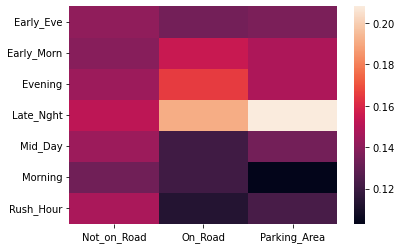


HOUR_IM RELJCT2_IM
['Mid_Day', 'Early_Eve', 'Early_Morn', 'Evening', 'Morning', 'Rush_Hour', 'Late_Nght']
['B', 'A', 'C', 'D']

Count Crashes
                 A       B      C       D   Total
Early_Eve    22218   28553   7274   19489   77534
Early_Morn    5467   11961   1499    4767   23694
Evening      17572   25761   4705   14777   62815
Late_Nght     9301   23536   2064    8063   42964
Mid_Day      43252   54109  17433   41357  156151
Morning      30361   42015  10210   28368  110954
Rush_Hour    44953   63105  17756   44348  170162
Total       173124  249040  60941  161169  644274

Hospitalization Count
                A      B     C      D   Total
Early_Eve    4276   4829  1083   2312   12500
Early_Morn   1208   2447   236    760    4651
Evening      3791   5755   838   2239   12623
Late_Nght    2267   6443   436   1692   10838
Mid_Day      7925   8508  2349   4224   23006
Morning      5718   6422  1321   3016   16477
Rush_Hour    7974   8980  2159   4402   23515
Total       3315

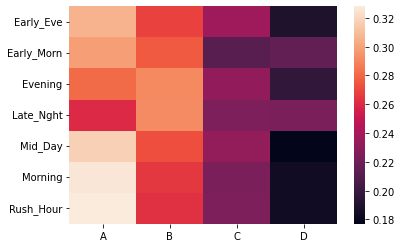


Rate Normalized by Column
                A      B      C      D  Total
Early_Eve   0.135  0.128  0.138  0.125  0.526
Early_Morn  0.155  0.155  0.146  0.168  0.624
Evening     0.152  0.169  0.165  0.160  0.646
Late_Nght   0.171  0.207  0.195  0.222  0.795
Mid_Day     0.129  0.119  0.125  0.108  0.481
Morning     0.132  0.116  0.120  0.112  0.480
Rush_Hour   0.125  0.108  0.112  0.105  0.450
Total       0.999  1.002  1.001  1.000  4.002

HOUR_IM RELJCT2_IM


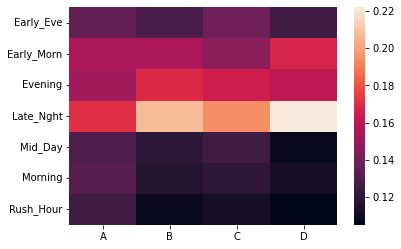


HOUR_IM SCH_BUS
['Mid_Day', 'Early_Eve', 'Early_Morn', 'Evening', 'Morning', 'Rush_Hour', 'Late_Nght']
['0', '1']

Count Crashes
                 0     1   Total
Early_Eve    77496    38   77534
Early_Morn   23446   248   23694
Evening      62784    31   62815
Late_Nght    42949    15   42964
Mid_Day     155578   573  156151
Morning     109874  1080  110954
Rush_Hour   168893  1269  170162
Total       641020  3254  644274

Hospitalization Count
                 0    1   Total
Early_Eve    12495    5   12500
Early_Morn    4603   48    4651
Evening      12617    6   12623
Late_Nght    10838    0   10838
Mid_Day      22941   65   23006
Morning      16357  120   16477
Rush_Hour    23358  157   23515
Total       103209  401  103610

Hospitalization Rate
                0      1  Total
Early_Eve   0.161  0.132  0.293
Early_Morn  0.196  0.194  0.390
Evening     0.201  0.194  0.395
Late_Nght   0.252  0.000  0.252
Mid_Day     0.147  0.113  0.260
Morning     0.149  0.111  0.260
Rush_Hour   0.13

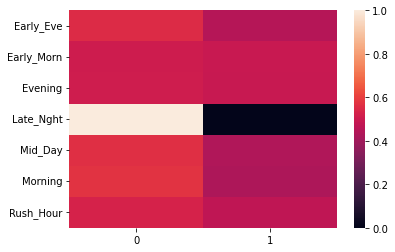


Rate Normalized by Column
                0      1  Total
Early_Eve   0.129  0.152  0.281
Early_Morn  0.158  0.223  0.381
Evening     0.161  0.223  0.384
Late_Nght   0.203  0.000  0.203
Mid_Day     0.118  0.131  0.249
Morning     0.120  0.128  0.248
Rush_Hour   0.111  0.143  0.254
Total       1.000  1.000  2.000

HOUR_IM SCH_BUS


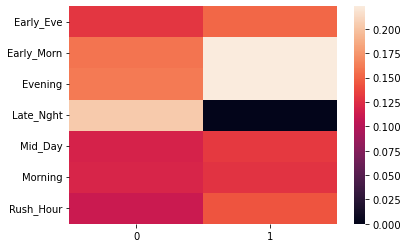


HOUR_IM URBANICITY
['Mid_Day', 'Early_Eve', 'Early_Morn', 'Evening', 'Morning', 'Rush_Hour', 'Late_Nght']
['2', '1']

Count Crashes
                 1       2   Total
Early_Eve    60982   16552   77534
Early_Morn   18241    5453   23694
Evening      49272   13543   62815
Late_Nght    33607    9357   42964
Mid_Day     120335   35816  156151
Morning      88532   22422  110954
Rush_Hour   132804   37358  170162
Total       503773  140501  644274

Hospitalization Count
                1      2   Total
Early_Eve    9727   2773   12500
Early_Morn   3533   1118    4651
Evening      9873   2750   12623
Late_Nght    8588   2250   10838
Mid_Day     17450   5556   23006
Morning     12849   3628   16477
Rush_Hour   17751   5764   23515
Total       79771  23839  103610

Hospitalization Rate
                1      2  Total
Early_Eve   0.160  0.168  0.328
Early_Morn  0.194  0.205  0.399
Evening     0.200  0.203  0.403
Late_Nght   0.256  0.240  0.496
Mid_Day     0.145  0.155  0.300
Morning     0.145 

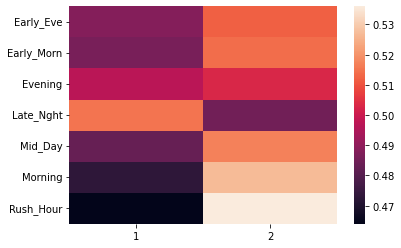


Rate Normalized by Column
                1      2  Total
Early_Eve   0.129  0.130  0.259
Early_Morn  0.157  0.159  0.316
Evening     0.163  0.158  0.321
Late_Nght   0.207  0.187  0.394
Mid_Day     0.118  0.121  0.239
Morning     0.118  0.126  0.244
Rush_Hour   0.108  0.120  0.228
Total       1.000  1.001  2.001

HOUR_IM URBANICITY


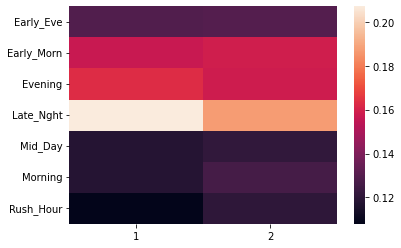


HOUR_IM VE_TOTAL
['Mid_Day', 'Early_Eve', 'Early_Morn', 'Evening', 'Morning', 'Rush_Hour', 'Late_Nght']
['2', '1', 'Multiple', '3']

Count Crashes
                 1       2      3  Multiple   Total
Early_Eve    15120   51549   8357      2508   77534
Early_Morn    7085   13419   2272       918   23694
Evening      17408   38638   5144      1625   62815
Late_Nght    17626   21600   2740       998   42964
Mid_Day      20729  113145  16628      5649  156151
Morning      17813   76871  12276      3994  110954
Rush_Hour    21924  118784  21796      7658  170162
Total       117705  434006  69213     23350  644274

Hospitalization Count
                1      2      3  Multiple   Total
Early_Eve    4285   6459   1317       439   12500
Early_Morn   1929   2168    400       154    4651
Evening      5042   6131   1069       381   12623
Late_Nght    5645   4227    679       287   10838
Mid_Day      6439  13098   2554       915   23006
Morning      5062   8814   1919       682   16477
Rush_Hour  

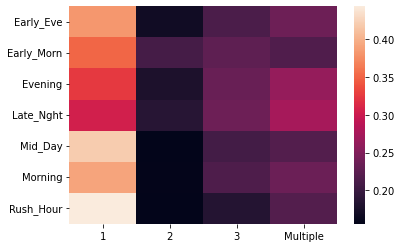


Rate Normalized by Column
                1      2      3  Multiple  Total
Early_Eve   0.137  0.128  0.129     0.130  0.524
Early_Morn  0.132  0.165  0.144     0.124  0.565
Evening     0.140  0.162  0.169     0.174  0.645
Late_Nght   0.155  0.200  0.202     0.213  0.770
Mid_Day     0.150  0.118  0.125     0.120  0.513
Morning     0.137  0.117  0.127     0.127  0.508
Rush_Hour   0.149  0.110  0.104     0.112  0.475
Total       1.000  1.000  1.000     1.000  4.000

HOUR_IM VE_TOTAL


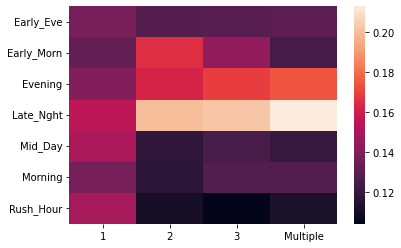


HOUR_IM WEATHR_IM
['Mid_Day', 'Early_Eve', 'Early_Morn', 'Evening', 'Morning', 'Rush_Hour', 'Late_Nght']
['B', 'A', 'D', 'C', 'E']

Count Crashes
               A       B      C      D      E   Total
Early_Eve    223   58192   7947   9892   1280   77534
Early_Morn   584   16065   2668   3682    695   23694
Evening      279   47398   6812   7266   1060   62815
Late_Nght    461   32524   4515   4626    838   42964
Mid_Day      317  113638  13025  26773   2398  156151
Morning      871   79099   9447  19173   2364  110954
Rush_Hour    328  125652  15491  26039   2652  170162
Total       3063  472568  59905  97451  11287  644274

Hospitalization Count
              A      B     C      D     E   Total
Early_Eve    39   9456  1309   1560   136   12500
Early_Morn  146   3169   479    752   105    4651
Evening      56   9655  1303   1462   147   12623
Late_Nght   131   8274  1075   1237   121   10838
Mid_Day      46  16819  1921   3944   276   23006
Morning     167  11694  1412   2889   315   

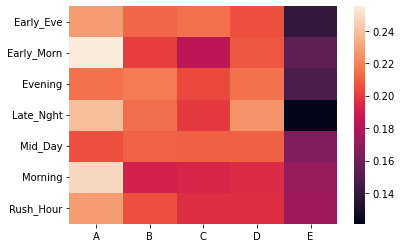


Rate Normalized by Column
                A      B      C      D      E  Total
Early_Eve   0.125  0.130  0.137  0.125  0.117  0.634
Early_Morn  0.178  0.157  0.149  0.162  0.166  0.812
Evening     0.143  0.162  0.159  0.159  0.153  0.776
Late_Nght   0.203  0.203  0.198  0.212  0.159  0.975
Mid_Day     0.103  0.118  0.122  0.117  0.127  0.587
Morning     0.137  0.118  0.124  0.119  0.147  0.645
Rush_Hour   0.111  0.112  0.111  0.106  0.131  0.571
Total       1.000  1.000  1.000  1.000  1.000  5.000

HOUR_IM WEATHR_IM


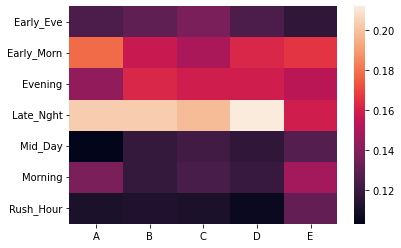


HOUR_IM WKDY_IM
['Mid_Day', 'Early_Eve', 'Early_Morn', 'Evening', 'Morning', 'Rush_Hour', 'Late_Nght']
['Weekday', 'Weekend']

Count Crashes
            Weekday  Weekend   Total
Early_Eve     57528    20006   77534
Early_Morn    19852     3842   23694
Evening       42932    19883   62815
Late_Nght     23573    19391   42964
Mid_Day      112330    43821  156151
Morning       92547    18407  110954
Rush_Hour    135795    34367  170162
Total        484557   159717  644274

Hospitalization Count
            Weekday  Weekend   Total
Early_Eve      8928     3572   12500
Early_Morn     3684      967    4651
Evening        8582     4041   12623
Late_Nght      5970     4868   10838
Mid_Day       16377     6629   23006
Morning       13144     3333   16477
Rush_Hour     17899     5616   23515
Total         74584    29026  103610

Hospitalization Rate
            Weekday  Weekend  Total
Early_Eve     0.155    0.179  0.334
Early_Morn    0.186    0.252  0.438
Evening       0.200    0.203  0.403
Lat

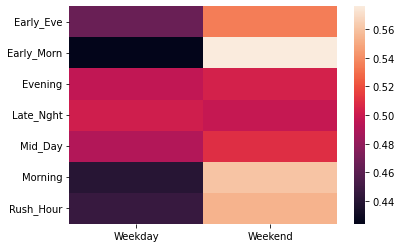


Rate Normalized by Column
            Weekday  Weekend  Total
Early_Eve     0.128    0.129  0.257
Early_Morn    0.153    0.182  0.335
Evening       0.165    0.147  0.312
Late_Nght     0.209    0.182  0.391
Mid_Day       0.120    0.110  0.230
Morning       0.117    0.131  0.248
Rush_Hour     0.109    0.118  0.227
Total         1.001    0.999  2.000

HOUR_IM WKDY_IM


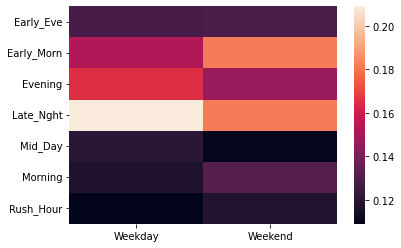


HOUR_IM WRK_ZONE
['Mid_Day', 'Early_Eve', 'Early_Morn', 'Evening', 'Morning', 'Rush_Hour', 'Late_Nght']
['0', '1', '2', '3']

Count Crashes
                 0      1    2    3   Total
Early_Eve    76457   1012   59    6   77534
Early_Morn   23189    459   42    4   23694
Evening      61542   1203   70    0   62815
Late_Nght    41998    899   60    7   42964
Mid_Day     152720   3132  256   43  156151
Morning     108485   2254  149   66  110954
Rush_Hour   167387   2566  155   54  170162
Total       631778  11525  791  180  644274

Hospitalization Count
                 0     1    2   3   Total
Early_Eve    12381   111    5   3   12500
Early_Morn    4579    61    9   2    4651
Evening      12440   174    9   0   12623
Late_Nght    10635   188   14   1   10838
Mid_Day      22578   383   40   5   23006
Morning      16183   260   22  12   16477
Rush_Hour    23237   248   16  14   23515
Total       102033  1425  115  37  103610

Hospitalization Rate
                0      1      2      3  

/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_11277/550312234.py:69: RuntimeWarning: invalid value encountered in true_divide
  F = pd.DataFrame(E/D, index=B, columns=C).round(3)
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_11277/550312234.py:96: RuntimeWarning: invalid value encountered in true_divide
  F = pd.DataFrame(E/D, index=B, columns=C)


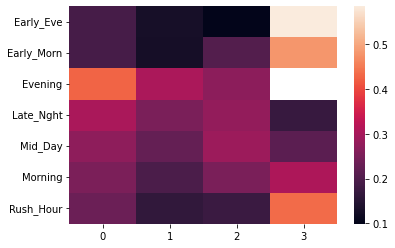


Rate Normalized by Column
                0      1      2      3  Total
Early_Eve   0.129  0.118  0.079  0.294  0.620
Early_Morn  0.158  0.143  0.201  0.294  0.796
Evening     0.162  0.155  0.120    NaN  0.437
Late_Nght   0.202  0.225  0.218  0.084  0.729
Mid_Day     0.118  0.131  0.146  0.068  0.463
Morning     0.119  0.124  0.138  0.107  0.488
Rush_Hour   0.111  0.104  0.097  0.152  0.464
Total       0.999  1.000  0.999  0.999  3.997

HOUR_IM WRK_ZONE


/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_11277/550312234.py:137: RuntimeWarning: invalid value encountered in true_divide
  F = pd.DataFrame(E/D, index=B, columns=C)


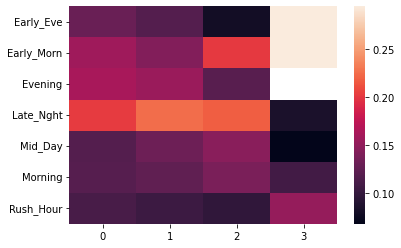


INT_HWY LGTCON_IM
[0, 1]
['Daylight', 'Dawn_Lighted', 'Dusk', 'Dark']

Count Crashes
        Dark  Dawn_Lighted  Daylight   Dusk   Total
0      44189        105927    415804  14221  580141
1       9332          9866     43595   1340   64133
Total  53521        115793    459399  15561  644274

Hospitalization Count
        Dark  Dawn_Lighted  Daylight  Dusk   Total
0      10310         19533     61595  2406   93844
1       1994          1802      5791   179    9766
Total  12304         21335     67386  2585  103610

Hospitalization Rate
        Dark  Dawn_Lighted  Daylight   Dusk  Total
0      0.233         0.184     0.148  0.169  0.734
1      0.214         0.183     0.133  0.134  0.664
Total  0.447         0.367     0.281  0.303  1.398

Rate Normalized by Row
        Dark  Dawn_Lighted  Daylight   Dusk  Total
0      0.317         0.251     0.202  0.230    1.0
1      0.322         0.276     0.200  0.202    1.0
Total  0.639         0.527     0.402  0.432    2.0

INT_HWY LGTCON_IM


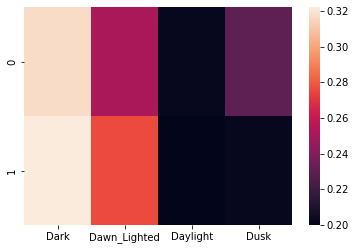


Rate Normalized by Column
        Dark  Dawn_Lighted  Daylight   Dusk  Total
0      0.522         0.502     0.527  0.559   2.11
1      0.478         0.498     0.473  0.441   1.89
Total  1.000         1.000     1.000  1.000   4.00

INT_HWY LGTCON_IM


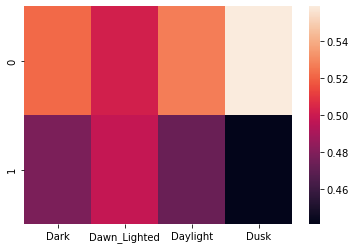


INT_HWY MONTH
[0, 1]
['Winter', 'Spring_Fall', 'Summer']

Count Crashes
       Spring_Fall  Summer  Winter   Total
0           195293  202911  181937  580141
1            21531   22811   19791   64133
Total       216824  225722  201728  644274

Hospitalization Count
       Spring_Fall  Summer  Winter   Total
0            31496   34567   27781   93844
1             3091    3836    2839    9766
Total        34587   38403   30620  103610

Hospitalization Rate
       Spring_Fall  Summer  Winter  Total
0            0.161   0.170   0.153  0.484
1            0.144   0.168   0.143  0.455
Total        0.305   0.338   0.296  0.939

Rate Normalized by Row
       Spring_Fall  Summer  Winter  Total
0            0.333   0.352   0.315  1.000
1            0.315   0.369   0.315  0.999
Total        0.648   0.721   0.630  1.999

INT_HWY MONTH


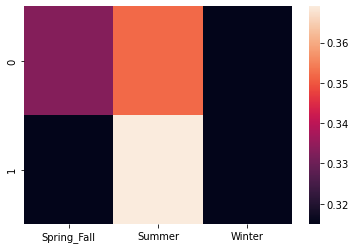


Rate Normalized by Column
       Spring_Fall  Summer  Winter  Total
0            0.529   0.503   0.516  1.548
1            0.471   0.497   0.484  1.452
Total        1.000   1.000   1.000  3.000

INT_HWY MONTH


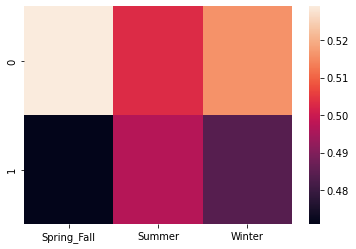


INT_HWY PEDS
[0, 1]
['0', '1', 'Multiple']

Count Crashes
            0      1  Multiple   Total
0      530132  47692      2317  580141
1       63170    848       115   64133
Total  593302  48540      2432  644274

Hospitalization Count
           0      1  Multiple   Total
0      79462  13481       901   93844
1       9441    258        67    9766
Total  88903  13739       968  103610

Hospitalization Rate
           0      1  Multiple  Total
0      0.150  0.283     0.389  0.822
1      0.149  0.304     0.583  1.036
Total  0.299  0.587     0.972  1.858

Rate Normalized by Row
           0      1  Multiple  Total
0      0.182  0.344     0.473  0.999
1      0.144  0.294     0.562  1.000
Total  0.326  0.638     1.035  1.999

INT_HWY PEDS


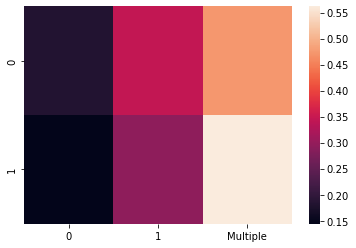


Rate Normalized by Column
           0      1  Multiple  Total
0      0.501  0.482       0.4  1.383
1      0.499  0.518       0.6  1.617
Total  1.000  1.000       1.0  3.000

INT_HWY PEDS


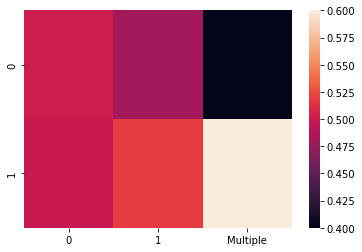


INT_HWY PERMVIT
[0, 1]
['2', 'Multiple', '1']

Count Crashes
           1       2  Multiple   Total
0      84330  185434    310377  580141
1       5894   18313     39926   64133
Total  90224  203747    350303  644274

Hospitalization Count
           1      2  Multiple   Total
0      24201  25073     44570   93844
1       1897   2276      5593    9766
Total  26098  27349     50163  103610

Hospitalization Rate
           1      2  Multiple  Total
0      0.287  0.135     0.144  0.566
1      0.322  0.124     0.140  0.586
Total  0.609  0.259     0.284  1.152

Rate Normalized by Row
           1      2  Multiple  Total
0      0.507  0.239     0.254    1.0
1      0.549  0.212     0.239    1.0
Total  1.056  0.451     0.493    2.0

INT_HWY PERMVIT


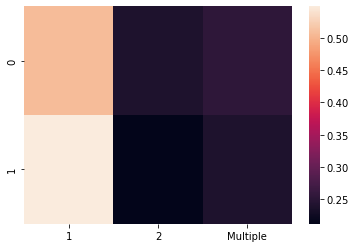


Rate Normalized by Column
           1      2  Multiple  Total
0      0.471  0.521     0.506  1.498
1      0.529  0.479     0.494  1.502
Total  1.000  1.000     1.000  3.000

INT_HWY PERMVIT


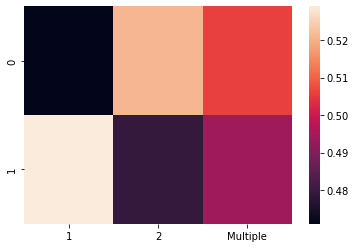


INT_HWY REL_ROAD
[0, 1]
['On_Road', 'Not_on_Road', 'Parking_Area']

Count Crashes
       Not_on_Road  On_Road  Parking_Area   Total
0            52614   517453         10074  580141
1            10286    53832            15   64133
Total        62900   571285         10089  644274

Hospitalization Count
       Not_on_Road  On_Road  Parking_Area   Total
0            17737    75058          1049   93844
1             3403     6361             2    9766
Total        21140    81419          1051  103610

Hospitalization Rate
       Not_on_Road  On_Road  Parking_Area  Total
0            0.337    0.145         0.104  0.586
1            0.331    0.118         0.133  0.582
Total        0.668    0.263         0.237  1.168

Rate Normalized by Row
       Not_on_Road  On_Road  Parking_Area  Total
0            0.575    0.247         0.178    1.0
1            0.568    0.203         0.229    1.0
Total        1.143    0.450         0.407    2.0

INT_HWY REL_ROAD


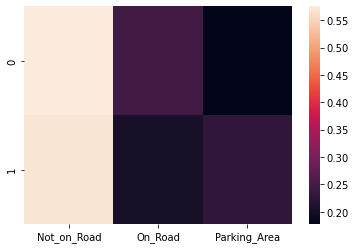


Rate Normalized by Column
       Not_on_Road  On_Road  Parking_Area  Total
0            0.505    0.551         0.439  1.495
1            0.495    0.449         0.561  1.505
Total        1.000    1.000         1.000  3.000

INT_HWY REL_ROAD


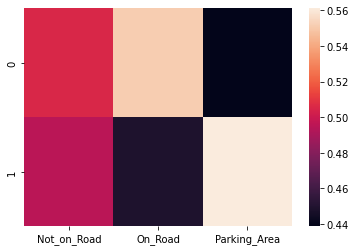


INT_HWY RELJCT2_IM
[0, 1]
['B', 'A', 'C', 'D']

Count Crashes
            A       B      C       D   Total
0      168916  198816  57698  154711  580141
1        4208   50224   3243    6458   64133
Total  173124  249040  60941  161169  644274

Hospitalization Count
           A      B     C      D   Total
0      32233  35527  7998  18086   93844
1        926   7857   424    559    9766
Total  33159  43384  8422  18645  103610

Hospitalization Rate
           A      B      C      D  Total
0      0.191  0.179  0.139  0.117  0.626
1      0.220  0.156  0.131  0.087  0.594
Total  0.411  0.335  0.270  0.204  1.220

Rate Normalized by Row
           A      B      C      D  Total
0      0.305  0.286  0.222  0.187    1.0
1      0.371  0.263  0.220  0.146    1.0
Total  0.676  0.549  0.442  0.333    2.0

INT_HWY RELJCT2_IM


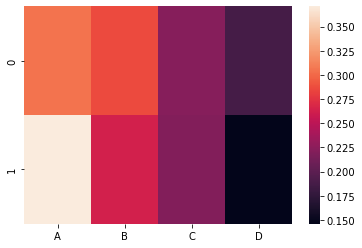


Rate Normalized by Column
           A      B      C      D  Total
0      0.464  0.533  0.515  0.575  2.087
1      0.536  0.467  0.485  0.425  1.913
Total  1.000  1.000  1.000  1.000  4.000

INT_HWY RELJCT2_IM


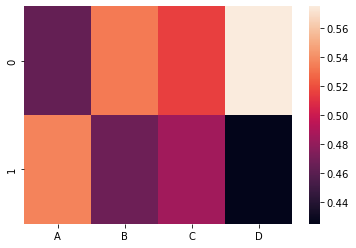


INT_HWY SCH_BUS
[0, 1]
['0', '1']

Count Crashes
            0     1   Total
0      576954  3187  580141
1       64066    67   64133
Total  641020  3254  644274

Hospitalization Count
            0    1   Total
0       93455  389   93844
1        9754   12    9766
Total  103209  401  103610

Hospitalization Rate
           0      1  Total
0      0.162  0.122  0.284
1      0.152  0.179  0.331
Total  0.314  0.301  0.615

Rate Normalized by Row
           0      1  Total
0      0.570  0.430    1.0
1      0.459  0.541    1.0
Total  1.029  0.971    2.0

INT_HWY SCH_BUS


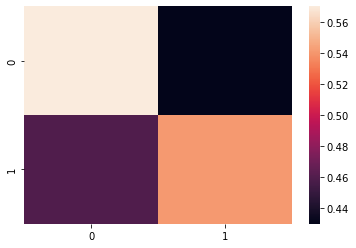


Rate Normalized by Column
           0      1  Total
0      0.515  0.405   0.92
1      0.485  0.595   1.08
Total  1.000  1.000   2.00

INT_HWY SCH_BUS


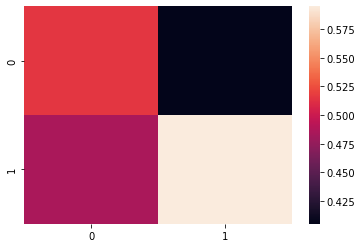


INT_HWY URBANICITY
[0, 1]
['2', '1']

Count Crashes
            1       2   Total
0      451679  128462  580141
1       52094   12039   64133
Total  503773  140501  644274

Hospitalization Count
           1      2   Total
0      72117  21727   93844
1       7654   2112    9766
Total  79771  23839  103610

Hospitalization Rate
           1      2  Total
0      0.160  0.169  0.329
1      0.147  0.175  0.322
Total  0.307  0.344  0.651

Rate Normalized by Row
           1      2  Total
0      0.486  0.514    1.0
1      0.456  0.544    1.0
Total  0.942  1.058    2.0

INT_HWY URBANICITY


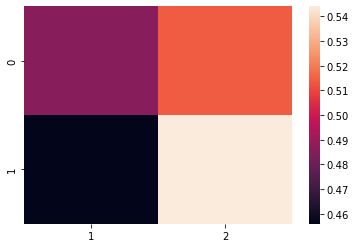


Rate Normalized by Column
           1      2  Total
0      0.521  0.491  1.012
1      0.479  0.509  0.988
Total  1.000  1.000  2.000

INT_HWY URBANICITY


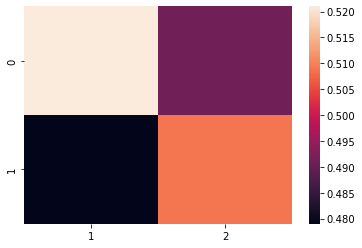


INT_HWY VE_TOTAL
[0, 1]
['2', '1', 'Multiple', '3']

Count Crashes
            1       2      3  Multiple   Total
0      107326  397138  58315     17362  580141
1       10379   36868  10898      5988   64133
Total  117705  434006  69213     23350  644274

Hospitalization Count
           1      2      3  Multiple   Total
0      31873  49747   9211      3013   93844
1       3263   4001   1498      1004    9766
Total  35136  53748  10709      4017  103610

Hospitalization Rate
           1      2      3  Multiple  Total
0      0.297  0.125  0.158     0.174  0.754
1      0.314  0.109  0.137     0.168  0.728
Total  0.611  0.234  0.295     0.342  1.482

Rate Normalized by Row
           1      2      3  Multiple  Total
0      0.394  0.166  0.210      0.23    1.0
1      0.432  0.149  0.189      0.23    1.0
Total  0.826  0.315  0.399      0.46    2.0

INT_HWY VE_TOTAL


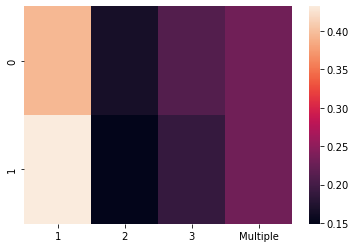


Rate Normalized by Column
           1      2      3  Multiple  Total
0      0.486  0.536  0.535     0.509  2.066
1      0.514  0.464  0.465     0.491  1.934
Total  1.000  1.000  1.000     1.000  4.000

INT_HWY VE_TOTAL


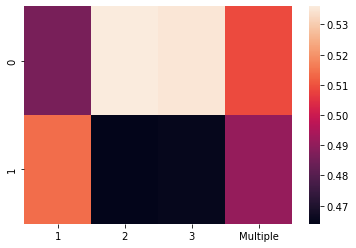


INT_HWY WEATHR_IM
[0, 1]
['B', 'A', 'D', 'C', 'E']

Count Crashes
          A       B      C      D      E   Total
0      2655  428344  52140  87058   9944  580141
1       408   44224   7765  10393   1343   64133
Total  3063  472568  59905  97451  11287  644274

Hospitalization Count
         A      B     C      D     E   Total
0      556  69937  8264  13830  1257   93844
1       80   6735  1309   1484   158    9766
Total  636  76672  9573  15314  1415  103610

Hospitalization Rate
           A      B      C      D      E  Total
0      0.209  0.163  0.158  0.159  0.126  0.815
1      0.196  0.152  0.169  0.143  0.118  0.778
Total  0.405  0.315  0.327  0.302  0.244  1.593

Rate Normalized by Row
           A      B      C      D      E  Total
0      0.256  0.200  0.194  0.195  0.155    1.0
1      0.252  0.196  0.217  0.184  0.151    1.0
Total  0.508  0.396  0.411  0.379  0.306    2.0

INT_HWY WEATHR_IM


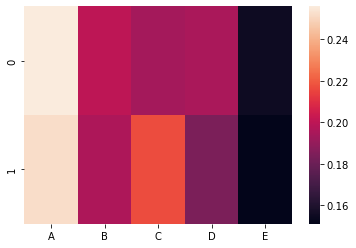


Rate Normalized by Column
           A      B      C      D      E  Total
0      0.516  0.517  0.485  0.527  0.518  2.563
1      0.484  0.483  0.515  0.473  0.482  2.437
Total  1.000  1.000  1.000  1.000  1.000  5.000

INT_HWY WEATHR_IM


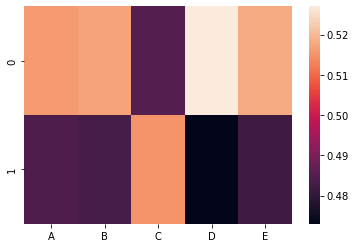


INT_HWY WKDY_IM
[0, 1]
['Weekday', 'Weekend']

Count Crashes
       Weekday  Weekend   Total
0       438191   141950  580141
1        46366    17767   64133
Total   484557   159717  644274

Hospitalization Count
       Weekday  Weekend   Total
0        67869    25975   93844
1         6715     3051    9766
Total    74584    29026  103610

Hospitalization Rate
       Weekday  Weekend  Total
0        0.155    0.183  0.338
1        0.145    0.172  0.317
Total    0.300    0.355  0.655

Rate Normalized by Row
       Weekday  Weekend  Total
0        0.458    0.542    1.0
1        0.458    0.542    1.0
Total    0.916    1.084    2.0

INT_HWY WKDY_IM


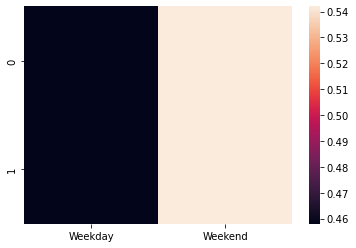


Rate Normalized by Column
       Weekday  Weekend  Total
0        0.517    0.516  1.033
1        0.483    0.484  0.967
Total    1.000    1.000  2.000

INT_HWY WKDY_IM


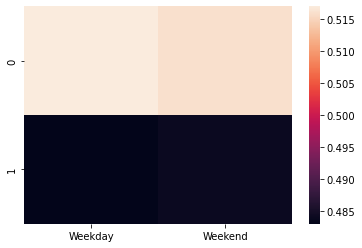


INT_HWY WRK_ZONE
[0, 1]
['0', '1', '2', '3']

Count Crashes
            0      1    2    3   Total
0      571844   7611  515  171  580141
1       59934   3914  276    9   64133
Total  631778  11525  791  180  644274

Hospitalization Count
            0     1    2   3   Total
0       92851   884   75  34   93844
1        9182   541   40   3    9766
Total  102033  1425  115  37  103610

Hospitalization Rate
           0      1      2      3  Total
0      0.162  0.116  0.146  0.199  0.623
1      0.153  0.138  0.145  0.333  0.769
Total  0.315  0.254  0.291  0.532  1.392

Rate Normalized by Row
           0      1      2      3  Total
0      0.261  0.186  0.234  0.319    1.0
1      0.199  0.180  0.188  0.433    1.0
Total  0.460  0.366  0.422  0.752    2.0

INT_HWY WRK_ZONE


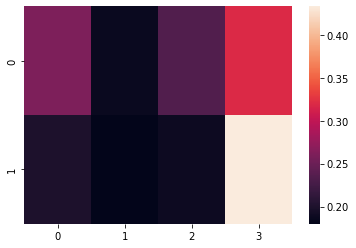


Rate Normalized by Column
           0      1      2      3  Total
0      0.515  0.457  0.501  0.374  1.847
1      0.485  0.543  0.499  0.626  2.153
Total  1.000  1.000  1.000  1.000  4.000

INT_HWY WRK_ZONE


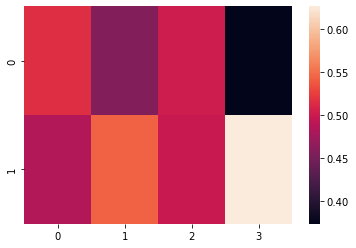


LGTCON_IM MONTH
['Daylight', 'Dawn_Lighted', 'Dusk', 'Dark']
['Winter', 'Spring_Fall', 'Summer']

Count Crashes
              Spring_Fall  Summer  Winter   Total
Dark                18859   13571   21091   53521
Dawn_Lighted        39041   29081   47671  115793
Daylight           153593  178796  127010  459399
Dusk                 5331    4274    5956   15561
Total              216824  225722  201728  644274

Hospitalization Count
              Spring_Fall  Summer  Winter   Total
Dark                 4160    3739    4405   12304
Dawn_Lighted         7246    6095    7994   21335
Daylight            22289   27681   17416   67386
Dusk                  892     888     805    2585
Total               34587   38403   30620  103610

Hospitalization Rate
              Spring_Fall  Summer  Winter  Total
Dark                0.221   0.276   0.209  0.706
Dawn_Lighted        0.186   0.210   0.168  0.564
Daylight            0.145   0.155   0.137  0.437
Dusk                0.167   0.208   0.135  0.5

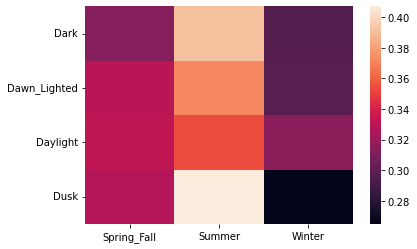


Rate Normalized by Column
              Spring_Fall  Summer  Winter  Total
Dark                0.307   0.325   0.322  0.954
Dawn_Lighted        0.258   0.247   0.258  0.763
Daylight            0.202   0.183   0.211  0.596
Dusk                0.233   0.245   0.208  0.686
Total               1.000   1.000   0.999  2.999

LGTCON_IM MONTH


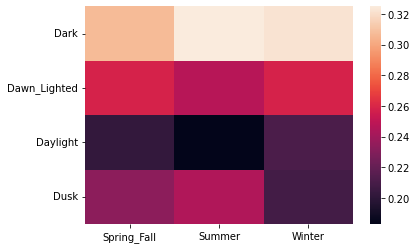


LGTCON_IM PEDS
['Daylight', 'Dawn_Lighted', 'Dusk', 'Dark']
['0', '1', 'Multiple']

Count Crashes
                   0      1  Multiple   Total
Dark           49088   4123       310   53521
Dawn_Lighted  102237  12800       756  115793
Daylight      427909  30195      1295  459399
Dusk           14068   1422        71   15561
Total         593302  48540      2432  644274

Hospitalization Count
                  0      1  Multiple   Total
Dark          10917   1252       135   12304
Dawn_Lighted  17014   4008       313   21335
Daylight      58830   8074       482   67386
Dusk           2142    405        38    2585
Total         88903  13739       968  103610

Hospitalization Rate
                  0      1  Multiple  Total
Dark          0.222  0.304     0.435  0.961
Dawn_Lighted  0.166  0.313     0.414  0.893
Daylight      0.137  0.267     0.372  0.776
Dusk          0.152  0.285     0.535  0.972
Total         0.677  1.169     1.756  3.602

Rate Normalized by Row
                  0   

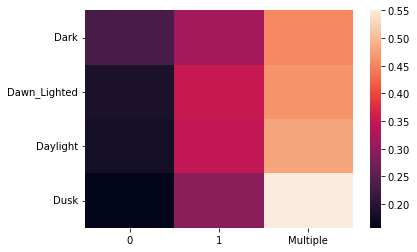


Rate Normalized by Column
                  0      1  Multiple  Total
Dark          0.328  0.260     0.248  0.836
Dawn_Lighted  0.245  0.268     0.236  0.749
Daylight      0.203  0.229     0.212  0.644
Dusk          0.224  0.244     0.305  0.773
Total         1.000  1.001     1.001  3.002

LGTCON_IM PEDS


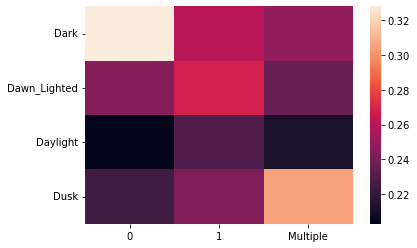


LGTCON_IM PERMVIT
['Daylight', 'Dawn_Lighted', 'Dusk', 'Dark']
['2', 'Multiple', '1']

Count Crashes
                  1       2  Multiple   Total
Dark          15738   14820     22963   53521
Dawn_Lighted  21383   33454     60956  115793
Daylight      50844  150957    257598  459399
Dusk           2259    4516      8786   15561
Total         90224  203747    350303  644274

Hospitalization Count
                  1      2  Multiple   Total
Dark           4215   3142      4947   12304
Dawn_Lighted   6313   5308      9714   21335
Daylight      14895  18297     34194   67386
Dusk            675    602      1308    2585
Total         26098  27349     50163  103610

Hospitalization Rate
                  1      2  Multiple  Total
Dark          0.268  0.212     0.215  0.695
Dawn_Lighted  0.295  0.159     0.159  0.613
Daylight      0.293  0.121     0.133  0.547
Dusk          0.299  0.133     0.149  0.581
Total         1.155  0.625     0.656  2.436

Rate Normalized by Row
                  1

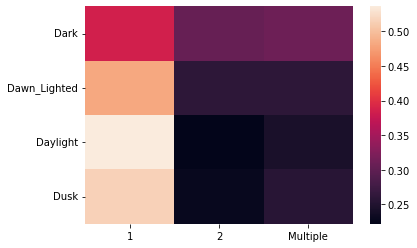


Rate Normalized by Column
                  1      2  Multiple  Total
Dark          0.232  0.339     0.328  0.899
Dawn_Lighted  0.256  0.254     0.243  0.753
Daylight      0.254  0.194     0.202  0.650
Dusk          0.259  0.213     0.227  0.699
Total         1.001  1.000     1.000  3.001

LGTCON_IM PERMVIT


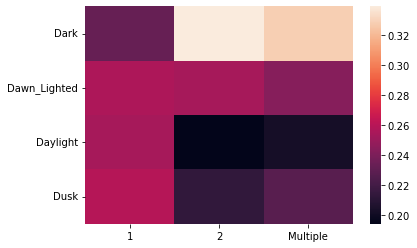


LGTCON_IM REL_ROAD
['Daylight', 'Dawn_Lighted', 'Dusk', 'Dark']
['On_Road', 'Not_on_Road', 'Parking_Area']

Count Crashes
              Not_on_Road  On_Road  Parking_Area   Total
Dark                14223    38455           843   53521
Dawn_Lighted        13243    99522          3028  115793
Daylight            34147   419227          6025  459399
Dusk                 1287    14081           193   15561
Total               62900   571285         10089  644274

Hospitalization Count
              Not_on_Road  On_Road  Parking_Area   Total
Dark                 5084     7134            86   12304
Dawn_Lighted         4115    16822           398   21335
Daylight            11492    55343           551   67386
Dusk                  449     2120            16    2585
Total               21140    81419          1051  103610

Hospitalization Rate
              Not_on_Road  On_Road  Parking_Area  Total
Dark                0.357    0.186         0.102  0.645
Dawn_Lighted        0.311    0.169  

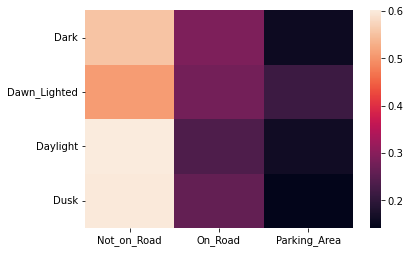


Rate Normalized by Column
              Not_on_Road  On_Road  Parking_Area  Total
Dark                0.264    0.291         0.250  0.805
Dawn_Lighted        0.230    0.265         0.322  0.817
Daylight            0.249    0.207         0.224  0.680
Dusk                0.258    0.236         0.203  0.697
Total               1.001    0.999         0.999  2.999

LGTCON_IM REL_ROAD


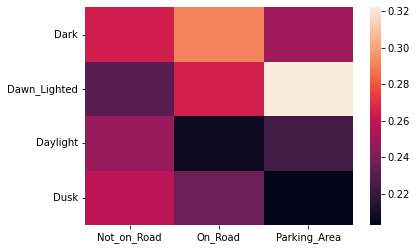


LGTCON_IM RELJCT2_IM
['Daylight', 'Dawn_Lighted', 'Dusk', 'Dark']
['B', 'A', 'C', 'D']

Count Crashes
                   A       B      C       D   Total
Dark            8050   35446   3286    6739   53521
Dawn_Lighted   35080   41036   8632   31045  115793
Daylight      125524  166881  47639  119355  459399
Dusk            4470    5677   1384    4030   15561
Total         173124  249040  60941  161169  644274

Hospitalization Count
                  A      B     C      D   Total
Dark           1982   8557   669   1096   12304
Dawn_Lighted   7187   8071  1311   4766   21335
Daylight      23105  25781  6224  12276   67386
Dusk            885    975   218    507    2585
Total         33159  43384  8422  18645  103610

Hospitalization Rate
                  A      B      C      D  Total
Dark          0.246  0.241  0.204  0.163  0.854
Dawn_Lighted  0.205  0.197  0.152  0.154  0.708
Daylight      0.184  0.154  0.131  0.103  0.572
Dusk          0.198  0.172  0.158  0.126  0.654
Total       

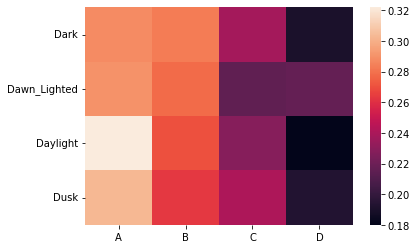


Rate Normalized by Column
                  A      B      C      D  Total
Dark          0.296  0.316  0.316  0.299  1.227
Dawn_Lighted  0.246  0.257  0.236  0.282  1.021
Daylight      0.221  0.202  0.203  0.189  0.815
Dusk          0.238  0.225  0.245  0.231  0.939
Total         1.001  1.000  1.000  1.001  4.002

LGTCON_IM RELJCT2_IM


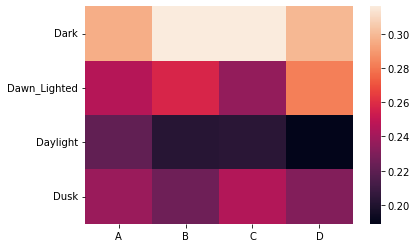


LGTCON_IM SCH_BUS
['Daylight', 'Dawn_Lighted', 'Dusk', 'Dark']
['0', '1']

Count Crashes
                   0     1   Total
Dark           53460    61   53521
Dawn_Lighted  115570   223  115793
Daylight      456453  2946  459399
Dusk           15537    24   15561
Total         641020  3254  644274

Hospitalization Count
                   0    1   Total
Dark           12294   10   12304
Dawn_Lighted   21295   40   21335
Daylight       67037  349   67386
Dusk            2583    2    2585
Total         103209  401  103610

Hospitalization Rate
                  0      1  Total
Dark          0.230  0.164  0.394
Dawn_Lighted  0.184  0.179  0.363
Daylight      0.147  0.118  0.265
Dusk          0.166  0.083  0.249
Total         0.727  0.544  1.271

Rate Normalized by Row
                  0      1  Total
Dark          0.584  0.416    1.0
Dawn_Lighted  0.507  0.493    1.0
Daylight      0.554  0.446    1.0
Dusk          0.666  0.334    1.0
Total         2.311  1.689    4.0

LGTCON_IM SCH_BUS


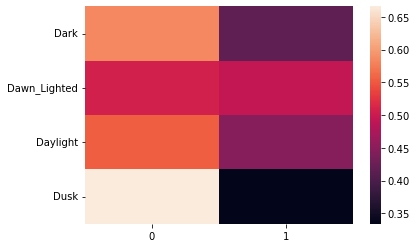


Rate Normalized by Column
                  0      1  Total
Dark          0.316  0.301  0.617
Dawn_Lighted  0.253  0.329  0.582
Daylight      0.202  0.217  0.419
Dusk          0.229  0.153  0.382
Total         1.000  1.000  2.000

LGTCON_IM SCH_BUS


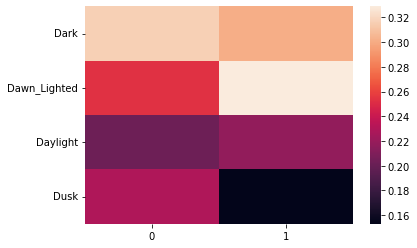


LGTCON_IM URBANICITY
['Daylight', 'Dawn_Lighted', 'Dusk', 'Dark']
['2', '1']

Count Crashes
                   1       2   Total
Dark           33885   19636   53521
Dawn_Lighted   97908   17885  115793
Daylight      359462   99937  459399
Dusk           12518    3043   15561
Total         503773  140501  644274

Hospitalization Count
                  1      2   Total
Dark           7859   4445   12304
Dawn_Lighted  18537   2798   21335
Daylight      51346  16040   67386
Dusk           2029    556    2585
Total         79771  23839  103610

Hospitalization Rate
                  1      2  Total
Dark          0.232  0.226  0.458
Dawn_Lighted  0.189  0.156  0.345
Daylight      0.143  0.161  0.304
Dusk          0.162  0.183  0.345
Total         0.726  0.726  1.452

Rate Normalized by Row
                  1      2  Total
Dark          0.506  0.494    1.0
Dawn_Lighted  0.548  0.452    1.0
Daylight      0.471  0.529    1.0
Dusk          0.470  0.530    1.0
Total         1.995  2.005    4.

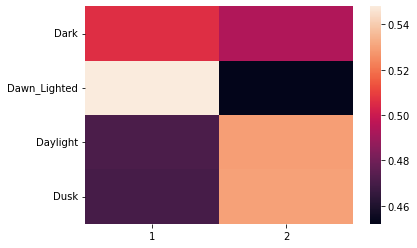


Rate Normalized by Column
                  1      2  Total
Dark          0.319  0.312  0.631
Dawn_Lighted  0.261  0.215  0.476
Daylight      0.197  0.221  0.418
Dusk          0.223  0.252  0.475
Total         1.000  1.000  2.000

LGTCON_IM URBANICITY


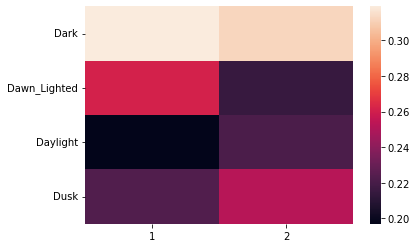


LGTCON_IM VE_TOTAL
['Daylight', 'Dawn_Lighted', 'Dusk', 'Dark']
['2', '1', 'Multiple', '3']

Count Crashes
                   1       2      3  Multiple   Total
Dark           23897   24704   3778      1142   53521
Dawn_Lighted   26053   74480  11445      3815  115793
Daylight       64767  324537  52203     17892  459399
Dusk            2988   10285   1787       501   15561
Total         117705  434006  69213     23350  644274

Hospitalization Count
                  1      2      3  Multiple   Total
Dark           6407   4727    902       268   12304
Dawn_Lighted   7934  10673   1951       777   21335
Daylight      19892  37029   7592      2873   67386
Dusk            903   1319    264        99    2585
Total         35136  53748  10709      4017  103610

Hospitalization Rate
                  1      2      3  Multiple  Total
Dark          0.268  0.191  0.239     0.235  0.933
Dawn_Lighted  0.305  0.143  0.170     0.204  0.822
Daylight      0.307  0.114  0.145     0.161  0.727
Dusk   

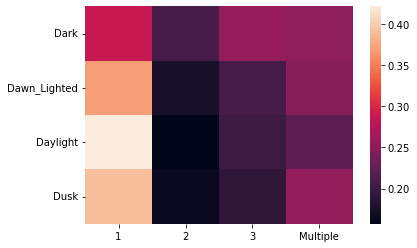


Rate Normalized by Column
                  1      2      3  Multiple  Total
Dark          0.227  0.332  0.340     0.295  1.194
Dawn_Lighted  0.258  0.248  0.243     0.256  1.005
Daylight      0.260  0.198  0.207     0.202  0.867
Dusk          0.256  0.222  0.210     0.248  0.936
Total         1.001  1.000  1.000     1.001  4.002

LGTCON_IM VE_TOTAL


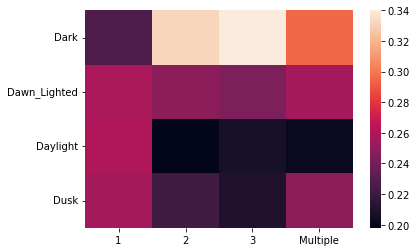


LGTCON_IM WEATHR_IM
['Daylight', 'Dawn_Lighted', 'Dusk', 'Dark']
['B', 'A', 'D', 'C', 'E']

Count Crashes
                 A       B      C      D      E   Total
Dark           785   37041   6251   7555   1889   53521
Dawn_Lighted   923   84435  13914  13902   2619  115793
Daylight      1317  340030  37946  73643   6463  459399
Dusk            38   11062   1794   2351    316   15561
Total         3063  472568  59905  97451  11287  644274

Hospitalization Count
                A      B     C      D     E   Total
Dark          207   8725  1357   1725   290   12304
Dawn_Lighted  181  15883  2487   2496   288   21335
Daylight      242  50195  5432  10720   797   67386
Dusk            6   1869   297    373    40    2585
Total         636  76672  9573  15314  1415  103610

Hospitalization Rate
                  A      B      C      D      E  Total
Dark          0.264  0.236  0.217  0.228  0.154  1.099
Dawn_Lighted  0.196  0.188  0.179  0.180  0.110  0.853
Daylight      0.184  0.148  0.143  

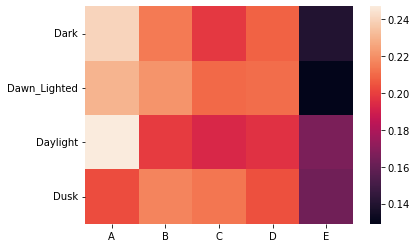


Rate Normalized by Column
                  A      B      C      D      E  Total
Dark          0.329  0.318  0.308  0.321  0.299  1.575
Dawn_Lighted  0.245  0.254  0.254  0.252  0.214  1.219
Daylight      0.229  0.199  0.203  0.204  0.240  1.075
Dusk          0.197  0.228  0.235  0.223  0.247  1.130
Total         1.000  0.999  1.000  1.000  1.000  4.999

LGTCON_IM WEATHR_IM


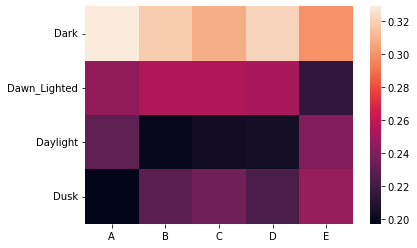


LGTCON_IM WKDY_IM
['Daylight', 'Dawn_Lighted', 'Dusk', 'Dark']
['Weekday', 'Weekend']

Count Crashes
              Weekday  Weekend   Total
Dark            36483    17038   53521
Dawn_Lighted    79924    35869  115793
Daylight       356168   103231  459399
Dusk            11982     3579   15561
Total          484557   159717  644274

Hospitalization Count
              Weekday  Weekend   Total
Dark             8043     4261   12304
Dawn_Lighted    14278     7057   21335
Daylight        50397    16989   67386
Dusk             1866      719    2585
Total           74584    29026  103610

Hospitalization Rate
              Weekday  Weekend  Total
Dark            0.220    0.250  0.470
Dawn_Lighted    0.179    0.197  0.376
Daylight        0.141    0.165  0.306
Dusk            0.156    0.201  0.357
Total           0.696    0.813  1.509

Rate Normalized by Row
              Weekday  Weekend  Total
Dark            0.469    0.531    1.0
Dawn_Lighted    0.476    0.524    1.0
Daylight        0.4

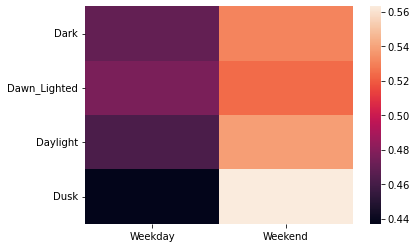


Rate Normalized by Column
              Weekday  Weekend  Total
Dark            0.317    0.308  0.625
Dawn_Lighted    0.257    0.242  0.499
Daylight        0.203    0.203  0.406
Dusk            0.224    0.247  0.471
Total           1.001    1.000  2.001

LGTCON_IM WKDY_IM


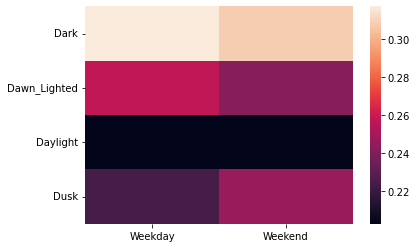


LGTCON_IM WRK_ZONE
['Daylight', 'Dawn_Lighted', 'Dusk', 'Dark']
['0', '1', '2', '3']

Count Crashes
                   0      1    2    3   Total
Dark           52313   1103   98    7   53521
Dawn_Lighted  113890   1800   95    8  115793
Daylight      450183   8466  587  163  459399
Dusk           15392    156   11    2   15561
Total         631778  11525  791  180  644274

Hospitalization Count
                   0     1    2   3   Total
Dark           12075   211   16   2   12304
Dawn_Lighted   21083   230   19   3   21335
Daylight       66316   959   79  32   67386
Dusk            2559    25    1   0    2585
Total         102033  1425  115  37  103610

Hospitalization Rate
                  0      1      2      3  Total
Dark          0.231  0.191  0.163  0.286  0.871
Dawn_Lighted  0.185  0.128  0.200  0.375  0.888
Daylight      0.147  0.113  0.135  0.196  0.591
Dusk          0.166  0.160  0.091  0.000  0.417
Total         0.729  0.592  0.589  0.857  2.767

Rate Normalized by Row
  

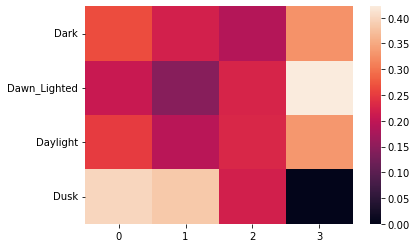


Rate Normalized by Column
                  0      1      2      3  Total
Dark          0.316  0.323  0.277  0.333  1.249
Dawn_Lighted  0.254  0.216  0.340  0.438  1.248
Daylight      0.202  0.191  0.229  0.229  0.851
Dusk          0.228  0.270  0.154  0.000  0.652
Total         1.000  1.000  1.000  1.000  4.000

LGTCON_IM WRK_ZONE


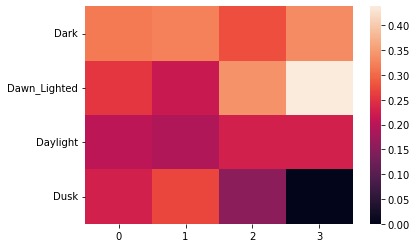


MONTH PEDS
['Winter', 'Spring_Fall', 'Summer']
['0', '1', 'Multiple']

Count Crashes
                  0      1  Multiple   Total
Spring_Fall  199449  16509       866  216824
Summer       207457  17470       795  225722
Winter       186396  14561       771  201728
Total        593302  48540      2432  644274

Hospitalization Count
                 0      1  Multiple   Total
Spring_Fall  29562   4667       358   34587
Summer       33230   4867       306   38403
Winter       26111   4205       304   30620
Total        88903  13739       968  103610

Hospitalization Rate
                 0      1  Multiple  Total
Spring_Fall  0.148  0.283     0.413  0.844
Summer       0.160  0.279     0.385  0.824
Winter       0.140  0.289     0.394  0.823
Total        0.448  0.851     1.192  2.491

Rate Normalized by Row
                 0      1  Multiple  Total
Spring_Fall  0.176  0.335     0.490  1.001
Summer       0.194  0.338     0.467  0.999
Winter       0.170  0.351     0.479  1.000
Total        

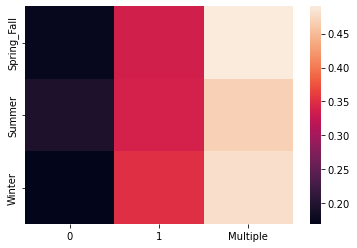


Rate Normalized by Column
                 0      1  Multiple  Total
Spring_Fall  0.330  0.333     0.347  1.010
Summer       0.357  0.328     0.323  1.008
Winter       0.312  0.340     0.331  0.983
Total        0.999  1.001     1.001  3.001

MONTH PEDS


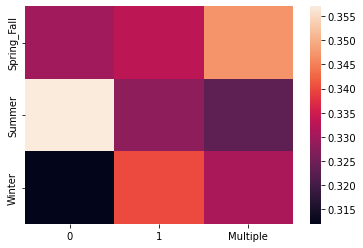


MONTH PERMVIT
['Winter', 'Spring_Fall', 'Summer']
['2', 'Multiple', '1']

Count Crashes
                 1       2  Multiple   Total
Spring_Fall  30748   68637    117439  216824
Summer       31128   69599    124995  225722
Winter       28348   65511    107869  201728
Total        90224  203747    350303  644274

Hospitalization Count
                 1      2  Multiple   Total
Spring_Fall   8777   9185     16625   34587
Summer        9703  10153     18547   38403
Winter        7618   8011     14991   30620
Total        26098  27349     50163  103610

Hospitalization Rate
                 1      2  Multiple  Total
Spring_Fall  0.285  0.134     0.142  0.561
Summer       0.312  0.146     0.148  0.606
Winter       0.269  0.122     0.139  0.530
Total        0.866  0.402     0.429  1.697

Rate Normalized by Row
                 1      2  Multiple  Total
Spring_Fall  0.509  0.239     0.252    1.0
Summer       0.514  0.241     0.245    1.0
Winter       0.507  0.231     0.262    1.0
Total     

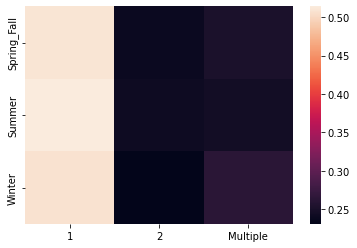


Rate Normalized by Column
                1      2  Multiple  Total
Spring_Fall  0.33  0.333     0.330  0.993
Summer       0.36  0.363     0.346  1.069
Winter       0.31  0.304     0.324  0.938
Total        1.00  1.000     1.000  3.000

MONTH PERMVIT


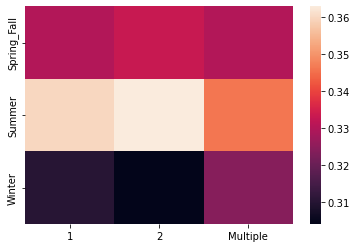


MONTH REL_ROAD
['Winter', 'Spring_Fall', 'Summer']
['On_Road', 'Not_on_Road', 'Parking_Area']

Count Crashes
             Not_on_Road  On_Road  Parking_Area   Total
Spring_Fall        20140   193311          3373  216824
Summer             21628   200574          3520  225722
Winter             21132   177400          3196  201728
Total              62900   571285         10089  644274

Hospitalization Count
             Not_on_Road  On_Road  Parking_Area   Total
Spring_Fall         6957    27269           361   34587
Summer              7953    30036           414   38403
Winter              6230    24114           276   30620
Total              21140    81419          1051  103610

Hospitalization Rate
             Not_on_Road  On_Road  Parking_Area  Total
Spring_Fall        0.345    0.141         0.107  0.593
Summer             0.368    0.150         0.118  0.636
Winter             0.295    0.136         0.086  0.517
Total              1.008    0.427         0.311  1.746

Rate Norm

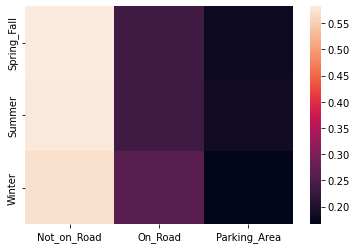


Rate Normalized by Column
             Not_on_Road  On_Road  Parking_Area  Total
Spring_Fall        0.343    0.331         0.344  1.018
Summer             0.365    0.351         0.378  1.094
Winter             0.292    0.319         0.278  0.889
Total              1.000    1.001         1.000  3.001

MONTH REL_ROAD


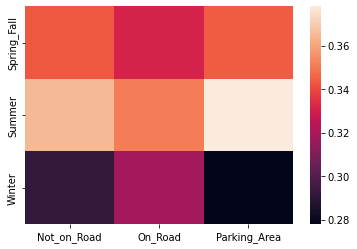


MONTH RELJCT2_IM
['Winter', 'Spring_Fall', 'Summer']
['B', 'A', 'C', 'D']

Count Crashes
                  A       B      C       D   Total
Spring_Fall   58009   84134  20634   54047  216824
Summer        61523   86343  22059   55797  225722
Winter        53592   78563  18248   51325  201728
Total        173124  249040  60941  161169  644274

Hospitalization Count
                 A      B     C      D   Total
Spring_Fall  11148  14260  2953   6226   34587
Summer       12294  16243  3219   6647   38403
Winter        9717  12881  2250   5772   30620
Total        33159  43384  8422  18645  103610

Hospitalization Rate
                 A      B      C      D  Total
Spring_Fall  0.192  0.169  0.143  0.115  0.619
Summer       0.200  0.188  0.146  0.119  0.653
Winter       0.181  0.164  0.123  0.112  0.580
Total        0.573  0.521  0.412  0.346  1.852

Rate Normalized by Row
                 A      B      C      D  Total
Spring_Fall  0.310  0.273  0.231  0.186  1.000
Summer       0.306  0.

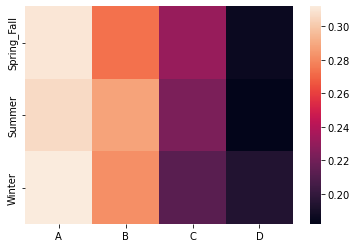


Rate Normalized by Column
                 A      B      C      D  Total
Spring_Fall  0.335  0.325  0.347  0.332  1.339
Summer       0.349  0.361  0.354  0.344  1.408
Winter       0.316  0.314  0.299  0.324  1.253
Total        1.000  1.000  1.000  1.000  4.000

MONTH RELJCT2_IM


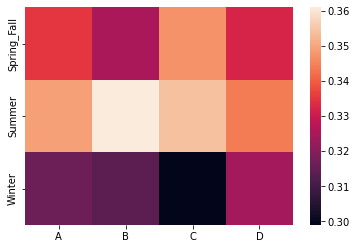


MONTH SCH_BUS
['Winter', 'Spring_Fall', 'Summer']
['0', '1']

Count Crashes
                  0     1   Total
Spring_Fall  215576  1248  216824
Summer       225040   682  225722
Winter       200404  1324  201728
Total        641020  3254  644274

Hospitalization Count
                  0    1   Total
Spring_Fall   34428  159   34587
Summer        38323   80   38403
Winter        30458  162   30620
Total        103209  401  103610

Hospitalization Rate
                 0      1  Total
Spring_Fall  0.160  0.127  0.287
Summer       0.170  0.117  0.287
Winter       0.152  0.122  0.274
Total        0.482  0.366  0.848

Rate Normalized by Row
                 0      1  Total
Spring_Fall  0.556  0.444    1.0
Summer       0.592  0.408    1.0
Winter       0.554  0.446    1.0
Total        1.702  1.298    3.0

MONTH SCH_BUS


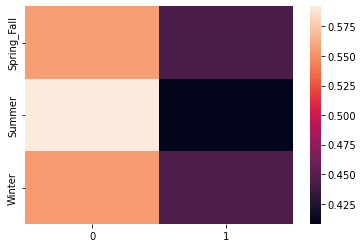


Rate Normalized by Column
                 0      1  Total
Spring_Fall  0.331  0.347  0.678
Summer       0.353  0.320  0.673
Winter       0.315  0.333  0.648
Total        0.999  1.000  1.999

MONTH SCH_BUS


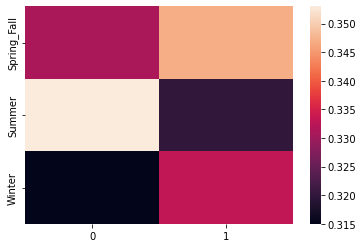


MONTH URBANICITY
['Winter', 'Spring_Fall', 'Summer']
['2', '1']

Count Crashes
                  1       2   Total
Spring_Fall  169582   47242  216824
Summer       175452   50270  225722
Winter       158739   42989  201728
Total        503773  140501  644274

Hospitalization Count
                 1      2   Total
Spring_Fall  26745   7842   34587
Summer       29152   9251   38403
Winter       23874   6746   30620
Total        79771  23839  103610

Hospitalization Rate
                 1      2  Total
Spring_Fall  0.158  0.166  0.324
Summer       0.166  0.184  0.350
Winter       0.150  0.157  0.307
Total        0.474  0.507  0.981

Rate Normalized by Row
                 1      2  Total
Spring_Fall  0.487  0.513    1.0
Summer       0.474  0.526    1.0
Winter       0.489  0.511    1.0
Total        1.450  1.550    3.0

MONTH URBANICITY


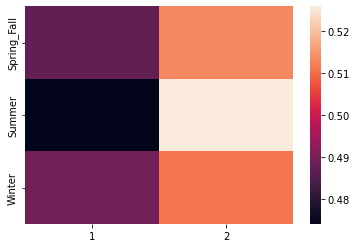


Rate Normalized by Column
                 1      2  Total
Spring_Fall  0.333  0.327  0.660
Summer       0.350  0.363  0.713
Winter       0.317  0.310  0.627
Total        1.000  1.000  2.000

MONTH URBANICITY


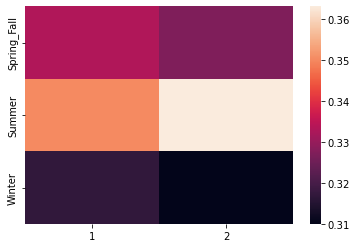


MONTH VE_TOTAL
['Winter', 'Spring_Fall', 'Summer']
['2', '1', 'Multiple', '3']

Count Crashes
                  1       2      3  Multiple   Total
Spring_Fall   40209  145138  23410      8067  216824
Summer        40903  152201  24430      8188  225722
Winter        36593  136667  21373      7095  201728
Total        117705  434006  69213     23350  644274

Hospitalization Count
                 1      2      3  Multiple   Total
Spring_Fall  11747  17876   3612      1352   34587
Summer       13224  19882   3858      1439   38403
Winter       10165  15990   3239      1226   30620
Total        35136  53748  10709      4017  103610

Hospitalization Rate
                 1      2      3  Multiple  Total
Spring_Fall  0.292  0.123  0.154     0.168  0.737
Summer       0.323  0.131  0.158     0.176  0.788
Winter       0.278  0.117  0.152     0.173  0.720
Total        0.893  0.371  0.464     0.517  2.245

Rate Normalized by Row
                 1      2      3  Multiple  Total
Spring_Fall  0.3

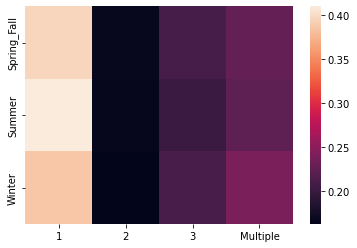


Rate Normalized by Column
                 1      2      3  Multiple  Total
Spring_Fall  0.327  0.332  0.333     0.325  1.317
Summer       0.362  0.352  0.341     0.340  1.395
Winter       0.311  0.316  0.327     0.335  1.289
Total        1.000  1.000  1.001     1.000  4.001

MONTH VE_TOTAL


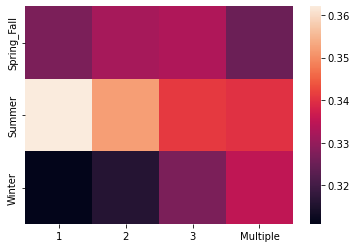


MONTH WEATHR_IM
['Winter', 'Spring_Fall', 'Summer']
['B', 'A', 'D', 'C', 'E']

Count Crashes
                A       B      C      D      E   Total
Spring_Fall   726  160772  21399  32128   1799  216824
Summer        404  177333  17173  30656    156  225722
Winter       1933  134463  21333  34667   9332  201728
Total        3063  472568  59905  97451  11287  644274

Hospitalization Count
               A      B     C      D     E   Total
Spring_Fall  158  25807  3351   5019   252   34587
Summer        82  30409  2743   5149    20   38403
Winter       396  20456  3479   5146  1143   30620
Total        636  76672  9573  15314  1415  103610

Hospitalization Rate
                 A      B      C      D      E  Total
Spring_Fall  0.218  0.161  0.157  0.156  0.140  0.832
Summer       0.203  0.171  0.160  0.168  0.128  0.830
Winter       0.205  0.152  0.163  0.148  0.122  0.790
Total        0.626  0.484  0.480  0.472  0.390  2.452

Rate Normalized by Row
                 A      B      C     

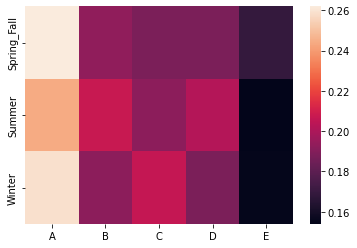


Rate Normalized by Column
                 A      B      C      D      E  Total
Spring_Fall  0.348  0.332  0.327  0.331  0.358  1.696
Summer       0.325  0.354  0.333  0.355  0.328  1.695
Winter       0.328  0.314  0.340  0.314  0.313  1.609
Total        1.001  1.000  1.000  1.000  0.999  5.000

MONTH WEATHR_IM


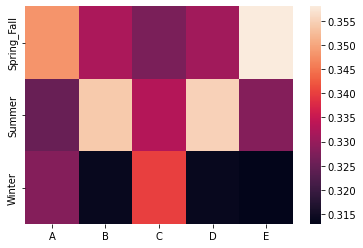


MONTH WKDY_IM
['Winter', 'Spring_Fall', 'Summer']
['Weekday', 'Weekend']

Count Crashes
             Weekday  Weekend   Total
Spring_Fall   163203    53621  216824
Summer        168580    57142  225722
Winter        152774    48954  201728
Total         484557   159717  644274

Hospitalization Count
             Weekday  Weekend   Total
Spring_Fall    24888     9699   34587
Summer         27301    11102   38403
Winter         22395     8225   30620
Total          74584    29026  103610

Hospitalization Rate
             Weekday  Weekend  Total
Spring_Fall    0.152    0.181  0.333
Summer         0.162    0.194  0.356
Winter         0.147    0.168  0.315
Total          0.461    0.543  1.004

Rate Normalized by Row
             Weekday  Weekend  Total
Spring_Fall    0.457    0.543    1.0
Summer         0.455    0.545    1.0
Winter         0.466    0.534    1.0
Total          1.378    1.622    3.0

MONTH WKDY_IM


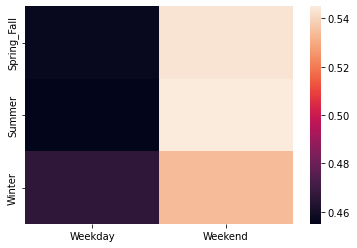


Rate Normalized by Column
             Weekday  Weekend  Total
Spring_Fall    0.331    0.333  0.664
Summer         0.351    0.358  0.709
Winter         0.318    0.309  0.627
Total          1.000    1.000  2.000

MONTH WKDY_IM


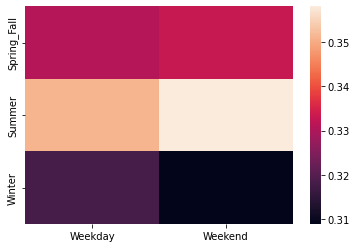


MONTH WRK_ZONE
['Winter', 'Spring_Fall', 'Summer']
['0', '1', '2', '3']

Count Crashes
                  0      1    2    3   Total
Spring_Fall  212504   3961  284   75  216824
Summer       220513   4852  300   57  225722
Winter       198761   2712  207   48  201728
Total        631778  11525  791  180  644274

Hospitalization Count
                  0     1    2   3   Total
Spring_Fall   34075   464   31  17   34587
Summer        37757   588   49   9   38403
Winter        30201   373   35  11   30620
Total        102033  1425  115  37  103610

Hospitalization Rate
                 0      1      2      3  Total
Spring_Fall  0.160  0.117  0.109  0.227  0.613
Summer       0.171  0.121  0.163  0.158  0.613
Winter       0.152  0.138  0.169  0.229  0.688
Total        0.483  0.376  0.441  0.614  1.914

Rate Normalized by Row
                 0      1      2      3  Total
Spring_Fall  0.261  0.191  0.178  0.370  1.000
Summer       0.279  0.197  0.266  0.257  0.999
Winter       0.221  0.200  

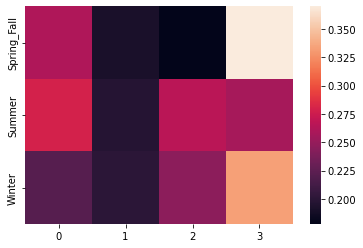


Rate Normalized by Column
                 0      1      2      3  Total
Spring_Fall  0.332  0.312  0.247  0.369  1.260
Summer       0.354  0.322  0.370  0.257  1.303
Winter       0.314  0.366  0.383  0.373  1.436
Total        1.000  1.000  1.000  0.999  3.999

MONTH WRK_ZONE


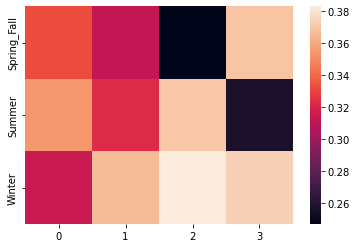


PEDS PERMVIT
['0', '1', 'Multiple']
['2', 'Multiple', '1']

Count Crashes
              1       2  Multiple   Total
0         52660  195635    345007  593302
1         35893    7663      4984   48540
Multiple   1671     449       312    2432
Total     90224  203747    350303  644274

Hospitalization Count
              1      2  Multiple   Total
0         14269  25431     49203   88903
1         11135   1750       854   13739
Multiple    694    168       106     968
Total     26098  27349     50163  103610

Hospitalization Rate
              1      2  Multiple  Total
0         0.271  0.130     0.143  0.544
1         0.310  0.228     0.171  0.709
Multiple  0.415  0.374     0.340  1.129
Total     0.996  0.732     0.654  2.382

Rate Normalized by Row
              1      2  Multiple  Total
0         0.498  0.239     0.262  0.999
1         0.437  0.322     0.241  1.000
Multiple  0.368  0.331     0.301  1.000
Total     1.303  0.892     0.804  2.999

PEDS PERMVIT


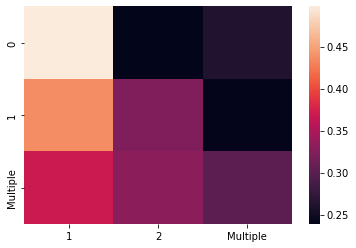


Rate Normalized by Column
              1      2  Multiple  Total
0         0.272  0.177     0.218  0.667
1         0.311  0.312     0.262  0.885
Multiple  0.417  0.511     0.520  1.448
Total     1.000  1.000     1.000  3.000

PEDS PERMVIT


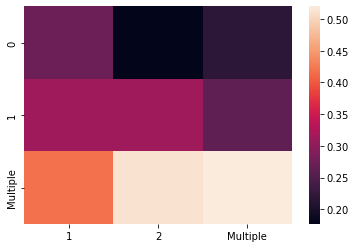


PEDS REL_ROAD
['0', '1', 'Multiple']
['On_Road', 'Not_on_Road', 'Parking_Area']

Count Crashes
          Not_on_Road  On_Road  Parking_Area   Total
0               60286   523609          9407  593302
1                2314    45612           614   48540
Multiple          300     2064            68    2432
Total           62900   571285         10089  644274

Hospitalization Count
          Not_on_Road  On_Road  Parking_Area   Total
0               20315    67711           877   88903
1                 687    12901           151   13739
Multiple          138      807            23     968
Total           21140    81419          1051  103610

Hospitalization Rate
          Not_on_Road  On_Road  Parking_Area  Total
0               0.337    0.129         0.093  0.559
1               0.297    0.283         0.246  0.826
Multiple        0.460    0.391         0.338  1.189
Total           1.094    0.803         0.677  2.574

Rate Normalized by Row
          Not_on_Road  On_Road  Parking_Area 

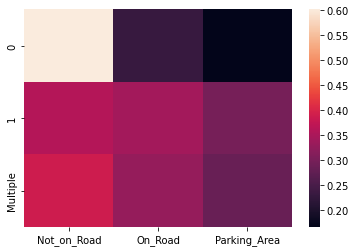


Rate Normalized by Column
          Not_on_Road  On_Road  Parking_Area  Total
0               0.308    0.161         0.138  0.607
1               0.271    0.352         0.363  0.986
Multiple        0.421    0.487         0.499  1.407
Total           1.000    1.000         1.000  3.000

PEDS REL_ROAD


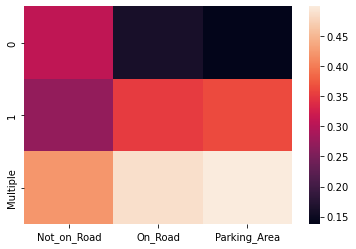


PEDS RELJCT2_IM
['0', '1', 'Multiple']
['B', 'A', 'C', 'D']

Count Crashes
               A       B      C       D   Total
0         165268  232543  56070  139421  593302
1           7441   15635   4682   20782   48540
Multiple     415     862    189     966    2432
Total     173124  249040  60941  161169  644274

Hospitalization Count
              A      B     C      D   Total
0         30941  38223  7269  12470   88903
1          2051   4771  1098   5819   13739
Multiple    167    390    55    356     968
Total     33159  43384  8422  18645  103610

Hospitalization Rate
              A      B      C      D  Total
0         0.187  0.164  0.130  0.089  0.570
1         0.276  0.305  0.235  0.280  1.096
Multiple  0.402  0.452  0.291  0.369  1.514
Total     0.865  0.921  0.656  0.738  3.180

Rate Normalized by Row
              A      B      C      D  Total
0         0.328  0.288  0.227  0.157  1.000
1         0.252  0.279  0.214  0.256  1.001
Multiple  0.266  0.299  0.192  0.243  1.000

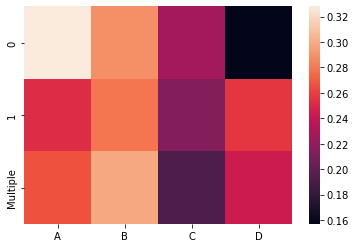


Rate Normalized by Column
              A      B      C      D  Total
0         0.216  0.178  0.198  0.121  0.713
1         0.319  0.331  0.358  0.379  1.387
Multiple  0.465  0.491  0.444  0.499  1.899
Total     1.000  1.000  1.000  0.999  3.999

PEDS RELJCT2_IM


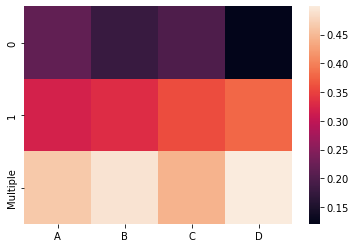


PEDS SCH_BUS
['0', '1', 'Multiple']
['0', '1']

Count Crashes
               0     1   Total
0         590282  3020  593302
1          48328   212   48540
Multiple    2410    22    2432
Total     641020  3254  644274

Hospitalization Count
               0    1   Total
0          88579  324   88903
1          13672   67   13739
Multiple     958   10     968
Total     103209  401  103610

Hospitalization Rate
              0      1  Total
0         0.150  0.107  0.257
1         0.283  0.316  0.599
Multiple  0.398  0.455  0.853
Total     0.831  0.878  1.709

Rate Normalized by Row
              0      1  Total
0         0.583  0.417    1.0
1         0.472  0.528    1.0
Multiple  0.467  0.533    1.0
Total     1.522  1.478    3.0

PEDS SCH_BUS


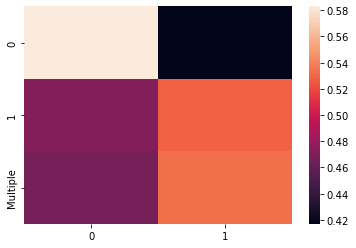


Rate Normalized by Column
              0      1  Total
0         0.181  0.122  0.303
1         0.341  0.360  0.701
Multiple  0.479  0.518  0.997
Total     1.001  1.000  2.001

PEDS SCH_BUS


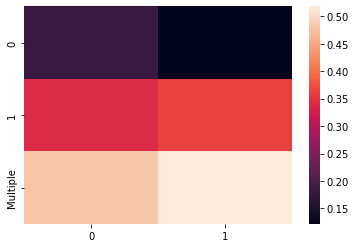


PEDS URBANICITY
['0', '1', 'Multiple']
['2', '1']

Count Crashes
               1       2   Total
0         459368  133934  593302
1          42414    6126   48540
Multiple    1991     441    2432
Total     503773  140501  644274

Hospitalization Count
              1      2   Total
0         66810  22093   88903
1         12147   1592   13739
Multiple    814    154     968
Total     79771  23839  103610

Hospitalization Rate
              1      2  Total
0         0.145  0.165  0.310
1         0.286  0.260  0.546
Multiple  0.409  0.349  0.758
Total     0.840  0.774  1.614

Rate Normalized by Row
              1      2  Total
0         0.469  0.531    1.0
1         0.524  0.476    1.0
Multiple  0.539  0.461    1.0
Total     1.532  1.468    3.0

PEDS URBANICITY


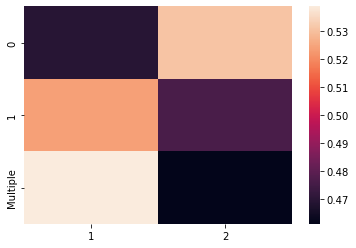


Rate Normalized by Column
              1      2  Total
0         0.173  0.213  0.386
1         0.341  0.336  0.677
Multiple  0.486  0.451  0.937
Total     1.000  1.000  2.000

PEDS URBANICITY


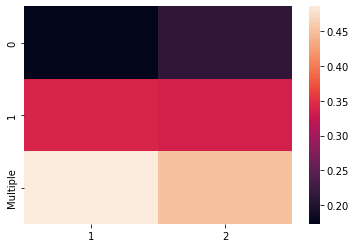


PEDS VE_TOTAL
['0', '1', 'Multiple']
['2', '1', 'Multiple', '3']

Count Crashes
               1       2      3  Multiple   Total
0          69830  431829  68622     23021  593302
1          45935    1852    472       281   48540
Multiple    1940     325    119        48    2432
Total     117705  434006  69213     23350  644274

Hospitalization Count
              1      2      3  Multiple   Total
0         21382  53102  10518      3901   88903
1         13001    512    130        96   13739
Multiple    753    134     61        20     968
Total     35136  53748  10709      4017  103610

Hospitalization Rate
              1      2      3  Multiple  Total
0         0.306  0.123  0.153     0.169  0.751
1         0.283  0.276  0.275     0.342  1.176
Multiple  0.388  0.412  0.513     0.417  1.730
Total     0.977  0.811  0.941     0.928  3.657

Rate Normalized by Row
              1      2      3  Multiple  Total
0         0.407  0.164  0.204     0.225  1.000
1         0.241  0.235  0.234  

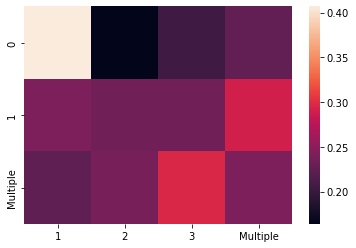


Rate Normalized by Column
              1      2      3  Multiple  Total
0         0.313  0.151  0.163     0.183  0.810
1         0.290  0.341  0.293     0.368  1.292
Multiple  0.397  0.508  0.545     0.449  1.899
Total     1.000  1.000  1.001     1.000  4.001

PEDS VE_TOTAL


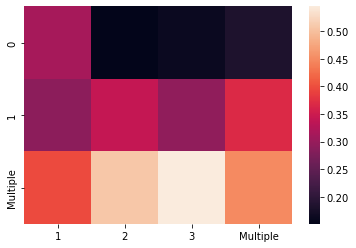


PEDS WEATHR_IM
['0', '1', 'Multiple']
['B', 'A', 'D', 'C', 'E']

Count Crashes
             A       B      C      D      E   Total
0         2878  432484  55810  91268  10862  593302
1          179   38163   3852   5947    399   48540
Multiple     6    1921    243    236     26    2432
Total     3063  472568  59905  97451  11287  644274

Hospitalization Count
            A      B     C      D     E   Total
0         584  65211  8293  13528  1287   88903
1          51  10713  1169   1688   118   13739
Multiple    1    748   111     98    10     968
Total     636  76672  9573  15314  1415  103610

Hospitalization Rate
              A      B      C      D      E  Total
0         0.203  0.151  0.149  0.148  0.118  0.769
1         0.285  0.281  0.303  0.284  0.296  1.449
Multiple  0.167  0.389  0.457  0.415  0.385  1.813
Total     0.655  0.821  0.909  0.847  0.799  4.031

Rate Normalized by Row
              A      B      C      D      E  Total
0         0.264  0.196  0.193  0.193  0.154  

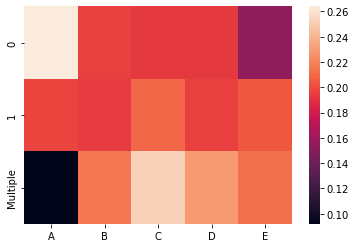


Rate Normalized by Column
              A      B      C      D      E  Total
0         0.310  0.184  0.163  0.175  0.148  0.980
1         0.435  0.342  0.334  0.335  0.370  1.816
Multiple  0.255  0.474  0.503  0.490  0.481  2.203
Total     1.000  1.000  1.000  1.000  0.999  4.999

PEDS WEATHR_IM


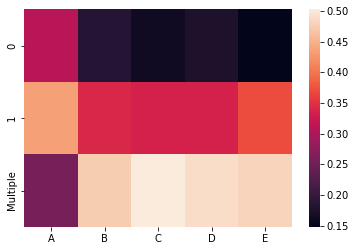


PEDS WKDY_IM
['0', '1', 'Multiple']
['Weekday', 'Weekend']

Count Crashes
          Weekday  Weekend   Total
0          445696   147606  593302
1           37103    11437   48540
Multiple     1758      674    2432
Total      484557   159717  644274

Hospitalization Count
          Weekday  Weekend   Total
0           63417    25486   88903
1           10486     3253   13739
Multiple      681      287     968
Total       74584    29026  103610

Hospitalization Rate
          Weekday  Weekend  Total
0           0.142    0.173  0.315
1           0.283    0.284  0.567
Multiple    0.387    0.426  0.813
Total       0.812    0.883  1.695

Rate Normalized by Row
          Weekday  Weekend  Total
0           0.452    0.548    1.0
1           0.498    0.502    1.0
Multiple    0.476    0.524    1.0
Total       1.426    1.574    3.0

PEDS WKDY_IM


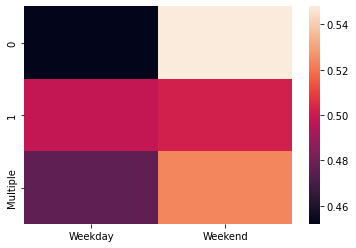


Rate Normalized by Column
          Weekday  Weekend  Total
0           0.175    0.196  0.371
1           0.348    0.322  0.670
Multiple    0.477    0.482  0.959
Total       1.000    1.000  2.000

PEDS WKDY_IM


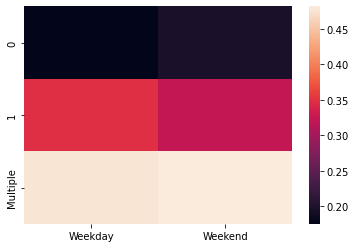


PEDS WRK_ZONE
['0', '1', 'Multiple']
['0', '1', '2', '3']

Count Crashes
               0      1    2    3   Total
0         581373  10997  767  165  593302
1          48000    508   24    8   48540
Multiple    2405     20    0    7    2432
Total     631778  11525  791  180  644274

Hospitalization Count
               0     1    2   3   Total
0          87479  1286  107  31   88903
1          13598   131    8   2   13739
Multiple     956     8    0   4     968
Total     102033  1425  115  37  103610

Hospitalization Rate
              0      1      2      3  Total
0         0.150  0.117  0.140  0.188  0.595
1         0.283  0.258  0.333  0.250  1.124
Multiple  0.398  0.400    NaN  0.571  1.369
Total     0.831  0.775  0.473  1.009  3.088

Rate Normalized by Row
              0      1      2      3  Total
0         0.253  0.197  0.235  0.316  1.001
1         0.252  0.229  0.296  0.222  0.999
Multiple  0.290  0.292    NaN  0.417  0.999
Total     0.795  0.718  0.531  0.955  2.999

PEDS W

/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_11277/550312234.py:69: RuntimeWarning: invalid value encountered in true_divide
  F = pd.DataFrame(E/D, index=B, columns=C).round(3)
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_11277/550312234.py:96: RuntimeWarning: invalid value encountered in true_divide
  F = pd.DataFrame(E/D, index=B, columns=C)


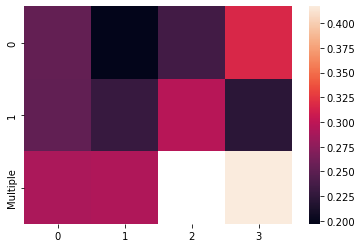


Rate Normalized by Column
              0      1      2      3  Total
0         0.181  0.151  0.295  0.186  0.813
1         0.341  0.333  0.705  0.248  1.627
Multiple  0.478  0.516    NaN  0.566  1.560
Total     1.000  1.000  1.000  1.000  4.000

PEDS WRK_ZONE


/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_11277/550312234.py:137: RuntimeWarning: invalid value encountered in true_divide
  F = pd.DataFrame(E/D, index=B, columns=C)


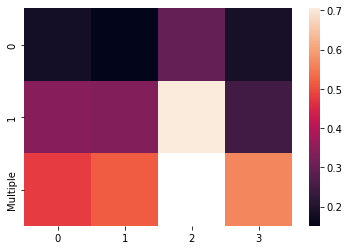


PERMVIT REL_ROAD
['2', 'Multiple', '1']
['On_Road', 'Not_on_Road', 'Parking_Area']

Count Crashes
          Not_on_Road  On_Road  Parking_Area   Total
1               35133    47316          7775   90224
2               14477   187907          1363  203747
Multiple        13290   336062           951  350303
Total           62900   571285         10089  644274

Hospitalization Count
          Not_on_Road  On_Road  Parking_Area   Total
1               12043    13338           717   26098
2                4860    22298           191   27349
Multiple         4237    45783           143   50163
Total           21140    81419          1051  103610

Hospitalization Rate
          Not_on_Road  On_Road  Parking_Area  Total
1               0.343    0.282         0.092  0.717
2               0.336    0.119         0.140  0.595
Multiple        0.319    0.136         0.150  0.605
Total           0.998    0.537         0.382  1.917

Rate Normalized by Row
          Not_on_Road  On_Road  Parking_Ar

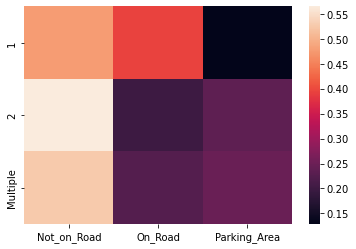


Rate Normalized by Column
          Not_on_Road  On_Road  Parking_Area  Total
1               0.344    0.525         0.241  1.110
2               0.337    0.221         0.366  0.924
Multiple        0.320    0.254         0.393  0.967
Total           1.001    1.000         1.000  3.001

PERMVIT REL_ROAD


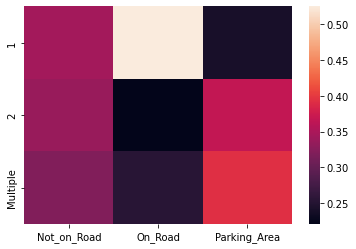


PERMVIT RELJCT2_IM
['2', 'Multiple', '1']
['B', 'A', 'C', 'D']

Count Crashes
               A       B      C       D   Total
1           8445   52275   6162   23342   90224
2          58925   72247  21304   51271  203747
Multiple  105754  124518  33475   86556  350303
Total     173124  249040  60941  161169  644274

Hospitalization Count
              A      B     C      D   Total
1          2737  15260  1273   6828   26098
2         10122  10563  2509   4155   27349
Multiple  20300  17561  4640   7662   50163
Total     33159  43384  8422  18645  103610

Hospitalization Rate
              A      B      C      D  Total
1         0.324  0.292  0.207  0.293  1.116
2         0.172  0.146  0.118  0.081  0.517
Multiple  0.192  0.141  0.139  0.089  0.561
Total     0.688  0.579  0.464  0.463  2.194

Rate Normalized by Row
              A      B      C      D  Total
1         0.291  0.262  0.185  0.262    1.0
2         0.332  0.283  0.228  0.157    1.0
Multiple  0.343  0.252  0.247  0.158    

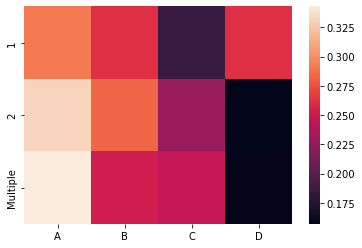


Rate Normalized by Column
              A      B      C      D  Total
1         0.471  0.504  0.446  0.633  2.054
2         0.250  0.252  0.254  0.175  0.931
Multiple  0.279  0.244  0.299  0.192  1.014
Total     1.000  1.000  0.999  1.000  3.999

PERMVIT RELJCT2_IM


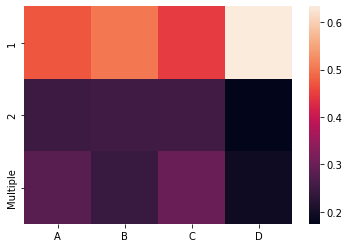


PERMVIT SCH_BUS
['2', 'Multiple', '1']
['0', '1']

Count Crashes
               0     1   Total
1          89771   453   90224
2         202335  1412  203747
Multiple  348914  1389  350303
Total     641020  3254  644274

Hospitalization Count
               0    1   Total
1          26021   77   26098
2          27262   87   27349
Multiple   49926  237   50163
Total     103209  401  103610

Hospitalization Rate
              0      1  Total
1         0.290  0.170  0.460
2         0.135  0.062  0.197
Multiple  0.143  0.171  0.314
Total     0.568  0.403  0.971

Rate Normalized by Row
              0      1  Total
1         0.630  0.370    1.0
2         0.686  0.314    1.0
Multiple  0.456  0.544    1.0
Total     1.772  1.228    3.0

PERMVIT SCH_BUS


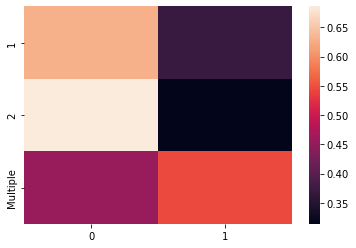


Rate Normalized by Column
              0      1  Total
1         0.511  0.423  0.934
2         0.237  0.153  0.390
Multiple  0.252  0.424  0.676
Total     1.000  1.000  2.000

PERMVIT SCH_BUS


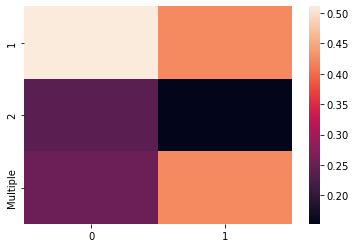


PERMVIT URBANICITY
['2', 'Multiple', '1']
['2', '1']

Count Crashes
               1       2   Total
1          66868   23356   90224
2         161764   41983  203747
Multiple  275141   75162  350303
Total     503773  140501  644274

Hospitalization Count
              1      2   Total
1         20161   5937   26098
2         21012   6337   27349
Multiple  38598  11565   50163
Total     79771  23839  103610

Hospitalization Rate
              1      2  Total
1         0.302  0.254  0.556
2         0.130  0.151  0.281
Multiple  0.140  0.154  0.294
Total     0.572  0.559  1.131

Rate Normalized by Row
              1      2  Total
1         0.543  0.457    1.0
2         0.463  0.537    1.0
Multiple  0.477  0.523    1.0
Total     1.483  1.517    3.0

PERMVIT URBANICITY


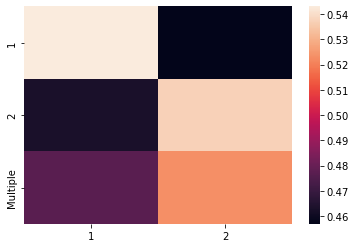


Rate Normalized by Column
              1      2  Total
1         0.527  0.455  0.982
2         0.227  0.270  0.497
Multiple  0.245  0.275  0.520
Total     0.999  1.000  1.999

PERMVIT URBANICITY


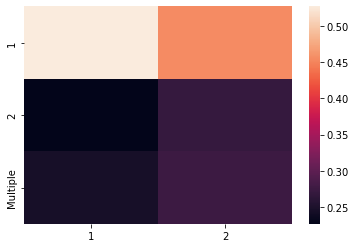


PERMVIT VE_TOTAL
['2', 'Multiple', '1']
['2', '1', 'Multiple', '3']

Count Crashes
               1       2      3  Multiple   Total
1          78555   10234   1082       353   90224
2          23100  178940   1289       418  203747
Multiple   16050  244832  66842     22579  350303
Total     117705  434006  69213     23350  644274

Hospitalization Count
              1      2      3  Multiple   Total
1         24584   1150    251       113   26098
2          6552  20312    361       124   27349
Multiple   4000  32286  10097      3780   50163
Total     35136  53748  10709      4017  103610

Hospitalization Rate
              1      2      3  Multiple  Total
1         0.313  0.112  0.232     0.320  0.977
2         0.284  0.114  0.280     0.297  0.975
Multiple  0.249  0.132  0.151     0.167  0.699
Total     0.846  0.358  0.663     0.784  2.651

Rate Normalized by Row
              1      2      3  Multiple  Total
1         0.320  0.115  0.237     0.328  1.000
2         0.291  0.117  0.28

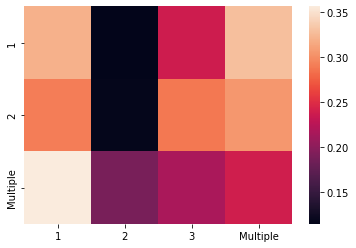


Rate Normalized by Column
              1      2      3  Multiple  Total
1         0.370  0.314  0.350     0.408  1.442
2         0.335  0.317  0.422     0.378  1.452
Multiple  0.295  0.369  0.228     0.213  1.105
Total     1.000  1.000  1.000     0.999  3.999

PERMVIT VE_TOTAL


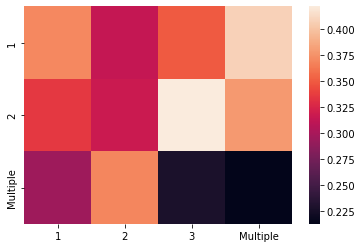


PERMVIT WEATHR_IM
['2', 'Multiple', '1']
['B', 'A', 'D', 'C', 'E']

Count Crashes
             A       B      C      D      E   Total
1          794   65874   8730  12443   2383   90224
2          964  149202  18983  30750   3848  203747
Multiple  1305  257492  32192  54258   5056  350303
Total     3063  472568  59905  97451  11287  644274

Hospitalization Count
            A      B     C      D     E   Total
1         192  19598  2318   3594   396   26098
2         166  20230  2530   4038   385   27349
Multiple  278  36844  4725   7682   634   50163
Total     636  76672  9573  15314  1415  103610

Hospitalization Rate
              A      B      C      D      E  Total
1         0.242  0.298  0.266  0.289  0.166  1.261
2         0.172  0.136  0.133  0.131  0.100  0.672
Multiple  0.213  0.143  0.147  0.142  0.125  0.770
Total     0.627  0.577  0.546  0.562  0.391  2.703

Rate Normalized by Row
              A      B      C      D      E  Total
1         0.192  0.236  0.211  0.229  0.13

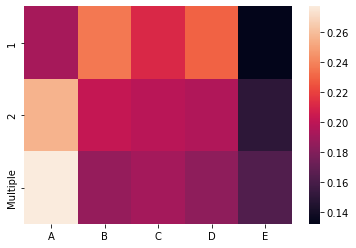


Rate Normalized by Column
              A      B      C      D      E  Total
1         0.386  0.516  0.487  0.514  0.424  2.327
2         0.275  0.235  0.244  0.234  0.255  1.243
Multiple  0.340  0.248  0.269  0.252  0.320  1.429
Total     1.001  0.999  1.000  1.000  0.999  4.999

PERMVIT WEATHR_IM


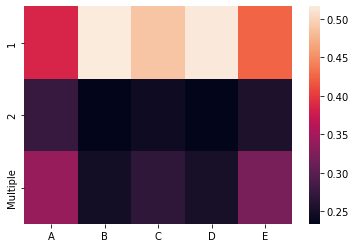


PERMVIT WKDY_IM
['2', 'Multiple', '1']
['Weekday', 'Weekend']

Count Crashes
          Weekday  Weekend   Total
1           65884    24340   90224
2          165089    38658  203747
Multiple   253584    96719  350303
Total      484557   159717  644274

Hospitalization Count
          Weekday  Weekend   Total
1           18572     7526   26098
2           20607     6742   27349
Multiple    35405    14758   50163
Total       74584    29026  103610

Hospitalization Rate
          Weekday  Weekend  Total
1           0.282    0.309  0.591
2           0.125    0.174  0.299
Multiple    0.140    0.153  0.293
Total       0.547    0.636  1.183

Rate Normalized by Row
          Weekday  Weekend  Total
1           0.477    0.523    1.0
2           0.417    0.583    1.0
Multiple    0.478    0.522    1.0
Total       1.372    1.628    3.0

PERMVIT WKDY_IM


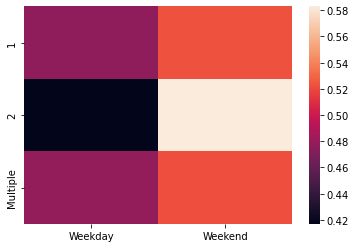


Rate Normalized by Column
          Weekday  Weekend  Total
1           0.516    0.486  1.002
2           0.228    0.274  0.502
Multiple    0.256    0.240  0.496
Total       1.000    1.000  2.000

PERMVIT WKDY_IM


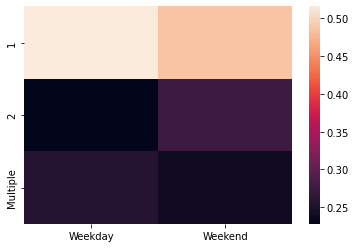


PERMVIT WRK_ZONE
['2', 'Multiple', '1']
['0', '1', '2', '3']

Count Crashes
               0      1    2    3   Total
1          88984   1103   93   44   90224
2         199963   3480  248   56  203747
Multiple  342831   6942  450   80  350303
Total     631778  11525  791  180  644274

Hospitalization Count
               0     1    2   3   Total
1          25786   277   23  12   26098
2          26953   362   26   8   27349
Multiple   49294   786   66  17   50163
Total     102033  1425  115  37  103610

Hospitalization Rate
              0      1      2      3  Total
1         0.290  0.251  0.247  0.273  1.061
2         0.135  0.104  0.105  0.143  0.487
Multiple  0.144  0.113  0.147  0.212  0.616
Total     0.569  0.468  0.499  0.628  2.164

Rate Normalized by Row
              0      1      2      3  Total
1         0.273  0.237  0.233  0.257    1.0
2         0.277  0.214  0.215  0.294    1.0
Multiple  0.233  0.184  0.238  0.345    1.0
Total     0.783  0.635  0.686  0.896    3.0

PER

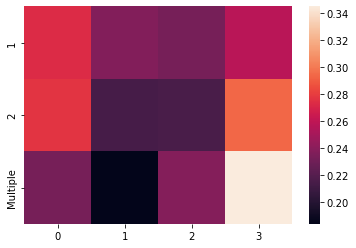


Rate Normalized by Column
              0      1      2      3  Total
1         0.510  0.536  0.496  0.434  1.976
2         0.237  0.222  0.210  0.227  0.896
Multiple  0.253  0.242  0.294  0.338  1.127
Total     1.000  1.000  1.000  0.999  3.999

PERMVIT WRK_ZONE


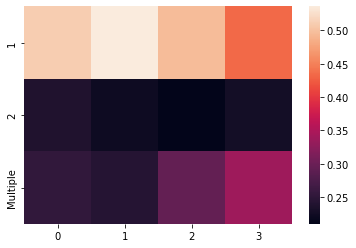


REL_ROAD RELJCT2_IM
['On_Road', 'Not_on_Road', 'Parking_Area']
['B', 'A', 'C', 'D']

Count Crashes
                   A       B      C       D   Total
Not_on_Road     3853   47546   2200    9301   62900
On_Road       169199  193793  57537  150756  571285
Parking_Area      72    7701   1204    1112   10089
Total         173124  249040  60941  161169  644274

Hospitalization Count
                  A      B     C      D   Total
Not_on_Road    1308  16972   453   2407   21140
On_Road       31828  25518  7934  16139   81419
Parking_Area     23    894    35     99    1051
Total         33159  43384  8422  18645  103610

Hospitalization Rate
                  A      B      C      D  Total
Not_on_Road   0.339  0.357  0.206  0.259  1.161
On_Road       0.188  0.132  0.138  0.107  0.565
Parking_Area  0.319  0.116  0.029  0.089  0.553
Total         0.846  0.605  0.373  0.455  2.279

Rate Normalized by Row
                  A      B      C      D  Total
Not_on_Road   0.292  0.307  0.177  0.223  0

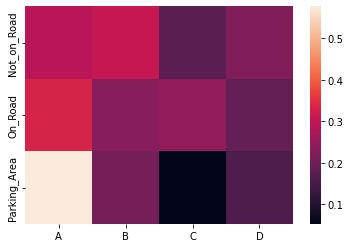


Rate Normalized by Column
                  A      B      C      D  Total
Not_on_Road   0.401  0.590  0.552  0.569  2.112
On_Road       0.222  0.218  0.370  0.235  1.045
Parking_Area  0.377  0.192  0.078  0.196  0.843
Total         1.000  1.000  1.000  1.000  4.000

REL_ROAD RELJCT2_IM


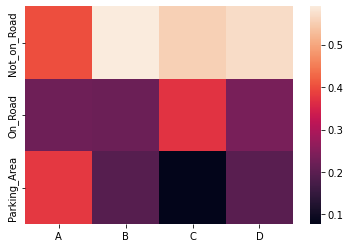


REL_ROAD SCH_BUS
['On_Road', 'Not_on_Road', 'Parking_Area']
['0', '1']

Count Crashes
                   0     1   Total
Not_on_Road    62739   161   62900
On_Road       568361  2924  571285
Parking_Area    9920   169   10089
Total         641020  3254  644274

Hospitalization Count
                   0    1   Total
Not_on_Road    21107   33   21140
On_Road        81054  365   81419
Parking_Area    1048    3    1051
Total         103209  401  103610

Hospitalization Rate
                  0      1  Total
Not_on_Road   0.336  0.205  0.541
On_Road       0.143  0.125  0.268
Parking_Area  0.106  0.018  0.124
Total         0.585  0.348  0.933

Rate Normalized by Row
                  0      1  Total
Not_on_Road   0.621  0.379    1.0
On_Road       0.533  0.467    1.0
Parking_Area  0.856  0.144    1.0
Total         2.010  0.990    3.0

REL_ROAD SCH_BUS


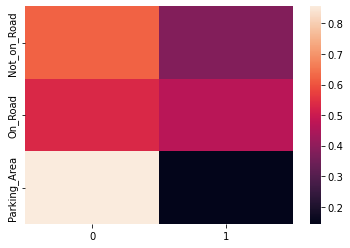


Rate Normalized by Column
                  0      1  Total
Not_on_Road   0.575  0.590  1.165
On_Road       0.244  0.359  0.603
Parking_Area  0.181  0.051  0.232
Total         1.000  1.000  2.000

REL_ROAD SCH_BUS


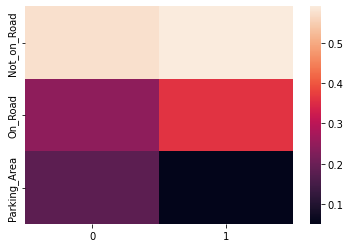


REL_ROAD URBANICITY
['On_Road', 'Not_on_Road', 'Parking_Area']
['2', '1']

Count Crashes
                   1       2   Total
Not_on_Road    41336   21564   62900
On_Road       454068  117217  571285
Parking_Area    8369    1720   10089
Total         503773  140501  644274

Hospitalization Count
                  1      2   Total
Not_on_Road   14026   7114   21140
On_Road       64823  16596   81419
Parking_Area    922    129    1051
Total         79771  23839  103610

Hospitalization Rate
                  1      2  Total
Not_on_Road   0.339  0.330  0.669
On_Road       0.143  0.142  0.285
Parking_Area  0.110  0.075  0.185
Total         0.592  0.547  1.139

Rate Normalized by Row
                  1      2  Total
Not_on_Road   0.507  0.493    1.0
On_Road       0.502  0.498    1.0
Parking_Area  0.595  0.405    1.0
Total         1.604  1.396    3.0

REL_ROAD URBANICITY


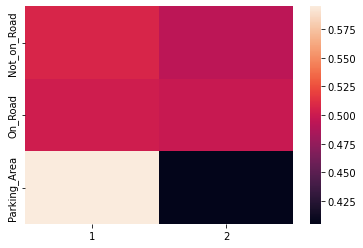


Rate Normalized by Column
                  1      2  Total
Not_on_Road   0.573  0.604  1.177
On_Road       0.241  0.259  0.500
Parking_Area  0.186  0.137  0.323
Total         1.000  1.000  2.000

REL_ROAD URBANICITY


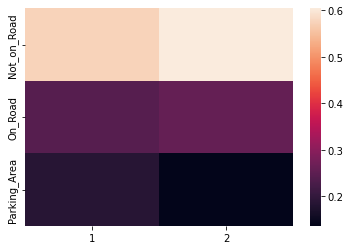


REL_ROAD VE_TOTAL
['On_Road', 'Not_on_Road', 'Parking_Area']
['2', '1', 'Multiple', '3']

Count Crashes
                   1       2      3  Multiple   Total
Not_on_Road    53670    7083   1354       793   62900
On_Road        63764  418527  66839     22155  571285
Parking_Area     271    8396   1020       402   10089
Total         117705  434006  69213     23350  644274

Hospitalization Count
                  1      2      3  Multiple   Total
Not_on_Road   18909   1594    400       237   21140
On_Road       16166  51483  10115      3655   81419
Parking_Area     61    671    194       125    1051
Total         35136  53748  10709      4017  103610

Hospitalization Rate
                  1      2      3  Multiple  Total
Not_on_Road   0.352  0.225  0.295     0.299  1.171
On_Road       0.254  0.123  0.151     0.165  0.693
Parking_Area  0.225  0.080  0.190     0.311  0.806
Total         0.831  0.428  0.636     0.775  2.670

Rate Normalized by Row
                  1      2      3  Multip

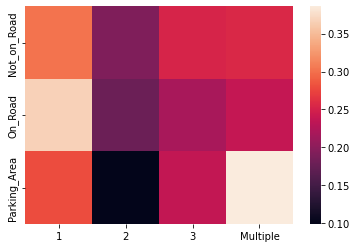


Rate Normalized by Column
                  1      2      3  Multiple  Total
Not_on_Road   0.424  0.526  0.464     0.386  1.800
On_Road       0.305  0.287  0.238     0.213  1.043
Parking_Area  0.271  0.187  0.299     0.401  1.158
Total         1.000  1.000  1.001     1.000  4.001

REL_ROAD VE_TOTAL


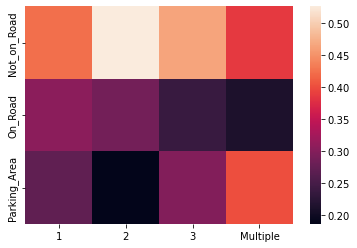


REL_ROAD WEATHR_IM
['On_Road', 'Not_on_Road', 'Parking_Area']
['B', 'A', 'D', 'C', 'E']

Count Crashes
                 A       B      C      D      E   Total
Not_on_Road    825   40539   8826   9480   3230   62900
On_Road       2199  424173  50392  86690   7831  571285
Parking_Area    39    7856    687   1281    226   10089
Total         3063  472568  59905  97451  11287  644274

Hospitalization Count
                A      B     C      D     E   Total
Not_on_Road   232  14725  2393   3242   548   21140
On_Road       398  61107  7099  11965   850   81419
Parking_Area    6    840    81    107    17    1051
Total         636  76672  9573  15314  1415  103610

Hospitalization Rate
                  A      B      C      D      E  Total
Not_on_Road   0.281  0.363  0.271  0.342  0.170  1.427
On_Road       0.181  0.144  0.141  0.138  0.109  0.713
Parking_Area  0.154  0.107  0.118  0.084  0.075  0.538
Total         0.616  0.614  0.530  0.564  0.354  2.678

Rate Normalized by Row
            

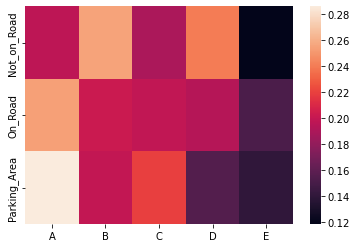


Rate Normalized by Column
                  A      B      C      D      E  Total
Not_on_Road   0.456  0.591  0.512  0.607  0.480  2.646
On_Road       0.294  0.235  0.266  0.245  0.307  1.347
Parking_Area  0.250  0.174  0.222  0.148  0.213  1.007
Total         1.000  1.000  1.000  1.000  1.000  5.000

REL_ROAD WEATHR_IM


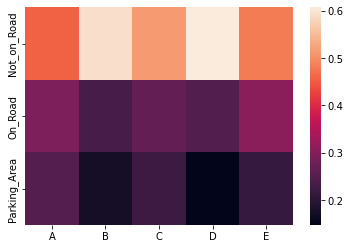


REL_ROAD WKDY_IM
['On_Road', 'Not_on_Road', 'Parking_Area']
['Weekday', 'Weekend']

Count Crashes
              Weekday  Weekend   Total
Not_on_Road     41829    21071   62900
On_Road        435861   135424  571285
Parking_Area     6867     3222   10089
Total          484557   159717  644274

Hospitalization Count
              Weekday  Weekend   Total
Not_on_Road     13850     7290   21140
On_Road         60074    21345   81419
Parking_Area      660      391    1051
Total           74584    29026  103610

Hospitalization Rate
              Weekday  Weekend  Total
Not_on_Road     0.331    0.346  0.677
On_Road         0.138    0.158  0.296
Parking_Area    0.096    0.121  0.217
Total           0.565    0.625  1.190

Rate Normalized by Row
              Weekday  Weekend  Total
Not_on_Road     0.489    0.511    1.0
On_Road         0.467    0.533    1.0
Parking_Area    0.442    0.558    1.0
Total           1.398    1.602    3.0

REL_ROAD WKDY_IM


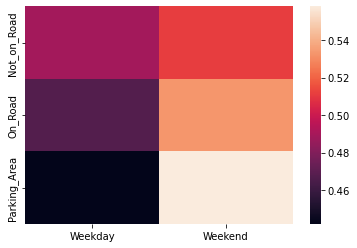


Rate Normalized by Column
              Weekday  Weekend  Total
Not_on_Road     0.586    0.554  1.140
On_Road         0.244    0.252  0.496
Parking_Area    0.170    0.194  0.364
Total           1.000    1.000  2.000

REL_ROAD WKDY_IM


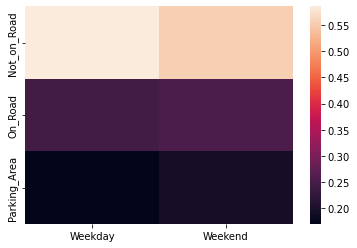


REL_ROAD WRK_ZONE
['On_Road', 'Not_on_Road', 'Parking_Area']
['0', '1', '2', '3']

Count Crashes
                   0      1    2    3   Total
Not_on_Road    61698   1088   74   40   62900
On_Road       560067  10367  716  135  571285
Parking_Area   10013     70    1    5   10089
Total         631778  11525  791  180  644274

Hospitalization Count
                   0     1    2   3   Total
Not_on_Road    20812   286   21  21   21140
On_Road        80182  1129   94  14   81419
Parking_Area    1039    10    0   2    1051
Total         102033  1425  115  37  103610

Hospitalization Rate
                  0      1      2      3  Total
Not_on_Road   0.337  0.263  0.284  0.525  1.409
On_Road       0.143  0.109  0.131  0.104  0.487
Parking_Area  0.104  0.143  0.000  0.400  0.647
Total         0.584  0.515  0.415  1.029  2.543

Rate Normalized by Row
                  0      1      2      3  Total
Not_on_Road   0.239  0.187  0.201  0.373  1.000
On_Road       0.294  0.224  0.270  0.213  1.001

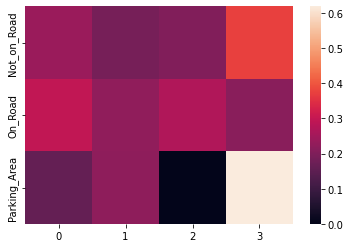


Rate Normalized by Column
                  0      1      2      3  Total
Not_on_Road   0.577  0.511  0.684  0.510  2.282
On_Road       0.245  0.212  0.316  0.101  0.874
Parking_Area  0.178  0.278  0.000  0.389  0.845
Total         1.000  1.001  1.000  1.000  4.001

REL_ROAD WRK_ZONE


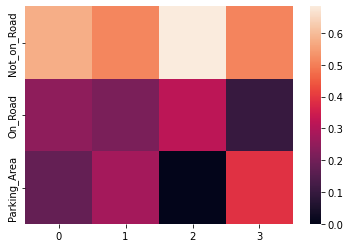


RELJCT2_IM SCH_BUS
['B', 'A', 'C', 'D']
['0', '1']

Count Crashes
            0     1   Total
A      172361   763  173124
B      247719  1321  249040
C       60676   265   60941
D      160264   905  161169
Total  641020  3254  644274

Hospitalization Count
            0    1   Total
A       33026  133   33159
B       43227  157   43384
C        8402   20    8422
D       18554   91   18645
Total  103209  401  103610

Hospitalization Rate
           0      1  Total
A      0.192  0.174  0.366
B      0.175  0.119  0.294
C      0.138  0.075  0.213
D      0.116  0.101  0.217
Total  0.621  0.469  1.090

Rate Normalized by Row
           0      1  Total
A      0.524  0.476    1.0
B      0.595  0.405    1.0
C      0.647  0.353    1.0
D      0.535  0.465    1.0
Total  2.301  1.699    4.0

RELJCT2_IM SCH_BUS


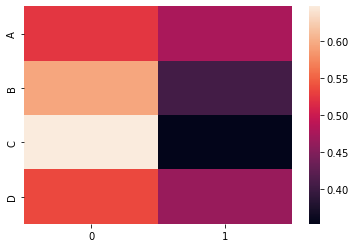


Rate Normalized by Column
           0      1  Total
A      0.309  0.372  0.681
B      0.281  0.253  0.534
C      0.223  0.161  0.384
D      0.187  0.214  0.401
Total  1.000  1.000  2.000

RELJCT2_IM SCH_BUS


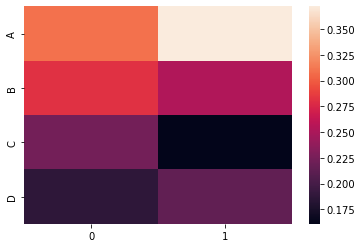


RELJCT2_IM URBANICITY
['B', 'A', 'C', 'D']
['2', '1']

Count Crashes
            1       2   Total
A      136529   36595  173124
B      189378   59662  249040
C       46080   14861   60941
D      131786   29383  161169
Total  503773  140501  644274

Hospitalization Count
           1      2   Total
A      26262   6897   33159
B      31649  11735   43384
C       6372   2050    8422
D      15488   3157   18645
Total  79771  23839  103610

Hospitalization Rate
           1      2  Total
A      0.192  0.188  0.380
B      0.167  0.197  0.364
C      0.138  0.138  0.276
D      0.118  0.107  0.225
Total  0.615  0.630  1.245

Rate Normalized by Row
           1      2  Total
A      0.505  0.495    1.0
B      0.459  0.541    1.0
C      0.501  0.499    1.0
D      0.522  0.478    1.0
Total  1.987  2.013    4.0

RELJCT2_IM URBANICITY


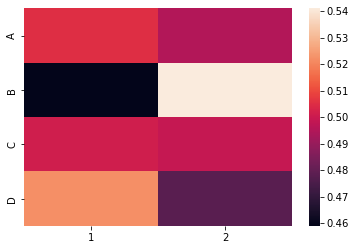


Rate Normalized by Column
           1      2  Total
A      0.313  0.299  0.612
B      0.272  0.312  0.584
C      0.225  0.219  0.444
D      0.191  0.170  0.361
Total  1.001  1.000  2.001

RELJCT2_IM URBANICITY


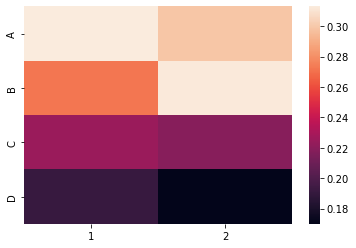


RELJCT2_IM VE_TOTAL
['B', 'A', 'C', 'D']
['2', '1', 'Multiple', '3']

Count Crashes
            1       2      3  Multiple   Total
A       11463  143599  14804      3258  173124
B       69333  134412  31607     13688  249040
C        6684   48508   4492      1257   60941
D       30225  107487  18310      5147  161169
Total  117705  434006  69213     23350  644274

Hospitalization Count
           1      2      3  Multiple   Total
A       3500  25576   3350       733   33159
B      21535  15144   4505      2200   43384
C       1563   5781    838       240    8422
D       8538   7247   2016       844   18645
Total  35136  53748  10709      4017  103610

Hospitalization Rate
           1      2      3  Multiple  Total
A      0.305  0.178  0.226     0.225  0.934
B      0.311  0.113  0.143     0.161  0.728
C      0.234  0.119  0.187     0.191  0.731
D      0.282  0.067  0.110     0.164  0.623
Total  1.132  0.477  0.666     0.741  3.016

Rate Normalized by Row
           1      2      3  Mu

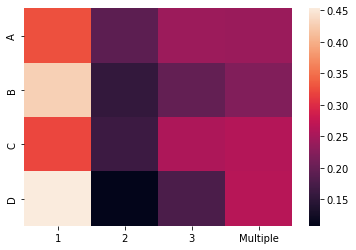


Rate Normalized by Column
           1      2      3  Multiple  Total
A      0.270  0.373  0.340     0.304  1.287
B      0.274  0.236  0.214     0.217  0.941
C      0.207  0.250  0.280     0.258  0.995
D      0.249  0.141  0.165     0.221  0.776
Total  1.000  1.000  0.999     1.000  3.999

RELJCT2_IM VE_TOTAL


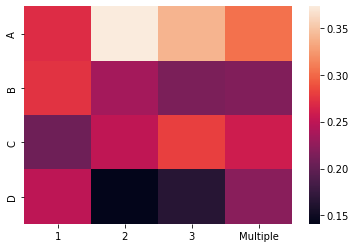


RELJCT2_IM WEATHR_IM
['B', 'A', 'C', 'D']
['B', 'A', 'D', 'C', 'E']

Count Crashes
          A       B      C      D      E   Total
A       610  129634  15136  25492   2252  173124
B      1667  179114  24892  37659   5708  249040
C       243   45540   4812   9591    755   60941
D       543  118280  15065  24709   2572  161169
Total  3063  472568  59905  97451  11287  644274

Hospitalization Count
         A      B     C      D     E   Total
A      156  24975  2766   4998   264   33159
B      358  31274  4403   6451   898   43384
C       43   6454   640   1223    62    8422
D       79  13969  1764   2642   191   18645
Total  636  76672  9573  15314  1415  103610

Hospitalization Rate
           A      B      C      D      E  Total
A      0.256  0.193  0.183  0.196  0.117  0.945
B      0.215  0.175  0.177  0.171  0.157  0.895
C      0.177  0.142  0.133  0.128  0.082  0.662
D      0.145  0.118  0.117  0.107  0.074  0.561
Total  0.793  0.628  0.610  0.602  0.430  3.063

Rate Normalized by

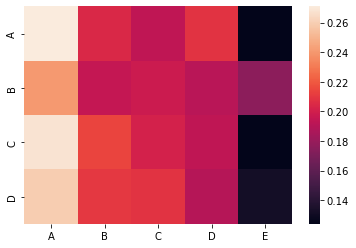


Rate Normalized by Column
           A      B      C      D      E  Total
A      0.323  0.307  0.300  0.326  0.272  1.528
B      0.271  0.278  0.290  0.285  0.365  1.489
C      0.223  0.226  0.218  0.212  0.191  1.070
D      0.183  0.188  0.192  0.178  0.172  0.913
Total  1.000  0.999  1.000  1.001  1.000  5.000

RELJCT2_IM WEATHR_IM


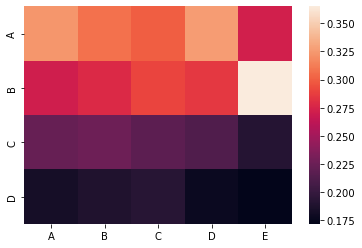


RELJCT2_IM WKDY_IM
['B', 'A', 'C', 'D']
['Weekday', 'Weekend']

Count Crashes
       Weekday  Weekend   Total
A       129184    43940  173124
B       184656    64384  249040
C        46997    13944   60941
D       123720    37449  161169
Total   484557   159717  644274

Hospitalization Count
       Weekday  Weekend   Total
A        24190     8969   33159
B        30152    13232   43384
C         6261     2161    8422
D        13981     4664   18645
Total    74584    29026  103610

Hospitalization Rate
       Weekday  Weekend  Total
A        0.187    0.204  0.391
B        0.163    0.206  0.369
C        0.133    0.155  0.288
D        0.113    0.125  0.238
Total    0.596    0.690  1.286

Rate Normalized by Row
       Weekday  Weekend  Total
A        0.478    0.522    1.0
B        0.443    0.557    1.0
C        0.462    0.538    1.0
D        0.476    0.524    1.0
Total    1.859    2.141    4.0

RELJCT2_IM WKDY_IM


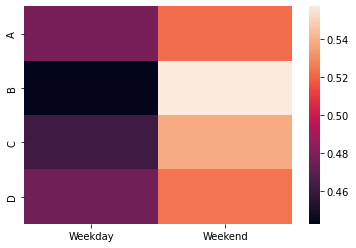


Rate Normalized by Column
       Weekday  Weekend  Total
A        0.314    0.296  0.610
B        0.274    0.298  0.572
C        0.223    0.225  0.448
D        0.189    0.181  0.370
Total    1.000    1.000  2.000

RELJCT2_IM WKDY_IM


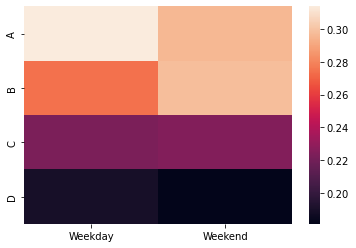


RELJCT2_IM WRK_ZONE
['B', 'A', 'C', 'D']
['0', '1', '2', '3']

Count Crashes
            0      1    2    3   Total
A      171104   1846  142   32  173124
B      241602   6850  485  103  249040
C       60076    813   39   13   60941
D      158996   2016  125   32  161169
Total  631778  11525  791  180  644274

Hospitalization Count
            0     1    2   3   Total
A       32864   274   14   7   33159
B       42359   909   92  24   43384
C        8320    94    7   1    8422
D       18490   148    2   5   18645
Total  102033  1425  115  37  103610

Hospitalization Rate
           0      1      2      3  Total
A      0.192  0.148  0.099  0.219  0.658
B      0.175  0.133  0.190  0.233  0.731
C      0.138  0.116  0.179  0.077  0.510
D      0.116  0.073  0.016  0.156  0.361
Total  0.621  0.470  0.484  0.685  2.260

Rate Normalized by Row
           0      1      2      3  Total
A      0.292  0.226  0.150  0.333  1.001
B      0.240  0.182  0.260  0.319  1.001
C      0.271  0.226  0.352  

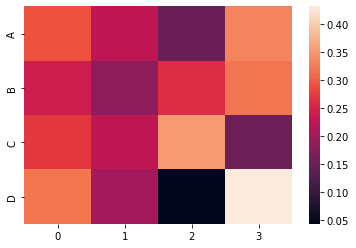


Rate Normalized by Column
           0      1      2      3  Total
A      0.309  0.316  0.204  0.319  1.148
B      0.282  0.282  0.392  0.340  1.296
C      0.223  0.246  0.371  0.112  0.952
D      0.187  0.156  0.033  0.228  0.604
Total  1.001  1.000  1.000  0.999  4.000

RELJCT2_IM WRK_ZONE


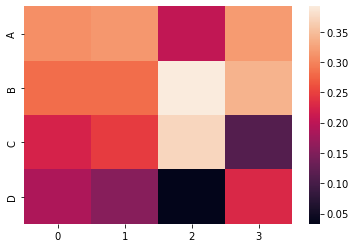


SCH_BUS URBANICITY
['0', '1']
['2', '1']

Count Crashes
            1       2   Total
0      501184  139836  641020
1        2589     665    3254
Total  503773  140501  644274

Hospitalization Count
           1      2   Total
0      79452  23757  103209
1        319     82     401
Total  79771  23839  103610

Hospitalization Rate
           1      2  Total
0      0.159  0.170  0.329
1      0.123  0.123  0.246
Total  0.282  0.293  0.575

Rate Normalized by Row
           1      2  Total
0      0.483  0.517    1.0
1      0.500  0.500    1.0
Total  0.983  1.017    2.0

SCH_BUS URBANICITY


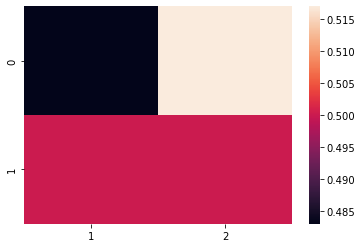


Rate Normalized by Column
           1      2  Total
0      0.563  0.579  1.142
1      0.437  0.421  0.858
Total  1.000  1.000  2.000

SCH_BUS URBANICITY


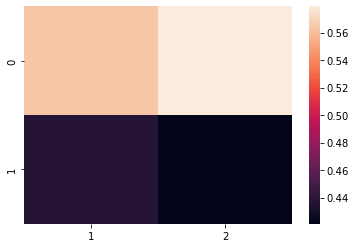


SCH_BUS VE_TOTAL
['0', '1']
['2', '1', 'Multiple', '3']

Count Crashes
            1       2      3  Multiple   Total
0      117365  431460  68912     23283  641020
1         340    2546    301        67    3254
Total  117705  434006  69213     23350  644274

Hospitalization Count
           1      2      3  Multiple   Total
0      35042  53496  10660      4011  103209
1         94    252     49         6     401
Total  35136  53748  10709      4017  103610

Hospitalization Rate
           1      2      3  Multiple  Total
0      0.299  0.124  0.155     0.172  0.750
1      0.276  0.099  0.163     0.090  0.628
Total  0.575  0.223  0.318     0.262  1.378

Rate Normalized by Row
           1      2      3  Multiple  Total
0      0.398  0.165  0.206     0.230  0.999
1      0.440  0.158  0.259     0.143  1.000
Total  0.838  0.323  0.465     0.373  1.999

SCH_BUS VE_TOTAL


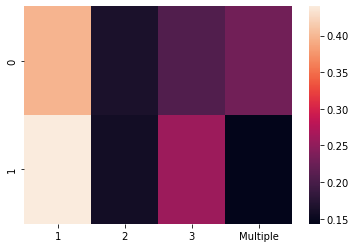


Rate Normalized by Column
           1      2      3  Multiple  Total
0      0.519  0.556  0.487     0.658   2.22
1      0.481  0.444  0.513     0.342   1.78
Total  1.000  1.000  1.000     1.000   4.00

SCH_BUS VE_TOTAL


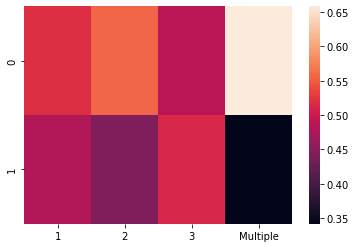


SCH_BUS WEATHR_IM
['0', '1']
['B', 'A', 'D', 'C', 'E']

Count Crashes
          A       B      C      D      E   Total
0      3045  470327  59574  96864  11210  641020
1        18    2241    331    587     77    3254
Total  3063  472568  59905  97451  11287  644274

Hospitalization Count
         A      B     C      D     E   Total
0      633  76392  9536  15238  1410  103209
1        3    280    37     76     5     401
Total  636  76672  9573  15314  1415  103610

Hospitalization Rate
           A      B      C      D      E  Total
0      0.208  0.162  0.160  0.157  0.126  0.813
1      0.167  0.125  0.112  0.129  0.065  0.598
Total  0.375  0.287  0.272  0.286  0.191  1.411

Rate Normalized by Row
           A      B      C      D      E  Total
0      0.256  0.200  0.197  0.193  0.155  1.001
1      0.279  0.209  0.187  0.217  0.109  1.001
Total  0.535  0.409  0.384  0.410  0.264  2.002

SCH_BUS WEATHR_IM


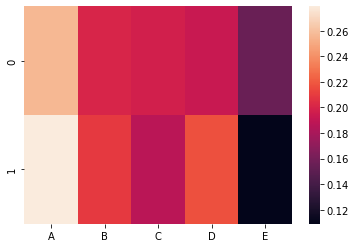


Rate Normalized by Column
           A      B      C      D     E  Total
0      0.555  0.565  0.589  0.549  0.66  2.918
1      0.445  0.435  0.411  0.451  0.34  2.082
Total  1.000  1.000  1.000  1.000  1.00  5.000

SCH_BUS WEATHR_IM


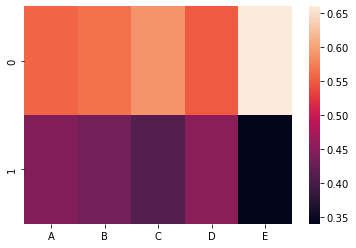


SCH_BUS WKDY_IM
['0', '1']
['Weekday', 'Weekend']

Count Crashes
       Weekday  Weekend   Total
0       481367   159653  641020
1         3190       64    3254
Total   484557   159717  644274

Hospitalization Count
       Weekday  Weekend   Total
0        74186    29023  103209
1          398        3     401
Total    74584    29026  103610

Hospitalization Rate
       Weekday  Weekend  Total
0        0.154    0.182  0.336
1        0.125    0.047  0.172
Total    0.279    0.229  0.508

Rate Normalized by Row
       Weekday  Weekend  Total
0        0.459    0.541    1.0
1        0.727    0.273    1.0
Total    1.186    0.814    2.0

SCH_BUS WKDY_IM


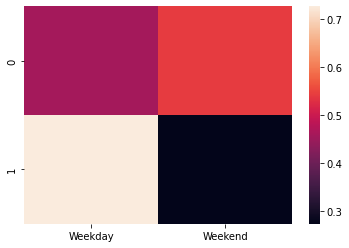


Rate Normalized by Column
       Weekday  Weekend  Total
0        0.553    0.795  1.348
1        0.447    0.205  0.652
Total    1.000    1.000  2.000

SCH_BUS WKDY_IM


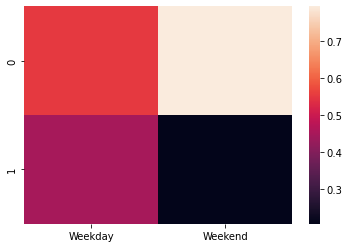


SCH_BUS WRK_ZONE
['0', '1']
['0', '1', '2', '3']

Count Crashes
            0      1    2    3   Total
0      628565  11490  791  174  641020
1        3213     35    0    6    3254
Total  631778  11525  791  180  644274

Hospitalization Count
            0     1    2   3   Total
0      101635  1422  115  37  103209
1         398     3    0   0     401
Total  102033  1425  115  37  103610

Hospitalization Rate
           0      1      2      3  Total
0      0.162  0.124  0.145  0.213  0.644
1      0.124  0.086    NaN  0.000  0.210
Total  0.286  0.210  0.145  0.213  0.854

Rate Normalized by Row
           0      1      2     3  Total
0      0.251  0.192  0.226  0.33  0.999
1      0.591  0.409    NaN  0.00  1.000
Total  0.842  0.601  0.226  0.33  1.999

SCH_BUS WRK_ZONE


/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_11277/550312234.py:69: RuntimeWarning: invalid value encountered in true_divide
  F = pd.DataFrame(E/D, index=B, columns=C).round(3)
/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_11277/550312234.py:96: RuntimeWarning: invalid value encountered in true_divide
  F = pd.DataFrame(E/D, index=B, columns=C)


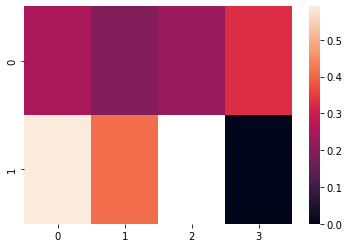


Rate Normalized by Column
           0      1    2    3  Total
0      0.566  0.591  1.0  1.0  3.157
1      0.434  0.409  NaN  0.0  0.843
Total  1.000  1.000  1.0  1.0  4.000

SCH_BUS WRK_ZONE


/var/folders/c3/8xt1bqbj0ksbm8gr7lb1cysc0000gn/T/ipykernel_11277/550312234.py:137: RuntimeWarning: invalid value encountered in true_divide
  F = pd.DataFrame(E/D, index=B, columns=C)


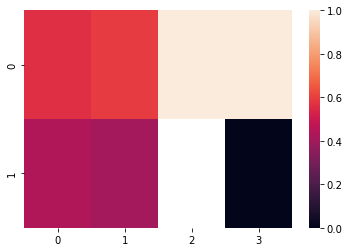


URBANICITY VE_TOTAL
['2', '1']
['2', '1', 'Multiple', '3']

Count Crashes
            1       2      3  Multiple   Total
1       83161  342129  58277     20206  503773
2       34544   91877  10936      3144  140501
Total  117705  434006  69213     23350  644274

Hospitalization Count
           1      2      3  Multiple   Total
1      25933  41406   8949      3483   79771
2       9203  12342   1760       534   23839
Total  35136  53748  10709      4017  103610

Hospitalization Rate
           1      2      3  Multiple  Total
1      0.312  0.121  0.154     0.172  0.759
2      0.266  0.134  0.161     0.170  0.731
Total  0.578  0.255  0.315     0.342  1.490

Rate Normalized by Row
           1      2      3  Multiple  Total
1      0.411  0.159  0.202     0.227  0.999
2      0.364  0.184  0.220     0.232  1.000
Total  0.775  0.343  0.422     0.459  1.999

URBANICITY VE_TOTAL


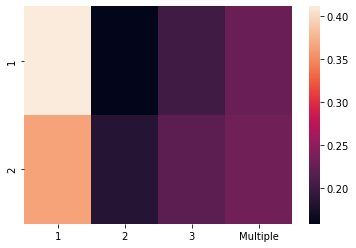


Rate Normalized by Column
           1      2      3  Multiple  Total
1      0.539  0.474  0.488     0.504  2.005
2      0.461  0.526  0.512     0.496  1.995
Total  1.000  1.000  1.000     1.000  4.000

URBANICITY VE_TOTAL


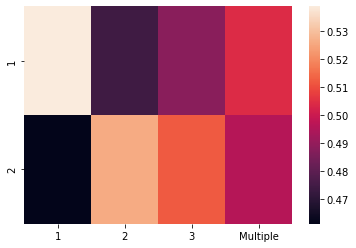


URBANICITY WEATHR_IM
['2', '1']
['B', 'A', 'D', 'C', 'E']

Count Crashes
          A       B      C      D      E   Total
1      1781  373373  47124  74118   7377  503773
2      1282   99195  12781  23333   3910  140501
Total  3063  472568  59905  97451  11287  644274

Hospitalization Count
         A      B     C      D     E   Total
1      366  59829  7376  11325   875   79771
2      270  16843  2197   3989   540   23839
Total  636  76672  9573  15314  1415  103610

Hospitalization Rate
           A     B      C      D      E  Total
1      0.206  0.16  0.157  0.153  0.119  0.795
2      0.211  0.17  0.172  0.171  0.138  0.862
Total  0.417  0.33  0.329  0.324  0.257  1.657

Rate Normalized by Row
           A      B      C      D      E  Total
1      0.259  0.202  0.197  0.193  0.149    1.0
2      0.245  0.197  0.200  0.198  0.160    1.0
Total  0.504  0.399  0.397  0.391  0.309    2.0

URBANICITY WEATHR_IM


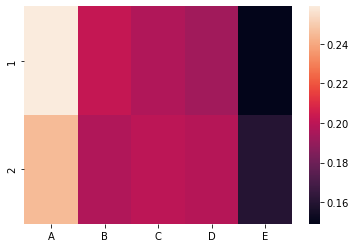


Rate Normalized by Column
           A      B      C      D      E  Total
1      0.494  0.486  0.477  0.472  0.462  2.391
2      0.506  0.514  0.523  0.528  0.538  2.609
Total  1.000  1.000  1.000  1.000  1.000  5.000

URBANICITY WEATHR_IM


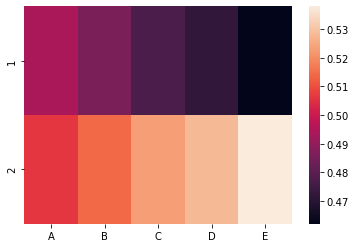


URBANICITY WKDY_IM
['2', '1']
['Weekday', 'Weekend']

Count Crashes
       Weekday  Weekend   Total
1       379140   124633  503773
2       105417    35084  140501
Total   484557   159717  644274

Hospitalization Count
       Weekday  Weekend   Total
1        57492    22279   79771
2        17092     6747   23839
Total    74584    29026  103610

Hospitalization Rate
       Weekday  Weekend  Total
1        0.152    0.179  0.331
2        0.162    0.192  0.354
Total    0.314    0.371  0.685

Rate Normalized by Row
       Weekday  Weekend  Total
1        0.459    0.541    1.0
2        0.457    0.543    1.0
Total    0.916    1.084    2.0

URBANICITY WKDY_IM


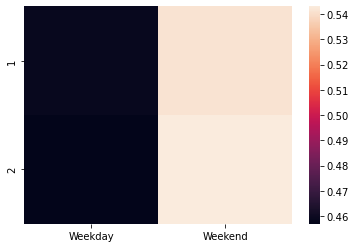


Rate Normalized by Column
       Weekday  Weekend  Total
1        0.483    0.482  0.965
2        0.517    0.518  1.035
Total    1.000    1.000  2.000

URBANICITY WKDY_IM


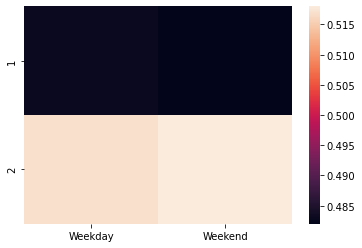


URBANICITY WRK_ZONE
['2', '1']
['0', '1', '2', '3']

Count Crashes
            0      1    2    3   Total
1      494041   9003  609  120  503773
2      137737   2522  182   60  140501
Total  631778  11525  791  180  644274

Hospitalization Count
            0     1    2   3   Total
1       78557  1103   82  29   79771
2       23476   322   33   8   23839
Total  102033  1425  115  37  103610

Hospitalization Rate
           0      1      2      3  Total
1      0.159  0.123  0.135  0.242  0.659
2      0.170  0.128  0.181  0.133  0.612
Total  0.329  0.251  0.316  0.375  1.271

Rate Normalized by Row
           0      1      2      3  Total
1      0.242  0.186  0.205  0.367    1.0
2      0.278  0.208  0.296  0.218    1.0
Total  0.520  0.394  0.501  0.585    2.0

URBANICITY WRK_ZONE


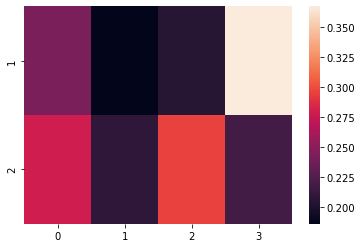


Rate Normalized by Column
           0     1      2      3  Total
1      0.483  0.49  0.426  0.644  2.043
2      0.517  0.51  0.574  0.356  1.957
Total  1.000  1.00  1.000  1.000  4.000

URBANICITY WRK_ZONE


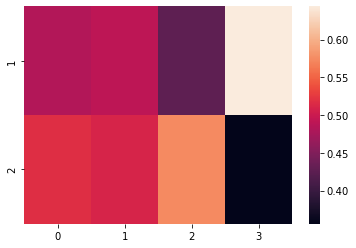


VE_TOTAL WEATHR_IM
['2', '1', 'Multiple', '3']
['B', 'A', 'D', 'C', 'E']

Count Crashes
             A       B      C      D      E   Total
1         1086   84147  12487  16565   3420  117705
2         1638  319843  39001  66940   6584  434006
3          223   51115   6392  10507    976   69213
Multiple   116   17463   2025   3439    307   23350
Total     3063  472568  59905  97451  11287  644274

Hospitalization Count
            A      B     C      D     E   Total
1         271  25898  3425   4939   603   35136
2         300  39783  4811   8200   654   53748
3          35   8010   935   1613   116   10709
Multiple   30   2981   402    562    42    4017
Total     636  76672  9573  15314  1415  103610

Hospitalization Rate
              A      B      C      D      E  Total
1         0.250  0.308  0.274  0.298  0.176  1.306
2         0.183  0.124  0.123  0.122  0.099  0.651
3         0.157  0.157  0.146  0.154  0.119  0.733
Multiple  0.259  0.171  0.199  0.163  0.137  0.929
Total     0

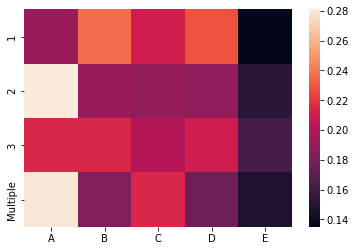


Rate Normalized by Column
              A      B      C      D      E  Total
1         0.294  0.405  0.369  0.404  0.332  1.804
2         0.216  0.164  0.166  0.166  0.187  0.899
3         0.185  0.206  0.197  0.208  0.224  1.020
Multiple  0.305  0.225  0.267  0.222  0.257  1.276
Total     1.000  1.000  0.999  1.000  1.000  4.999

VE_TOTAL WEATHR_IM


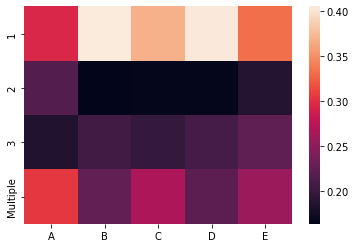


VE_TOTAL WKDY_IM
['2', '1', 'Multiple', '3']
['Weekday', 'Weekend']

Count Crashes
          Weekday  Weekend   Total
1           83194    34511  117705
2          329744   104262  434006
3           53584    15629   69213
Multiple    18035     5315   23350
Total      484557   159717  644274

Hospitalization Count
          Weekday  Weekend   Total
1           24219    10917   35136
2           39303    14445   53748
3            7958     2751   10709
Multiple     3104      913    4017
Total       74584    29026  103610

Hospitalization Rate
          Weekday  Weekend  Total
1           0.291    0.316  0.607
2           0.119    0.139  0.258
3           0.149    0.176  0.325
Multiple    0.172    0.172  0.344
Total       0.731    0.803  1.534

Rate Normalized by Row
          Weekday  Weekend  Total
1           0.479    0.521    1.0
2           0.462    0.538    1.0
3           0.458    0.542    1.0
Multiple    0.500    0.500    1.0
Total       1.899    2.101    4.0

VE_TOTAL WKDY_IM


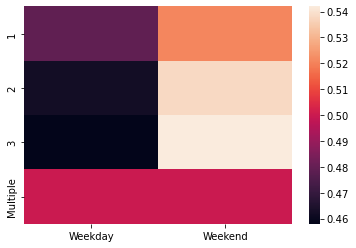


Rate Normalized by Column
          Weekday  Weekend  Total
1           0.398    0.394  0.792
2           0.163    0.173  0.336
3           0.203    0.219  0.422
Multiple    0.235    0.214  0.449
Total       0.999    1.000  1.999

VE_TOTAL WKDY_IM


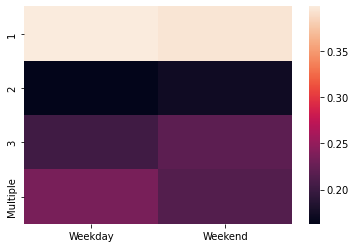


VE_TOTAL WRK_ZONE
['2', '1', 'Multiple', '3']
['0', '1', '2', '3']

Count Crashes
               0      1    2    3   Total
1         116345   1274   68   18  117705
2         425690   7609  573  134  434006
3          67243   1820  127   23   69213
Multiple   22500    822   23    5   23350
Total     631778  11525  791  180  644274

Hospitalization Count
               0     1    2   3   Total
1          34769   340   18   9   35136
2          52938   727   67  16   53748
3          10426   246   25  12   10709
Multiple    3900   112    5   0    4017
Total     102033  1425  115  37  103610

Hospitalization Rate
              0      1      2      3  Total
1         0.299  0.267  0.265  0.500  1.331
2         0.124  0.096  0.117  0.119  0.456
3         0.155  0.135  0.197  0.522  1.009
Multiple  0.173  0.136  0.217  0.000  0.526
Total     0.751  0.634  0.796  1.141  3.322

Rate Normalized by Row
              0      1      2      3  Total
1         0.225  0.201  0.199  0.376  1.001
2   

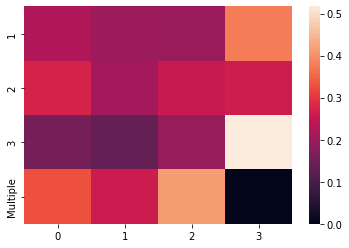


Rate Normalized by Column
              0      1      2      3  Total
1         0.398  0.421  0.333  0.438  1.590
2         0.165  0.151  0.147  0.105  0.568
3         0.206  0.213  0.247  0.457  1.123
Multiple  0.231  0.215  0.273  0.000  0.719
Total     1.000  1.000  1.000  1.000  4.000

VE_TOTAL WRK_ZONE


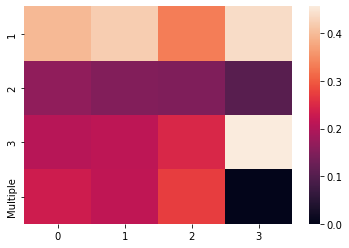


WEATHR_IM WKDY_IM
['B', 'A', 'D', 'C', 'E']
['Weekday', 'Weekend']

Count Crashes
       Weekday  Weekend   Total
A         2270      793    3063
B       354255   118313  472568
C        45169    14736   59905
D        74571    22880   97451
E         8292     2995   11287
Total   484557   159717  644274

Hospitalization Count
       Weekday  Weekend   Total
A          452      184     636
B        54818    21854   76672
C         7077     2496    9573
D        11206     4108   15314
E         1031      384    1415
Total    74584    29026  103610

Hospitalization Rate
       Weekday  Weekend  Total
A        0.199    0.232  0.431
B        0.155    0.185  0.340
C        0.157    0.169  0.326
D        0.150    0.180  0.330
E        0.124    0.128  0.252
Total    0.785    0.894  1.679

Rate Normalized by Row
       Weekday  Weekend  Total
A        0.462    0.538    1.0
B        0.456    0.544    1.0
C        0.481    0.519    1.0
D        0.456    0.544    1.0
E        0.492    0.508    1

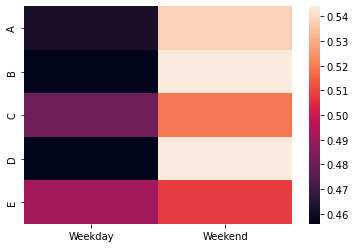


Rate Normalized by Column
       Weekday  Weekend  Total
A        0.254    0.260  0.514
B        0.197    0.207  0.404
C        0.200    0.189  0.389
D        0.191    0.201  0.392
E        0.158    0.143  0.301
Total    1.000    1.000  2.000

WEATHR_IM WKDY_IM


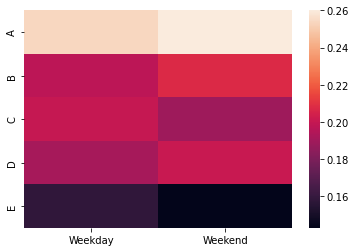


WEATHR_IM WRK_ZONE
['B', 'A', 'D', 'C', 'E']
['0', '1', '2', '3']

Count Crashes
            0      1    2    3   Total
A        3020     28   13    2    3063
B      463100   8770  586  112  472568
C       58923    904   61   17   59905
D       95520   1771  115   45   97451
E       11215     52   16    4   11287
Total  631778  11525  791  180  644274

Hospitalization Count
            0     1    2   3   Total
A         628     4    4   0     636
B       75481  1076   86  29   76672
C        9447   115    8   3    9573
D       15073   222   16   3   15314
E        1404     8    1   2    1415
Total  102033  1425  115  37  103610

Hospitalization Rate
           0      1      2      3  Total
A      0.208  0.143  0.308  0.000  0.659
B      0.163  0.123  0.147  0.259  0.692
C      0.160  0.127  0.131  0.176  0.594
D      0.158  0.125  0.139  0.067  0.489
E      0.125  0.154  0.062  0.500  0.841
Total  0.814  0.672  0.787  1.002  3.275

Rate Normalized by Row
           0      1      2    

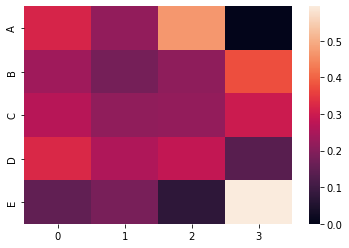


Rate Normalized by Column
           0      1      2      3  Total
A      0.255  0.213  0.391  0.000  0.859
B      0.200  0.183  0.186  0.258  0.827
C      0.197  0.189  0.167  0.176  0.729
D      0.194  0.187  0.177  0.067  0.625
E      0.154  0.229  0.079  0.499  0.961
Total  1.000  1.001  1.000  1.000  4.001

WEATHR_IM WRK_ZONE


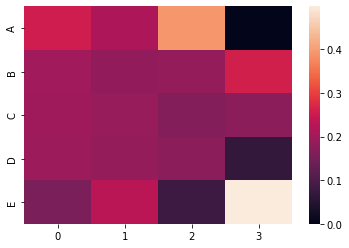


WKDY_IM WRK_ZONE
['Weekday', 'Weekend']
['0', '1', '2', '3']

Count Crashes
              0      1    2    3   Total
Weekday  474855   8928  624  150  484557
Weekend  156923   2597  167   30  159717
Total    631778  11525  791  180  644274

Hospitalization Count
              0     1    2   3   Total
Weekday   73393  1072   87  32   74584
Weekend   28640   353   28   5   29026
Total    102033  1425  115  37  103610

Hospitalization Rate
             0      1      2      3  Total
Weekday  0.155  0.120  0.139  0.213  0.627
Weekend  0.183  0.136  0.168  0.167  0.654
Total    0.338  0.256  0.307  0.380  1.281

Rate Normalized by Row
             0      1      2      3  Total
Weekday  0.246  0.191  0.222  0.340  0.999
Weekend  0.280  0.208  0.257  0.255  1.000
Total    0.526  0.399  0.479  0.595  1.999

WKDY_IM WRK_ZONE


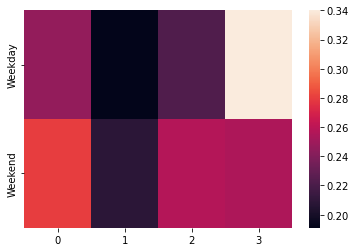


Rate Normalized by Column
             0      1      2      3  Total
Weekday  0.459  0.469  0.454  0.561  1.943
Weekend  0.541  0.531  0.546  0.439  2.057
Total    1.000  1.000  1.000  1.000  4.000

WKDY_IM WRK_ZONE


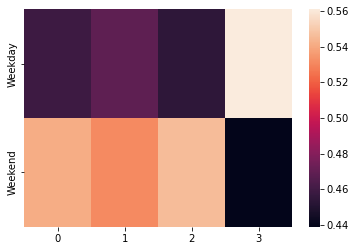



Narrow Features
HOSPITAL
AGE_IM
SEX_IM
PER_TYP
BODY_TYP
MAKE
HOUR_IM
INT_HWY
LGTCON_IM
MONTH
PEDS
PERMVIT
REL_ROAD
RELJCT2_IM
SCH_BUS
URBANICITY
VE_TOTAL
WEATHR_IM
WKDY_IM
WRK_ZONE


New Features after Narrowing:
	 HOSPITAL
	 AGE_IM
	 SEX_IM
	 PER_TYP
	 BODY_TYP
	 MAKE
	 HOUR_IM
	 INT_HWY
	 LGTCON_IM
	 MONTH
	 PEDS
	 PERMVIT
	 REL_ROAD
	 RELJCT2_IM
	 SCH_BUS
	 URBANICITY
	 VE_TOTAL
	 WEATHR_IM
	 WKDY_IM
	 WRK_ZONE

Feature_Engineering_Cross_Two

   HOSPITAL AGE_IM  SEX_IM PER_TYP     BODY_TYP MAKE    HOUR_IM  INT_HWY  \
0         0    71+    Male  In_VIT          Car    B    Mid_Day        0   
1         0  19-52    Male  In_VIT          SUV    E    Mid_Day        0   
2         0  16-18    Male  In_VIT  Light_Truck    G  Early_Eve        0   
3         0  16-18  Female  In_VIT          Car    F  Early_Eve        0   
4         0  16-18    Male  In_VIT          Car    F  Early_Eve        0   

      LGTCON_IM   MONTH  ... REL_ROAD RELJCT2_IM SCH_BUS URBANICITY VE_TOTAL  \
0      Dayl

2022-07-01 17:09:57.235709: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-01 17:09:57.236193: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


focal_loss
alpha =  0.8615  gamma_1 =  0.0  gamma_2 =  0.0
focal_loss
alpha =  0.8615  gamma_1 =  0.0  gamma_2 =  0.0
focal_loss
alpha =  0.8615  gamma_1 =  0.0  gamma_2 =  0.0
6041/6041 [==============================] - 2s 305us/step - loss: 0.1461 - accuracy: 0.6669 - precision: 0.2856 - recall: 0.7134 - true_negatives: 106727.0000 - false_positives: 55473.0000 - false_negatives: 8908.0000 - true_positives: 22175.0000
[[106727.  55473.]
 [  8908.  22175.]]
 &  &  &  &  &  106727  &  55473 \cr
 &&&&&  8908  &  22175 \cr\hline
Precision =  28.56 %
Recall =  71.34 %
True Negative Rate =  65.8 %


In [23]:
def Main():
    target = 'HOSPITAL'

#    df_Accident, df_Person = Import_Data()
    df_Accident, df_Person = Import_Data_from_Limited()

    data = Build_Dataset(df_Accident, df_Person)
    
    print (data[target].value_counts())
    
    Correlation_All(data, target)
    
    Crosstabs_Correlation(data, target)
    
    data = Narrow_Features(data)
    
    data = Feature_Engineering_Cross_Two(data)
    
    print (data.head())
    
    data = Get_Dummies(data)
    
    x_train, x_test, y_train, y_test = Split_Data(data, target)

    print("Counter(y_train): ", Counter(y_train))
    alpha = Counter(y_train)[0] / Counter(y_train)[1]
    print ("alpha = ", alpha)

    model = Make_Model_2(x_train)
    
    s = data[target].sum()
    t = len(data)
    p = round(t/s,2)
    alpha = (p/(p+1))*1.0
    alpha = round(alpha,4)
    alpha = np.float32(alpha) # Otherwise throws weird and unnecessary multiplication error
    print ('p = ', p, ' alpha = ', alpha)

    get_custom_objects().update(
        {'focal_loss_fn': focal_loss_with_parameters(alpha=alpha, gamma_1 = 0.0, gamma_2 = 0.0)}
    )
    model = Compile_Model(model, 'focal_loss_fn')
    Fit_Model(x_train, y_train, x_test, y_test, model)



Main()

# Results

All features, gamma=0.0

[[106084.  56116.]
 [  8879.  22204.]]
 &  &  &  &  &  106084  &  56116 \cr
 &&&&&  8879  &  22204 \cr\hline
Precision =  28.35 %
Recall =  71.43 %
True Negative Rate =  65.4 %

Only easy features:  

	 AGE_IM
	 SEX_IM
	 HOUR_IM
	 INT_HWY
	 MONTH
	 URBANICITY
	 WEATHR_IM
	 WKDY_IM

[[ 56373. 105827.]
 [  7832.  23251.]]
 &  &  &  &  &  56373  &  105827 \cr
 &&&&&  7832  &  23251 \cr\hline
Precision =  18.01 %
Recall =  74.8 %
True Negative Rate =  34.76 %

Medium features, that require significant preparation and record-keeping.  



	 AGE_IM
	 SEX_IM
	 HOUR_IM
	 INT_HWY
	 LGTCON_IM
	 MONTH
	 REL_ROAD
	 RELJCT2_IM
	 URBANICITY
	 WEATHR_IM
	 WKDY_IM
	 WRK_ZONE

[[82573. 79627.]
 [10028. 21055.]]
 &  &  &  &  &  82573  &  79627 \cr
 &&&&&  10028  &  21055 \cr\hline
Precision =  20.91 %
Recall =  67.74 %
True Negative Rate =  50.91 %

All features, now including Per_TYP, with Feature_Engineering_Cross_Two with AGE_IM and SEX_IM

[[107859.  54341.]
 [  9078.  22005.]]
 &  &  &  &  &  107859  &  54341 \cr
 &&&&&  9078  &  22005 \cr\hline
Precision =  28.82 %
Recall =  70.79 %
True Negative Rate =  66.5 %

Adding AGE_IM_x_SCH_BUS with two classes for age adds 5 true positives but also adds 80 false positives.  

[[107779.  54421.]
 [  9073.  22010.]]
 &  &  &  &  &  107779  &  54421 \cr
 &&&&&  9073  &  22010 \cr\hline
Precision =  28.8 %
Recall =  70.81 %
True Negative Rate =  66.45 %

AGE_IM_x_SCH_BUS with all classes for age adds 170 true positives but 132 false positives.  Go with this one.  

[[106727.  55473.]
 [  8908.  22175.]]
 &  &  &  &  &  106727  &  55473 \cr
 &&&&&  8908  &  22175 \cr\hline
Precision =  28.56 %
Recall =  71.34 %
True Negative Rate =  65.8 %